# Lyft Bike Share Data Bay Area

Vsualizations of Lyft bike share usage in 2020. See [Sources](http://localhost:8888/notebooks/Desktop/Lyft%20Bike%20Project.ipynb#Sources) for details on data and processes.

### Research Questions
1. How has behavior changed pre/post Covid?
2. Are there notable differences between members and not?
3. What are the most popular stations that trips originate from? Dos this differ between members and casual riders?

### Things to Come Back to
* Drop bad cells and update queries (NANs)
* Ensuring no dupes across CSV files
* Getting data from website
* Putting shape files somewhere publicly accessible
* Getting data April - forward

#### Things Complete
* Start date as own variable, not overwritten
* Cleaning up April data in March file
* Cleaning up (0,0) rides
* Consolidating data clean up
* Re-indexing joined files
* Querying by condition (rides by day where covid=1, most popular station where member)
* Mapping points to city bounds


In [213]:
## Imports - General
import matplotlib.pyplot as plt
import numpy             as np
import matplotlib        as matplotlib
import pandas            as pd
from   datetime          import datetime

%matplotlib inline

## Imports - Plotting

import descartes
import geopandas as gpd
import glob
from shapely.geometry import Point, polygon

## Imports - Zip File
import os
import tarfile
from six.moves import urllib
import zipfile

In [135]:
## Download Zip Files, Unzip and Save

DOWNLOAD_ROOT = 'https://s3.amazonaws.com/baywheels-data/'
BW_PATH       = os.path.join('datasets', 'baywheelsdata')
BW_URL        = DOWNLOAD_ROOT +  '2017-fordgobike-tripdata.csv.zip'

In [145]:
def fetch_baywheels_data(bw_url = BW_URL,bw_path=BW_PATH):
    if not os.path.isdir(bw_path):
        os.makedirs(bw_path)
    for month in range(1):#,7):
        #file_name= '20200'+ str(month) + '-baywheels-tripdata.csv.zip'
        zip_path = os.path.join(bw_path,'2017-fordgobike-tripdata.csv.zip')        
        urllib.request.urlretrieve(bw_url,zip_path)
        baywheels_zip = tarfile.open(zip_path, mode='w')
        baywheels_zip.extractall(path = bw_path)
        baywheels_zip.close()

In [ ]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'
HOUSING_PATH  = os.path.join('datasets', 'housing')
HOUSING_URL   = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    #housing_tgz = tarfile.open(tgz_path)
    #housing_tgz.extractall(path = housing_path)
    
    housing_tgz.close()

In [165]:
## Read in all the CSVs. For Proof of Concept
## From Downloads not Web. For Proof of Concept
## Excluding Data April 2020 forward because column names are different

df = pd.concat([pd.read_csv(f) for f in glob.glob('/Users/kailinkoch/Desktop/Baywheels Python Practice/baywheels-project/datasets/baywheelsdata/2020*-baywheels-tripdata.csv')], ignore_index=True)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


## Cleaning Up Data Set

* Small number (24 records, ~0.003% of total records) of records are from the `16th St Fleet Depot`. These records have a coordinate of (0,0) and it is not clear that these are legitimate rides. As such, I am updating them to `NaN` to ensure the proper display of the chart.
* Small number of records (1792 records, ~0.2% of total records) from the wrong month. Putting in basic logic to remove April records given we haven't imported April file
* Changing confusing nomenclature of users.

In [166]:
## Identify number of records where starting coordinates = (0,0)
min_latitude = min(df.start_station_latitude)
max_longitude = max(df.start_station_longitude)
print(f'the min latitude is {min_latitude}')
print(f'the max longitude is {max_longitude}')
print(pd.DataFrame.count(df.loc[df['start_station_latitude']== 0.0]))
pd.DataFrame.count(df.loc[df['start_station_longitude']== 0.0])

the min latitude is 0.0
the max longitude is 0.0
duration_sec               24
start_time                 24
end_time                   24
start_station_id           24
start_station_name         24
start_station_latitude     24
start_station_longitude    24
end_station_id              0
end_station_name            0
end_station_latitude       24
end_station_longitude      24
bike_id                    24
user_type                  24
rental_access_method       24
dtype: int64


duration_sec               24
start_time                 24
end_time                   24
start_station_id           24
start_station_name         24
start_station_latitude     24
start_station_longitude    24
end_station_id              0
end_station_name            0
end_station_latitude       24
end_station_longitude      24
bike_id                    24
user_type                  24
rental_access_method       24
dtype: int64

In [167]:
## Updating (0,0) entries to Nan
df.loc[df['start_station_latitude'] == 0,'start_station_latitude'] = np.nan
df.loc[df['start_station_longitude'] == 0,'start_station_longitude'] = np.nan

In [168]:
## Rename 2 user types because it's very confusing that a 'customer' is a casual one-off purchaser!

df.loc[df['user_type'] == 'Subscriber','user_type'] = 'annual_subscriber'
df.loc[df['user_type'] == 'Customer','user_type'] = 'casual_rider'

In [169]:
## Confirming the above was done properly

min_latitude =  min(df.start_station_latitude)
max_longitude = max(df.start_station_longitude)
print(f'the min latitude is {min_latitude}')
print(f'the max longitude is {max_longitude}')

the min latitude is 37.2530496667
the max longitude is -121.8070486667


### Adding New Variables for Aggregation
* Date - so that we can see total records by date
* City - so that we can see behavior change on the county level rather than bike dock level
* Coordinates - not yet as `POINT` object, just as a tuple so we can use to identify if point in city
* Covid - binary variable for pre/post 3/16 (when shelter in place went into effect in Bay Area

In [284]:
##  Adding 2 new fields to the DF: a day variable and a city variable

#df.insert(loc=14, column = 'start_date',           value = 'datetime')
#df.insert(loc=14, column = 'coordinates_nongeom2', value = zip)
#df.insert(loc=14, column = 'start_month',          value = 'datetime')
#df.insert(loc=14, column = 'covid',                value = int)
#df.insert(loc=14, column = 'start_week',            value = 'datetime')
#df.insert(loc=14, column = 'city',                 value = str)

In [171]:
## Populating tuple for coordinates (NOT yet in geometry form)

df['coordinates_nongeom2'] = [(xy) for xy in zip(df["start_station_longitude"], df["start_station_latitude"])]

In [288]:
## Populating basic date fields 

df["start_time"]  = pd.to_datetime(df["start_time"])
#df["start_date"]  = df["start_time"].dt.date
#df["start_month"] = df["start_time"].dt.month
df['start_week']  = df['start_time'].dt.weekofyear
df['first_day'] = df['start_time'] - df['start_time'].dt.weekday * np.timedelta64(1, 'D')
df['first_day'] = df['first_day'].dt.date

duration_sec              start_time                  end_time  \
0         83118 2020-01-31 15:23:47.733  2020-02-01 14:29:06.2630   
1         68239 2020-01-31 15:40:31.616  2020-02-01 10:37:51.0000   
2         55407 2020-01-31 17:48:16.635  2020-02-01 09:11:44.3170   
3         54929 2020-01-31 17:53:03.413  2020-02-01 09:08:32.6340   
4         55700 2020-01-31 17:12:33.460  2020-02-01 08:40:53.6460   
5         11333 2020-01-31 22:48:22.639  2020-02-01 01:57:15.7160   
6         11341 2020-01-31 22:48:12.989  2020-02-01 01:57:14.1650   
7          4038 2020-01-31 23:32:03.907  2020-02-01 00:39:22.0210   
8          4059 2020-01-31 23:31:01.161  2020-02-01 00:38:40.8570   
9          1980 2020-01-31 23:49:09.230  2020-02-01 00:22:09.7540   

   start_station_id             start_station_name  start_station_latitude  \
0             400.0  Buchanan St at North Point St               37.804272   
1              99.0           Folsom St at 15th St               37.767037   
2             197.0    El Embarcadero at Grand Ave               37.808848   
3             197.0    El Embarcadero at Grand Ave               37.808848   
4              12.0    Pier 1/2 at The Embarcadero               37.796389   
5              60.0           8th St at Ringold St               37.774520   
6              60.0           8th St at Ringold St               37.774520   
7             450.0       Funston Ave at Irving St               37.763934   
8             450.0       Funston Ave at Irving St               37.763934   
9             238.0   MLK Jr Way at University Ave               37.871719   

   start_station_longitude  end_station_id               end_station_name  \
0              -122.433537           400.0  Buchanan St at North Point St   
1              -122.415443            99.0           Folsom St at 15th St   
2              -122.249680           197.0    El Embarcadero at Grand Ave   
3              -122.249680           197.0    El Embarcadero at Grand Ave   
4              -122.394586           371.0     Lombard St at Columbus Ave   
5              -122.409449            75.0       Market St at Franklin St   
6              -122.409449            75.0       Market St at Franklin St   
7              -122.470651           450.0       Funston Ave at Irving St   
8              -122.470651           450.0       Funston Ave at Irving St   
9              -122.273068           198.0                      Snow Park   

   end_station_latitude  ...          user_type  rental_access_method  \
0             37.804272  ...       casual_rider                   NaN   
1             37.767037  ...  annual_subscriber                   NaN   
2             37.808848  ...       casual_rider                   NaN   
3             37.808848  ...       casual_rider                   NaN   
4             37.802746  ...       casual_rider                   NaN   
5             37.773793  ...       casual_rider                   NaN   
6             37.773793  ...       casual_rider                   NaN   
7             37.763934  ...       casual_rider                   NaN   
8             37.763934  ...       casual_rider                   NaN   
9             37.807813  ...       casual_rider                   NaN   

  start_week_day start_week covid  start_month  \
0       datetime          5     0            1   
1       datetime          5     0            1   
2       datetime          5     0            1   
3       datetime          5     0            1   
4       datetime          5     0            1   
5       datetime          5     0            1   
6       datetime          5     0            1   
7       datetime          5     0            1   
8       datetime          5     0            1   
9       datetime          5     0            1   

                        coordinates_nongeom2  start_date  \
0           (-122.4335369468, 37.8042720199)  2020-01-31   
1          (-122.41544250000001, 37.7670373)  2020-01-31   
2

In [287]:
## Make a Binary Pre-Post Covid Variable (Shelter in Place takes effect on 3/16)

df.loc[df['start_time'] >= '3/16/20', 'covid'] = 1
df.loc[df['start_time'] <  '3/16/20', 'covid'] = 0


duration_sec              start_time                  end_time  \
0         83118 2020-01-31 15:23:47.733  2020-02-01 14:29:06.2630   
1         68239 2020-01-31 15:40:31.616  2020-02-01 10:37:51.0000   
2         55407 2020-01-31 17:48:16.635  2020-02-01 09:11:44.3170   
3         54929 2020-01-31 17:53:03.413  2020-02-01 09:08:32.6340   
4         55700 2020-01-31 17:12:33.460  2020-02-01 08:40:53.6460   
5         11333 2020-01-31 22:48:22.639  2020-02-01 01:57:15.7160   
6         11341 2020-01-31 22:48:12.989  2020-02-01 01:57:14.1650   
7          4038 2020-01-31 23:32:03.907  2020-02-01 00:39:22.0210   
8          4059 2020-01-31 23:31:01.161  2020-02-01 00:38:40.8570   
9          1980 2020-01-31 23:49:09.230  2020-02-01 00:22:09.7540   

   start_station_id             start_station_name  start_station_latitude  \
0             400.0  Buchanan St at North Point St               37.804272   
1              99.0           Folsom St at 15th St               37.767037   
2             197.0    El Embarcadero at Grand Ave               37.808848   
3             197.0    El Embarcadero at Grand Ave               37.808848   
4              12.0    Pier 1/2 at The Embarcadero               37.796389   
5              60.0           8th St at Ringold St               37.774520   
6              60.0           8th St at Ringold St               37.774520   
7             450.0       Funston Ave at Irving St               37.763934   
8             450.0       Funston Ave at Irving St               37.763934   
9             238.0   MLK Jr Way at University Ave               37.871719   

   start_station_longitude  end_station_id               end_station_name  \
0              -122.433537           400.0  Buchanan St at North Point St   
1              -122.415443            99.0           Folsom St at 15th St   
2              -122.249680           197.0    El Embarcadero at Grand Ave   
3              -122.249680           197.0    El Embarcadero at Grand Ave   
4              -122.394586           371.0     Lombard St at Columbus Ave   
5              -122.409449            75.0       Market St at Franklin St   
6              -122.409449            75.0       Market St at Franklin St   
7              -122.470651           450.0       Funston Ave at Irving St   
8              -122.470651           450.0       Funston Ave at Irving St   
9              -122.273068           198.0                      Snow Park   

   end_station_latitude  ...          user_type  rental_access_method  \
0             37.804272  ...       casual_rider                   NaN   
1             37.767037  ...  annual_subscriber                   NaN   
2             37.808848  ...       casual_rider                   NaN   
3             37.808848  ...       casual_rider                   NaN   
4             37.802746  ...       casual_rider                   NaN   
5             37.773793  ...       casual_rider                   NaN   
6             37.773793  ...       casual_rider                   NaN   
7             37.763934  ...       casual_rider                   NaN   
8             37.763934  ...       casual_rider                   NaN   
9             37.807813  ...       casual_rider                   NaN   

  start_week_day start_week covid  start_month  \
0       datetime          5     0            1   
1       datetime          5     0            1   
2       datetime          5     0            1   
3       datetime          5     0            1   
4       datetime          5     0            1   
5       datetime          5     0            1   
6       datetime          5     0            1   
7       datetime          5     0            1   
8       datetime          5     0            1   
9       datetime          5     0            1   

                        coordinates_nongeom2  start_date  \
0           (-122.4335369468, 37.8042720199)  2020-01-31   
1          (-122.41544250000001, 37.7670373)  2020-01-31   
2

In [174]:
## Removing April Entries

df.loc[df['start_time']>= '04/01/20', 'start_station_latitude'] = np.nan
df.loc[df['start_time']>= '04/01/20', 'start_station_longitude'] = np.nan

## Basic Info Pre-COVID
* Run Pre Covid (Covid==0, Jan - March 16, when shelter in place began in bay area)
* Breakdown of annual subscribers vs casual riders
* Most popular stations
* Rides by day of the Week

In [175]:
## How many rides in this data set? How many are pre-COVID?

df_precovid = df[df['covid'] == 0]
total_rides = (df['user_type'].count())
print(f'There are {total_rides} total rides in this data set')

precovid_rides = (df_precovid['user_type'].count())
print(f'There are {precovid_rides} rides from Pre-COVID in this data set')


There are 905007 total rides in this data set
There are 865018 rides from Pre-COVID in this data set


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


NameError: name 'fig' is not defined

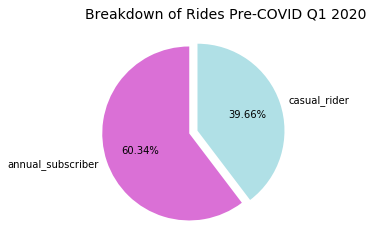

In [176]:
## What is the breakdown of users (casual users vs. annual subscriber)

df_precovid['user_type'].value_counts().plot(kind ='pie', startangle=90, explode = [0.05,0.05], colors = ('orchid', 'powderblue'), autopct='%.2f%%',radius = 1)
plt.title('Breakdown of Rides Pre-COVID Q1 2020', fontsize = 14, loc = 'left')
plt.axes().set_ylabel('')

fig.savefig('baywheels_rides_by_ridertype_precovid_q1_2020' + '.png', facecolor='white', dpi=150, bbox_inches='tight')

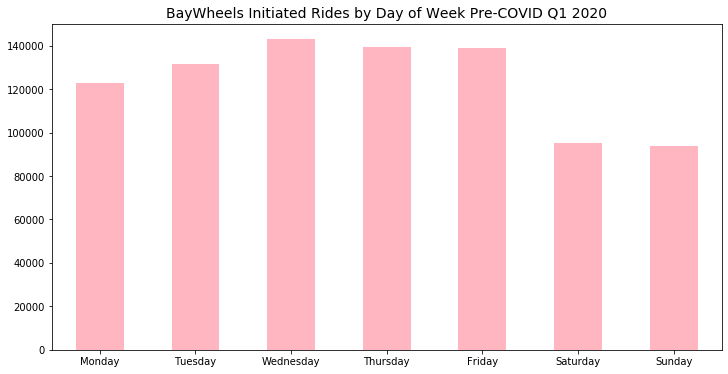

In [177]:
## Rides by Day of Week (PreCovid, 0 == Monday, 6 == Sunday)

## df_precovid_casual_riders      = df_precovid[df_precovid['user_type'] == 'casual_rider']
## df_precovid_annual_subscribers = df_precovid[df_precovid['user_type'] == 'annual_subscriber']

dayofweek = df_precovid["start_time"].dt.weekday.value_counts().sort_index()
## dayofweek_annual_subscribers = df_precovid_annual_subscribers["start_time"].dt.weekday.value_counts().sort_index()
## dayofweek_casual_riders = df_precovid_casual_riders["start_time"].dt.weekday.value_counts().sort_index()

fig,ax = plt.subplots(figsize=(12,6))
dayofweek_figure = dayofweek.plot(kind = 'bar', color = 'lightpink')

plt.Axes.set_xticklabels(dayofweek_figure,labels = ['Monday', 'Tuesday','Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation = 0)
plt.title('BayWheels Initiated Rides by Day of Week Pre-COVID Q1 2020', fontsize = 14, loc ='center')

## Same pattern for casual vs. annual
fig.savefig('baywheels_rides_by_dayofweek_precovid_q1_2020' + '.png', facecolor='white', dpi=150, bbox_inches='tight')

In [178]:
## Most Popular Stations 

top_stations=pd.DataFrame(df_precovid.groupby(["start_station_latitude", "start_station_longitude", "start_station_name"],as_index=False).size().sort_values(ascending=False).head(10))
top_stations.reset_index(inplace=True)
top_stations.rename({0:'number_of_rides'}, axis='columns', inplace=True)
top_stations
## Mostly the same top stations between casual and annual

start_station_latitude  start_station_longitude  \
0               37.776619              -122.417385   
1               37.776598              -122.395282   
2               37.775880              -122.393170   
3               37.789756              -122.394643   
4               37.794497              -122.394838   
5               37.786375              -122.404904   
6               37.795392              -122.394203   
7               37.783899              -122.408445   
8               37.789625              -122.400811   
9               37.764478              -122.402570   

                                  start_station_name  number_of_rides  
0                               Market St at 10th St             7302  
1     San Francisco Caltrain (Townsend St at 4th St)             7217  
2                                 Berry St at 4th St             6346  
3                              Howard St at Beale St             5203  
4                            Market St at Steuart St             4848  
5       Powell St BART Station (Market St at 4th St)             4648  
6  San Francisco Ferry Building (Harry Bridges Pl...             4569  
7       Powell St BART Station (Market St at 5th St)             4455  
8   Montgomery St BART Station (Market St at 2nd St)             4313  
9                         Rhode Island St at 17th St             3235

## Ride Behavior around COVID

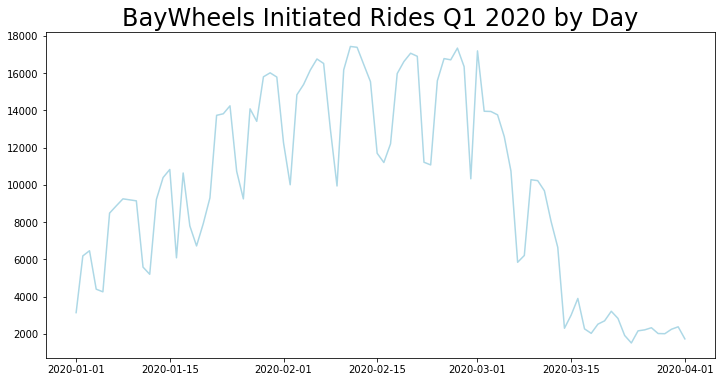

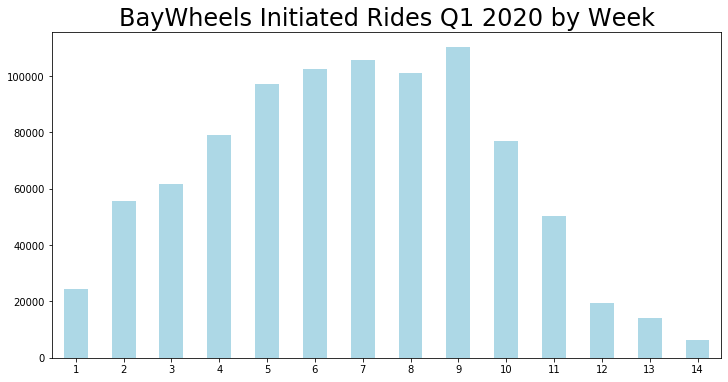

In [179]:
## Rides by Day and Month in Q1

rides_by_day=df['start_date'].value_counts()
fig,ax = plt.subplots(figsize=(12,6))
rides_by_day.plot(ax=ax, color='lightblue')
plt.title('BayWheels Initiated Rides Q1 2020 by Day', fontsize=24, loc='center')

fig.savefig('baywheels_rides_by_day_q1_2020' + '.png', facecolor='white', dpi=150, bbox_inches='tight')

rides_by_week=df['start_time'].dt.week.value_counts().sort_index()
fig,ax = plt.subplots(figsize=(12,6))
rides_by_week_figure=rides_by_week.plot(ax=ax, kind='bar', color='lightblue')
plt.title('BayWheels Initiated Rides Q1 2020 by Week', fontsize=24, loc='center')
plt.xticks(rotation=0)

# Same pattern for casual vs annual

fig.savefig('baywheels_rides_by_week_q1_2020' + '.png', facecolor='white', dpi=150, bbox_inches='tight')
        

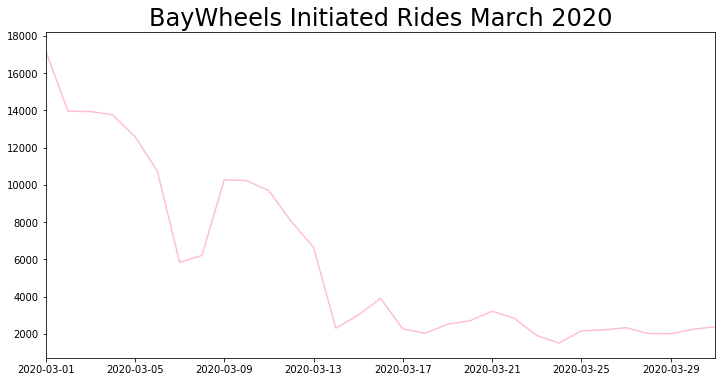

In [180]:
## Rides by day in March?
fig,ax = plt.subplots(figsize=(12,6))
rides_by_day.plot(ax=ax,kind='line', xlim= ['3/1/20', '3/31/20'], color='pink')
plt.title('BayWheels Initiated Rides March 2020', fontsize=24, loc='center')

fig.savefig('baywheels_rides_by_day_march_2020' + '.png', facecolor='white', dpi=150, bbox_inches='tight')

### Adding the Shape Files
* Pulled in 3 options - bay area, counties and cities
* Cities map closest to the Bay Wheels footprint, which is centered in SF, Oakland and SJ

In [27]:
bay_area = gpd.read_file('/Users/kailinkoch/Downloads/ark28722-s7hs4j-shapefile/s7hs4j.shp')

In [28]:
bay_area_counties = gpd.read_file('/Users/kailinkoch/Downloads/ark28722-s7hs4j-shapefile (1)/s7hs4j.shp')

In [29]:
bay_area_cities = gpd.read_file('/Users/kailinkoch/Downloads/stanford-vj593xs7263-shapefile/vj593xs7263.shp')

In [181]:
bay_area_zips = gpd.read_file('/Users/kailinkoch/Downloads/ark28722-s7888q-shapefile/s7888q.shp')

In [182]:
bay_area_zips

ZIP    PO_NAME STATE        Area__       Length__  \
0    94558       NAPA    CA  1.231326e+10  995176.225313   
1    95620      DIXON    CA  7.236950e+09  441860.201400   
2    95476     SONOMA    CA  3.001414e+09  311318.546326   
3    94559       NAPA    CA  1.194302e+09  359104.646602   
4    94533  FAIRFIELD    CA  9.917861e+08  200772.556587   
..     ...        ...   ...           ...            ...   
182  94022  LOS ALTOS    CA  4.211365e+08  137369.776481   
183  94085  SUNNYVALE    CA  9.054792e+07   47415.860456   
184  94086  SUNNYVALE    CA  1.289431e+08   65560.361543   
185  94024  LOS ALTOS    CA  2.966973e+08  136286.642980   
186  94087  SUNNYVALE    CA  1.843369e+08   74339.948036   

                                              geometry  
0    POLYGON ((-122.10329 38.51328, -122.10348 38.5...  
1    POLYGON ((-121.65336 38.31339, -121.69340 38.3...  
2    POLYGON ((-122.40684 38.15568, -122.40757 38.1...  
3    POLYGON ((-122.29369 38.15524, -122.29850 38.1...  
4    POLYGON ((-121.94748 38.30151, -121.94718 38.2...  
..                                                 ...  
182  POLYGON ((-122.09598 37.38605, -122.09707 37.3...  
183  POLYGON ((-121.98689 37.38866, -121.98688 37.3...  
184  POLYGON ((-122.06000 37.37530, -122.05835 37.3...  
185  POLYGON ((-122.09598 37.38605, -122.09599 37.3...  
186  POLYGON ((-122.06240 37.35929, -122.06240 37.3...  

[187 rows x 6 columns]

In [238]:
#fig,ax = plt.subplots(figsize=(15,15))
#bay_area_counties.plot(ax=ax)
#bay_area_counties[bay_area_counties[bay_area_counties.COUNTY] == True].plot(ax=ax)
dir(df['start_date'])

['T',
 '_AXIS_ALIASES',
 '_AXIS_IALIASES',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__

In [183]:
#fig,ax = plt.subplots(figsize=(15,15))
#bay_area.plot(ax=ax)
bay_area_zips.ZIP

0      94558
1      95620
2      95476
3      94559
4      94533
       ...  
182    94022
183    94085
184    94086
185    94024
186    94087
Name: ZIP, Length: 187, dtype: object

### Creating the GeoDataFrame

In [247]:
geometry = [Point(xy) for xy in zip(df["start_station_longitude"], df["start_station_latitude"])]

In [289]:
## Get all the data ready for the chart

geo_df = gpd.GeoDataFrame(df,
                          crs='EPSG:4326', ## CRS matches shape file (bay_area.crs)
                         geometry=geometry)
geo_df.head()
geo_df

duration_sec              start_time                  end_time  \
0              83118 2020-01-31 15:23:47.733  2020-02-01 14:29:06.2630   
1              68239 2020-01-31 15:40:31.616  2020-02-01 10:37:51.0000   
2              55407 2020-01-31 17:48:16.635  2020-02-01 09:11:44.3170   
3              54929 2020-01-31 17:53:03.413  2020-02-01 09:08:32.6340   
4              55700 2020-01-31 17:12:33.460  2020-02-01 08:40:53.6460   
...              ...                     ...                       ...   
905002            61 2020-04-01 10:42:35.000       2020-04-01 10:43:37   
905003            78 2020-03-18 17:10:42.000       2020-03-18 17:12:01   
905004           122 2020-04-01 13:32:28.000       2020-04-01 13:34:31   
905005           340 2020-04-01 13:07:34.000       2020-04-01 13:13:14   
905006           333 2020-03-23 16:39:57.000       2020-03-23 16:45:30   

        start_station_id             start_station_name  \
0                  400.0  Buchanan St at North Point St   
1                   99.0           Folsom St at 15th St   
2                  197.0    El Embarcadero at Grand Ave   
3                  197.0    El Embarcadero at Grand Ave   
4                   12.0    Pier 1/2 at The Embarcadero   
...                  ...                            ...   
905002               NaN                            NaN   
905003               NaN                            NaN   
905004               NaN                            NaN   
905005               NaN                            NaN   
905006               NaN                            NaN   

        start_station_latitude  start_station_longitude  end_station_id  \
0                    37.804272              -122.433537           400.0   
1                    37.767037              -122.415443            99.0   
2                    37.808848              -122.249680           197.0   
3                    37.808848              -122.249680           197.0   
4                    37.796389              -122.394586           371.0   
...                        ...                      ...             ...   
905002                     NaN                      NaN             NaN   
905003               37.848499              -122.265794             NaN   
905004                     NaN                      NaN             NaN   
905005                     NaN                      NaN             NaN   
905006               37.848625              -122.266660             NaN   

                     end_station_name  end_station_latitude  ...  \
0       Buchanan St at North Point St             37.804272  ...   
1                Folsom St at 15th St             37.767037  ...   
2         El Embarcadero at Grand Ave             37.808848  ...   
3         El Embarcadero at Grand Ave             37.808848  ...   
4          Lombard St at Columbus Ave             37.802746  ...   
...                               ...                   ...  ...   
905002                            NaN             37.848476  ...   
905003                            NaN             37.848477  ...   
905004                            NaN             37.848485  ...   
905005                            NaN             37.848497  ...   
905006                            NaN             37.848446  ...   

                user_type  rental_access_method start_week_day start_week  \
0            casual_rider                   NaN       datetime          5   
1       annual_subscriber                   NaN       datetime          5   
2            casual_rider                   NaN       datetime          5   
3            casual_rider                   NaN       datetime          5   
4            casual_rider                   NaN       datetime          5   
...                   ...                   ...            ...        ...   
905002  annual_subscriber                   app       datetime         14   
905003  annual_subscriber                   app       datetime         12   

In [290]:
geo_df_with_zips = gpd.sjoin(geo_df, bay_area_zips, how='inner', op ='within')
geo_df_with_zips

duration_sec              start_time                  end_time  \
0              83118 2020-01-31 15:23:47.733  2020-02-01 14:29:06.2630   
82              1059 2020-01-31 22:29:25.352  2020-01-31 22:47:05.0520   
744              428 2020-01-31 18:40:53.047  2020-01-31 18:48:02.0070   
879              919 2020-01-31 18:14:09.657  2020-01-31 18:29:29.3780   
977             1885 2020-01-31 17:47:13.976  2020-01-31 18:18:39.6650   
...              ...                     ...                       ...   
904975          2035 2020-03-01 15:36:28.000       2020-03-01 16:10:23   
904991          5650 2020-03-22 17:09:35.000       2020-03-22 18:43:46   
808889           328 2020-03-16 17:08:20.000       2020-03-16 17:13:49   
808890           878 2020-03-28 18:04:14.000       2020-03-28 18:18:53   
808891           154 2020-03-16 17:23:52.000       2020-03-16 17:26:27   

        start_station_id             start_station_name  \
0                  400.0  Buchanan St at North Point St   
82                 400.0  Buchanan St at North Point St   
744                400.0  Buchanan St at North Point St   
879                478.0    Greenwich St at Franklin St   
977                399.0          Bay St at Fillmore St   
...                  ...                            ...   
904975               NaN                            NaN   
904991               NaN                            NaN   
808889               NaN                            NaN   
808890               NaN                            NaN   
808891               NaN                            NaN   

        start_station_latitude  start_station_longitude  end_station_id  \
0                    37.804272              -122.433537           400.0   
82                   37.804272              -122.433537            15.0   
744                  37.804272              -122.433537           441.0   
879                  37.800254              -122.425919           419.0   
977                  37.802636              -122.436289            21.0   
...                        ...                      ...             ...   
904975               37.809100              -122.474939             NaN   
904991               37.809927              -122.476421            12.0   
808889               37.706875              -122.414440             NaN   
808890               37.706876              -122.414365             NaN   
808891               37.707252              -122.415721             NaN   

                                         end_station_name  \
0                           Buchanan St at North Point St   
82      San Francisco Ferry Building (Harry Bridges Pl...   
744                           Chestnut St at Van Ness Ave   
879                                    Fern St at Polk St   
977      Montgomery St BART Station (Market St at 2nd St)   
...                                                   ...   
904975                                                NaN   
904991                        Pier 1/2 at The Embarcadero   
808889                                                NaN   
808890                                                NaN   
808891                                                NaN   

        end_station_latitude  ...                   coordinates_nongeom2  \
0                  37.804272  ...       (-122.4335369468, 37.8042720199)   
82                 37.795392  ...       (-122.4335369468, 37.8042720199)   
744                37.802288  ...       (-122.4335369468, 37.8042720199)   
879                37.788197  ...       (-122.4259194732, 37.8002544308)   
977                37.789625  ...       (-122.4362888932, 37.8026359497)   
...                      ...  ...                                    ...   
904975             37.805173  ...   (-122.47493899999999, 37.8091003333)   
904991             37.796389  ...       (-122.4764211667, 37.8099271667)   
808889             37.707359  ...          (-122.4144405, 37.7068748333)   
808890          

In [291]:
## Get the count of rides by city by day and label it sensically

dfpivot = pd.pivot_table(geo_df_with_zips,index=['ZIP', 'First_day'],values=['bike_id'],aggfunc={'bike_id':'count'})
dfpivot.reset_index(inplace=True)
dfpivot.rename({"bike_id": "count"}, axis='columns', inplace=True)
dfpivot.head()

ZIP   First_day  count
0  94014  2020-03-16      2
1  94014  2020-03-23      1
2  94102  2019-12-30   1481
3  94102  2020-01-06   3097
4  94102  2020-01-13   3593

In [292]:
## Merge the counts back in with the geometric data

geo_df_with_counts = bay_area_zips.merge(dfpivot, how='inner',on='ZIP')
geo_df_with_counts

ZIP   PO_NAME STATE        Area__       Length__  \
0    94710  BERKELEY    CA  7.708996e+07   83425.282245   
1    94710  BERKELEY    CA  7.708996e+07   83425.282245   
2    94710  BERKELEY    CA  7.708996e+07   83425.282245   
3    94710  BERKELEY    CA  7.708996e+07   83425.282245   
4    94710  BERKELEY    CA  7.708996e+07   83425.282245   
..     ...       ...   ...           ...            ...   
566  95134  SAN JOSE    CA  3.108945e+08  121395.240015   
567  95134  SAN JOSE    CA  3.108945e+08  121395.240015   
568  95134  SAN JOSE    CA  3.108945e+08  121395.240015   
569  95134  SAN JOSE    CA  3.108945e+08  121395.240015   
570  95134  SAN JOSE    CA  3.108945e+08  121395.240015   

                                              geometry   First_day  count  
0    POLYGON ((-122.30103 37.84738, -122.30039 37.8...  2019-12-30    151  
1    POLYGON ((-122.30103 37.84738, -122.30039 37.8...  2020-01-06    245  
2    POLYGON ((-122.30103 37.84738, -122.30039 37.8...  2020-01-13    234  
3    POLYGON ((-122.30103 37.84738, -122.30039 37.8...  2020-01-20    281  
4    POLYGON ((-122.30103 37.84738, -122.30039 37.8...  2020-01-27    330  
..                                                 ...         ...    ...  
566  POLYGON ((-121.91520 37.39611, -121.91589 37.3...  2020-03-02     66  
567  POLYGON ((-121.91520 37.39611, -121.91589 37.3...  2020-03-09     48  
568  POLYGON ((-121.91520 37.39611, -121.91589 37.3...  2020-03-16     24  
569  POLYGON ((-121.91520 37.39611, -121.91589 37.3...  2020-03-23     22  
570  POLYGON ((-121.91520 37.39611, -121.91589 37.3...  2020-03-30      8  

[571 rows x 8 columns]

In [296]:
## Test set to play around with loop before creating lots of things and having regrets
geo_df_test_sf = geo_df_with_counts.loc[geo_df_with_counts['PO_NAME']=='SAN FRANCISCO']
geo_df_test_sf.head()

ZIP        PO_NAME STATE        Area__     Length__  \
182  94133  SAN FRANCISCO    CA  2.155245e+07  43114.36236   
183  94133  SAN FRANCISCO    CA  2.155245e+07  43114.36236   
184  94133  SAN FRANCISCO    CA  2.155245e+07  43114.36236   
185  94133  SAN FRANCISCO    CA  2.155245e+07  43114.36236   
186  94133  SAN FRANCISCO    CA  2.155245e+07  43114.36236   

                                              geometry   First_day  count  
182  MULTIPOLYGON (((-122.41920 37.80846, -122.4179...  2019-12-30    502  
183  MULTIPOLYGON (((-122.41920 37.80846, -122.4179...  2020-01-06    999  
184  MULTIPOLYGON (((-122.41920 37.80846, -122.4179...  2020-01-13   1372  
185  MULTIPOLYGON (((-122.41920 37.80846, -122.4179...  2020-01-20   2069  
186  MULTIPOLYGON (((-122.41920 37.80846, -122.4179...  2020-01-27   2489

### Creating Final Visualization

In [303]:
## Function to print the graphs for the final GIF
plt.ioff()

def print_map(x):
    range = x['count']
    norm=matplotlib.colors.Normalize(vmin=range.min(), vmax=range.max())
    for week in x['First_day']:
        geo_df_with_counts_day = x.loc[x['First_day']==week]
        fig,ax=plt.subplots(figsize=(15,15))
        #ax.set(xlim=[-122.75,-121.55], ylim=[37.7,38.0], aspect=1)
        ax.set(xlim=[-122.6,-122.3], ylim=[37.685,37.82], aspect=1)
        bay_area_zips.plot(ax = ax, figsize=(15,15), alpha=0.4, color='lightgrey')
        geo_df_with_counts_day.plot(ax = ax, column='count', norm=norm, cmap='Oranges')
        plt.title('BayWheels Rides Week of '+str(week), fontsize=24, loc='center')
        sm = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
        sm.set_array([])
        plt.colorbar(sm,ax=ax, norm=norm,cmap='Oranges', shrink=0.48)
        fig.savefig(str(week)+'_baywheels_bywk_byzip'+ '.png', facecolor='white', dpi=150, bbox_inches='tight')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


KeyboardInterrupt: 

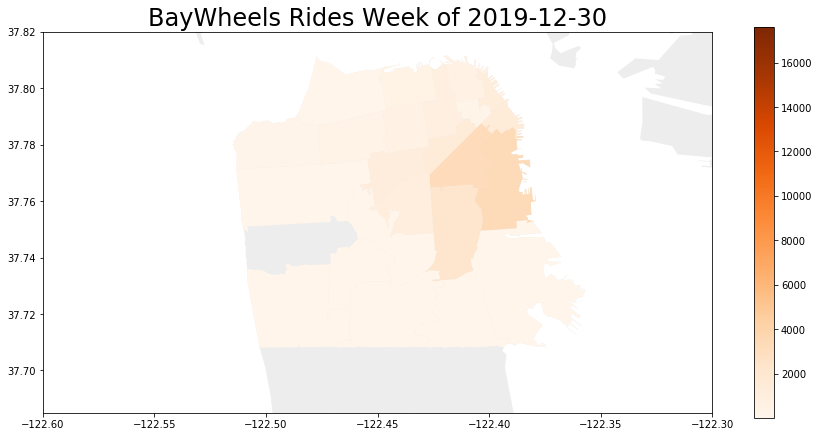

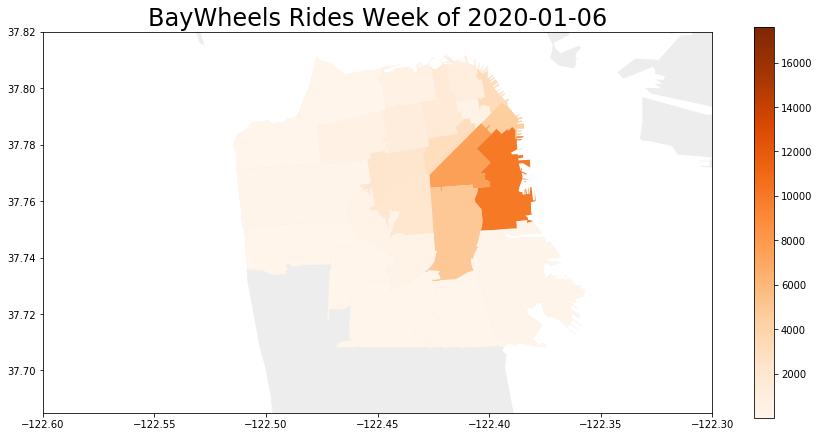

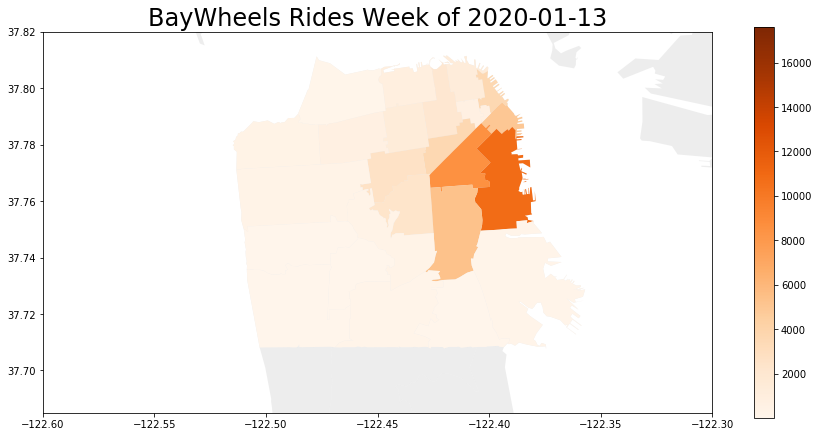

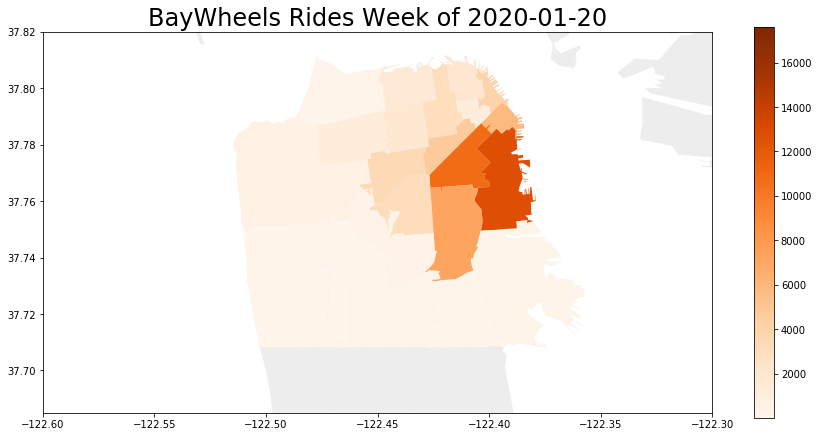

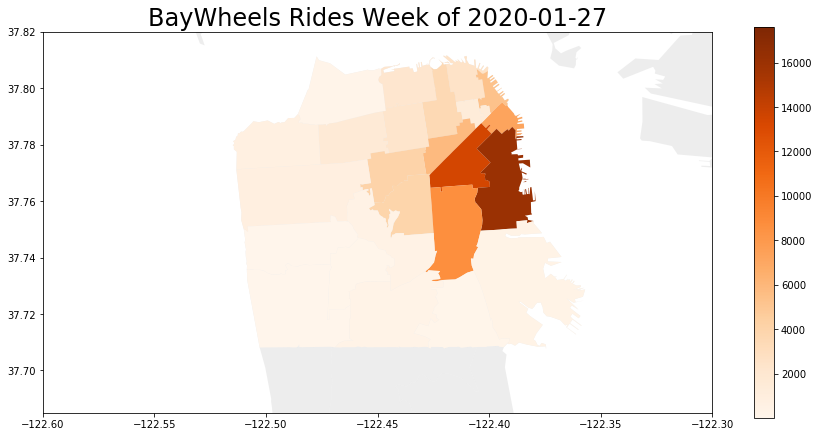

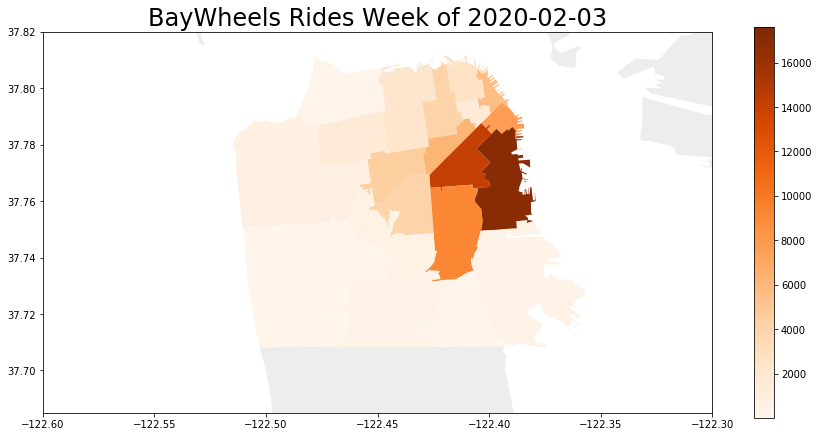

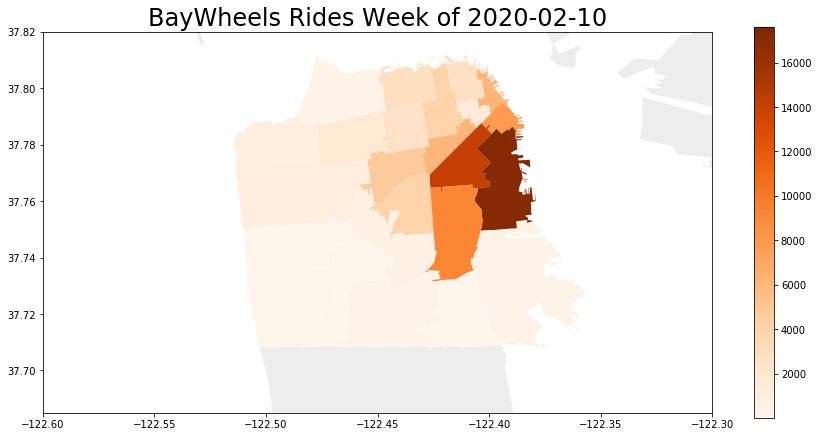

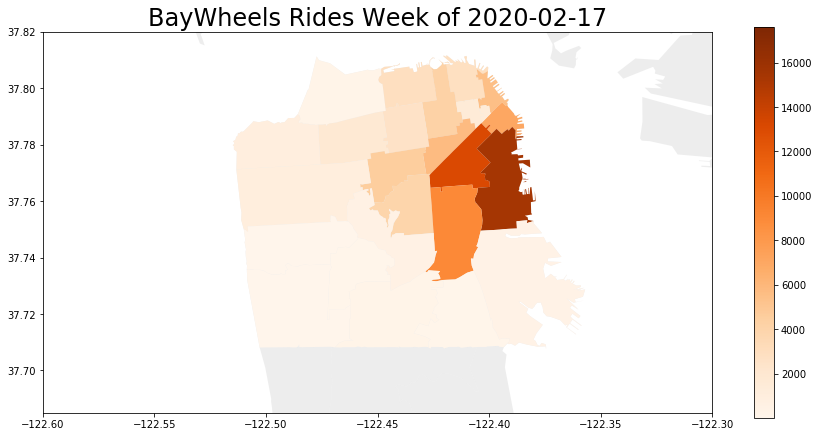

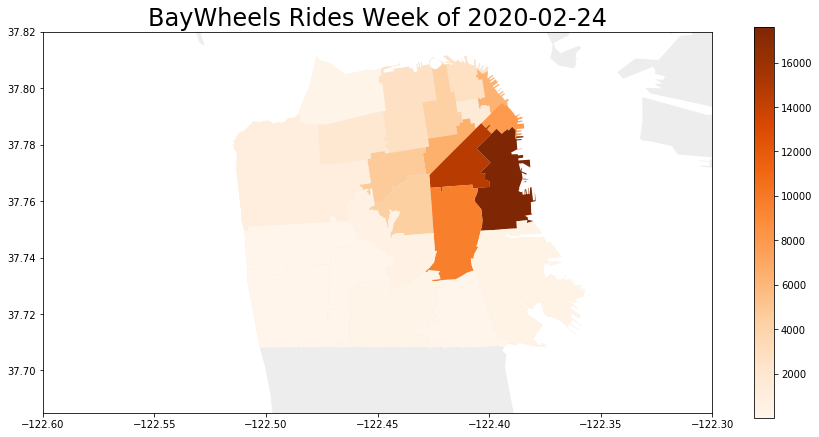

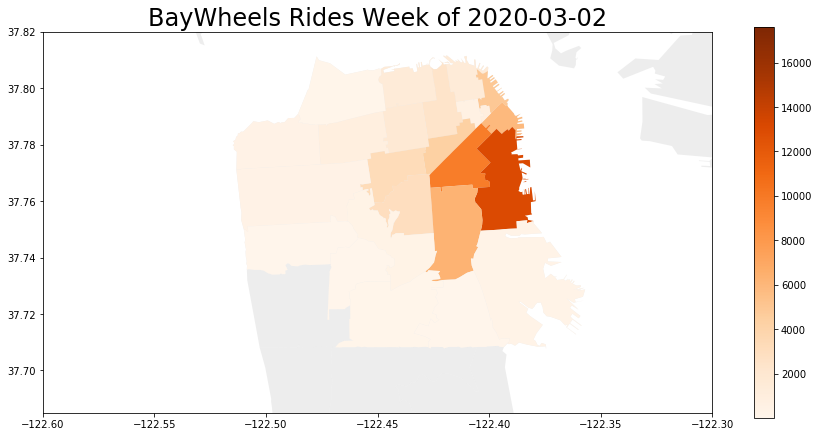

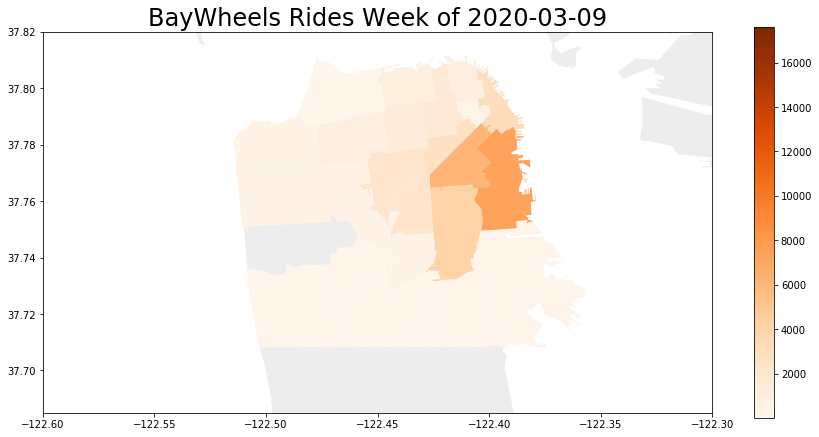

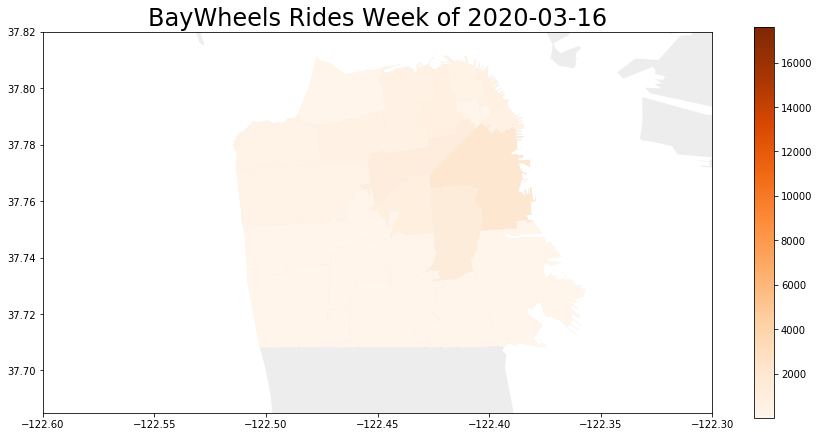

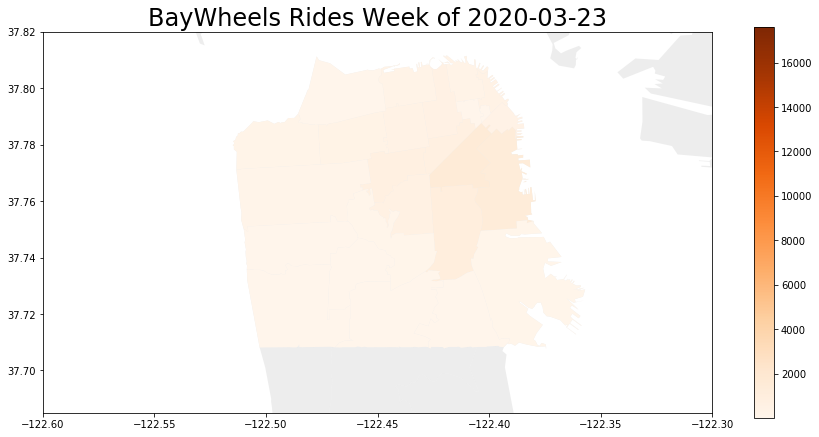

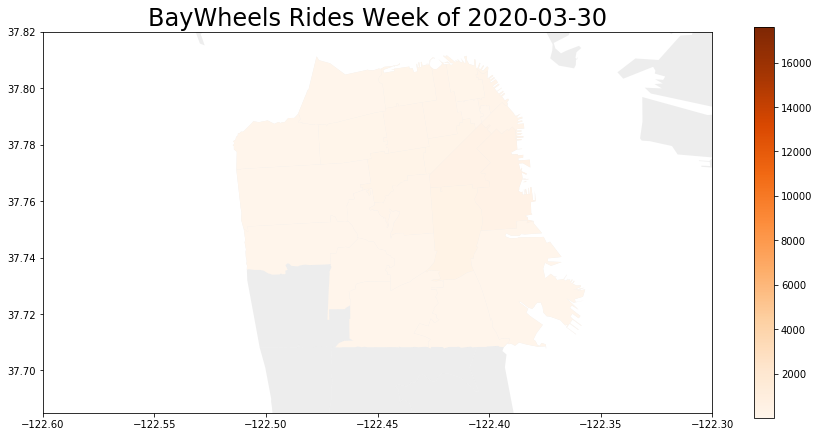

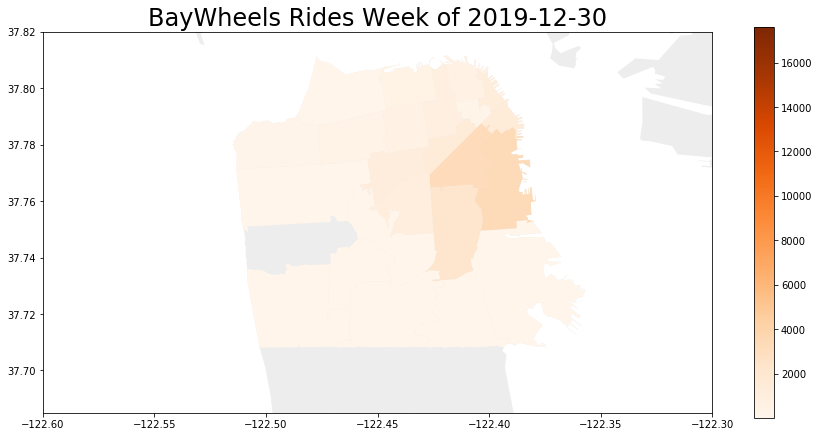

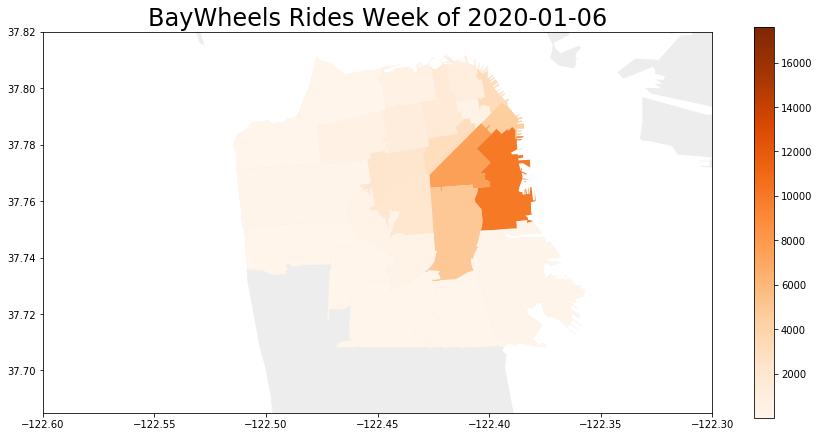

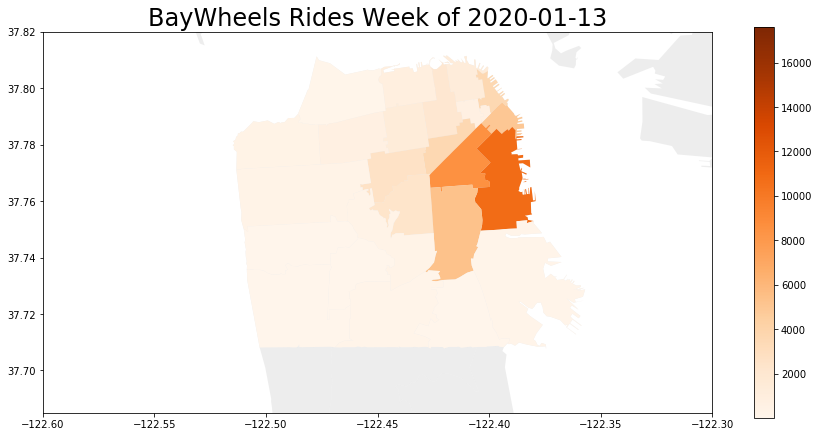

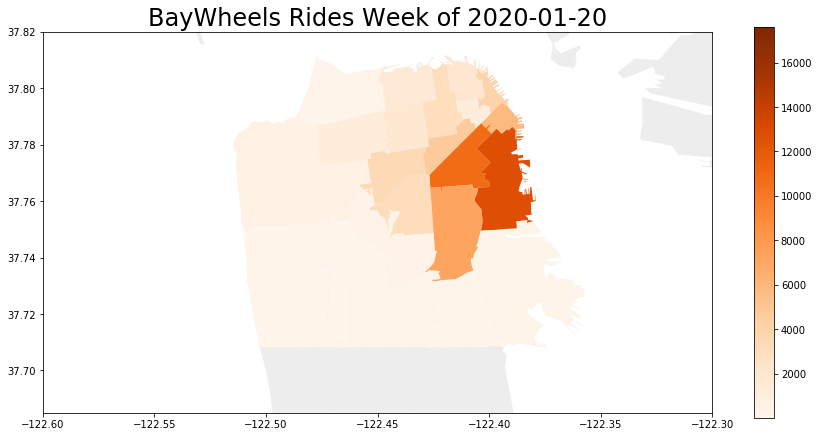

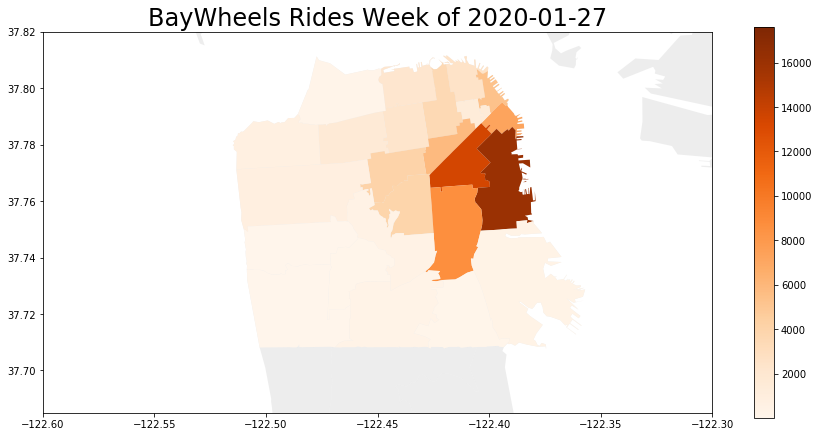

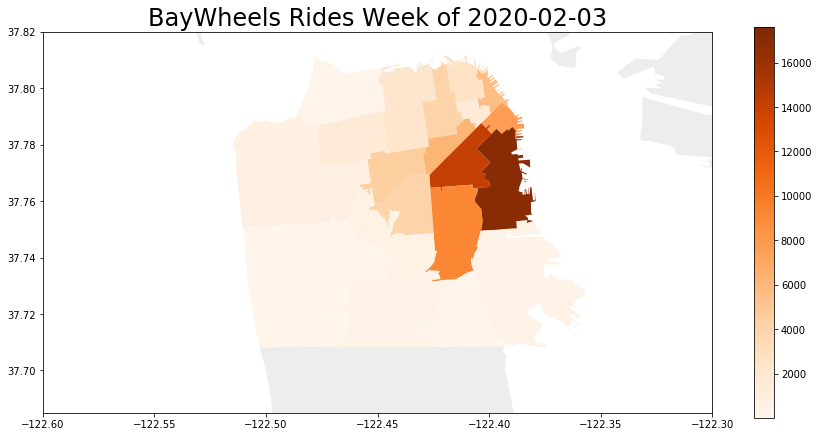

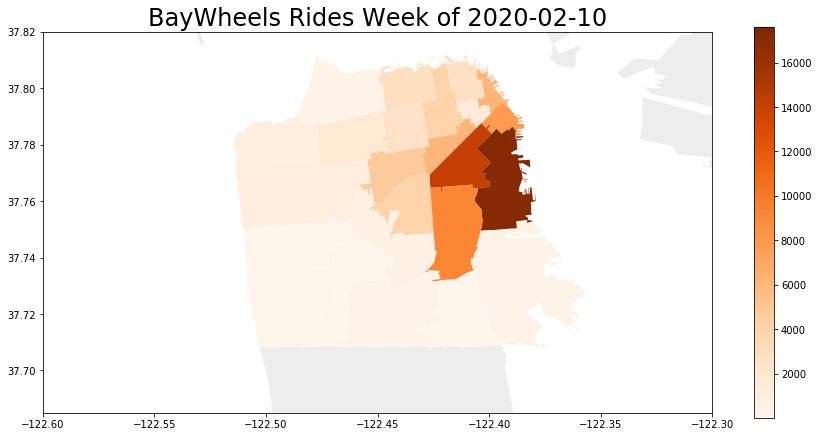

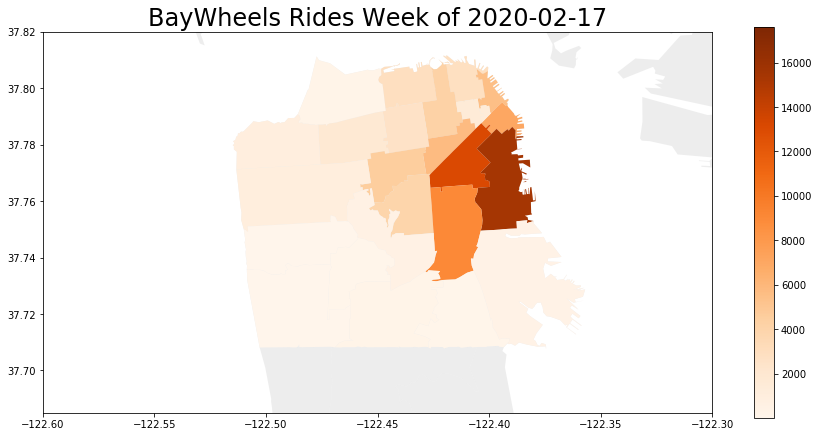

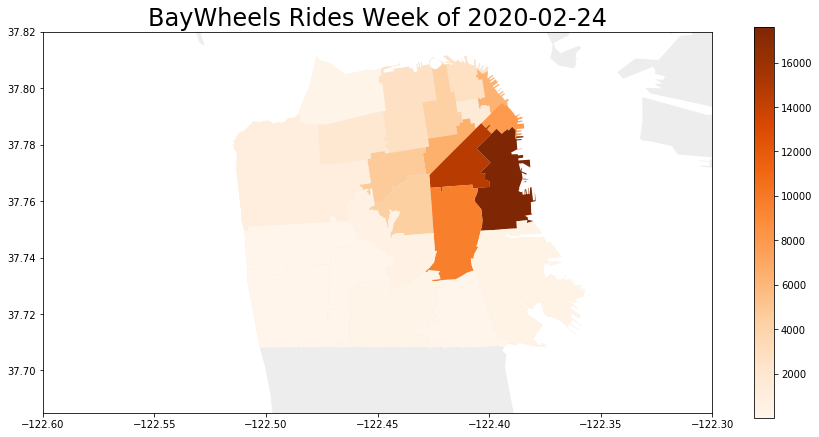

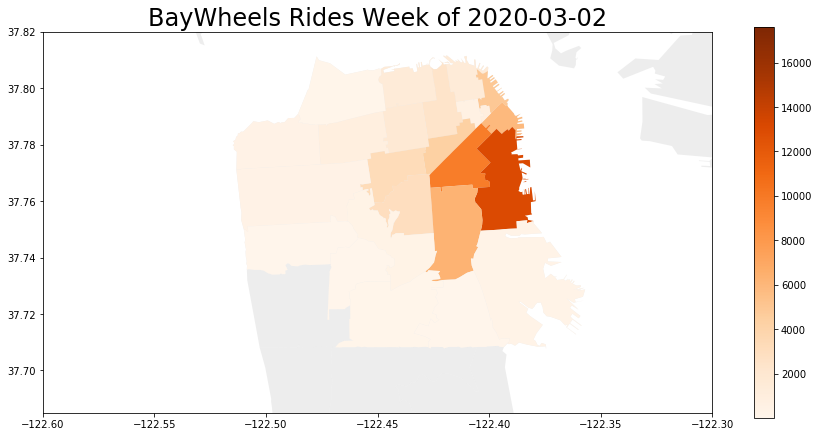

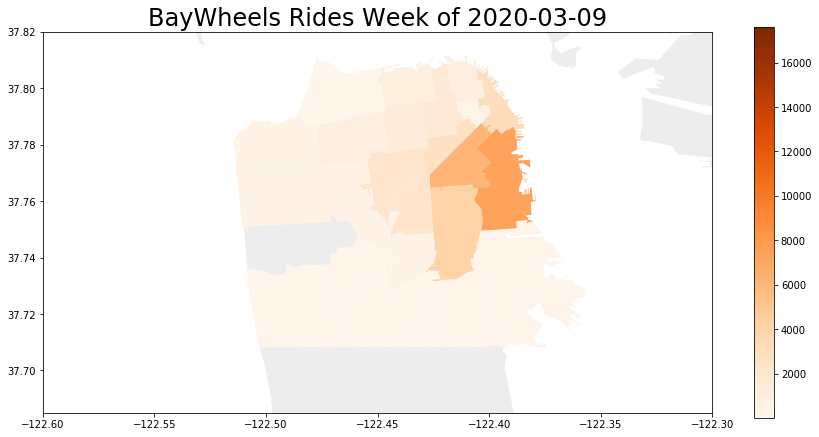

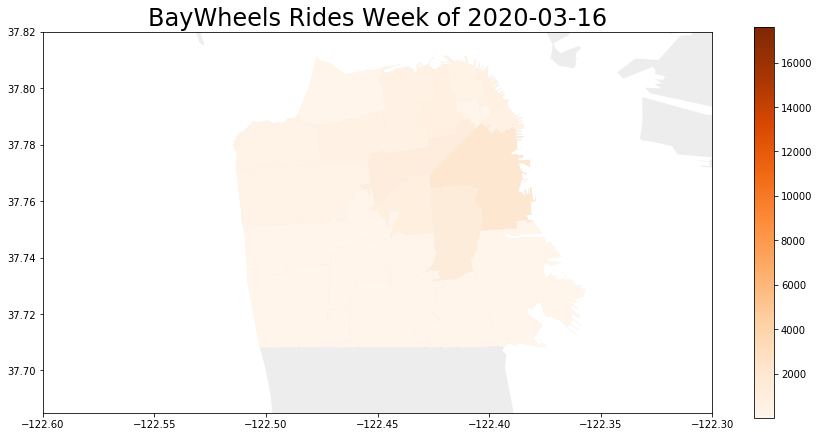

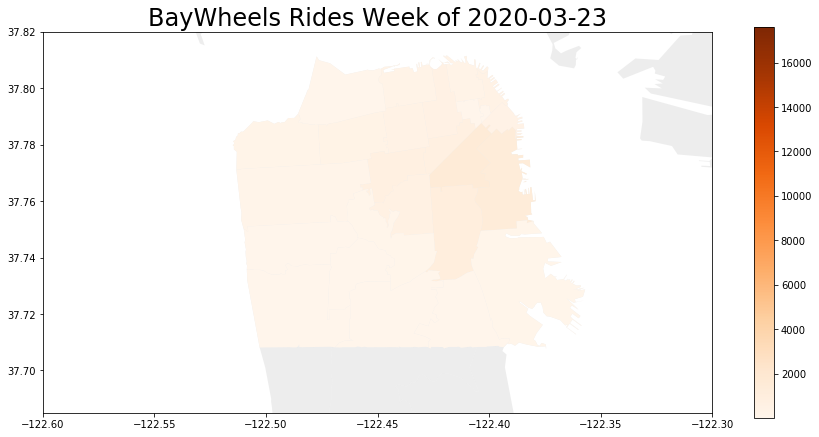

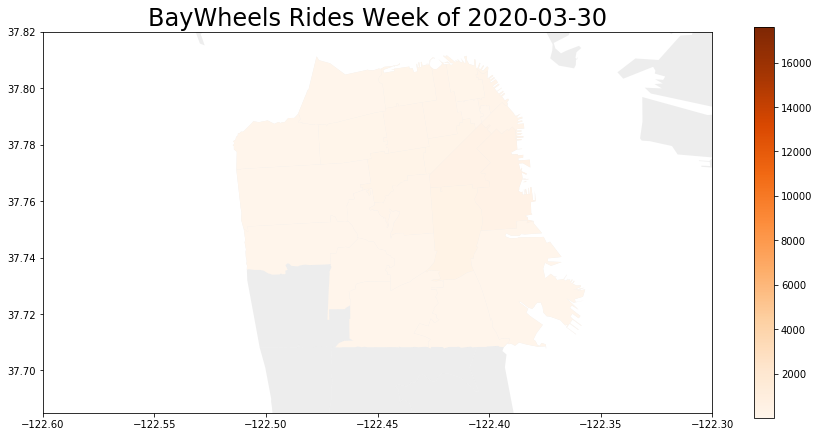

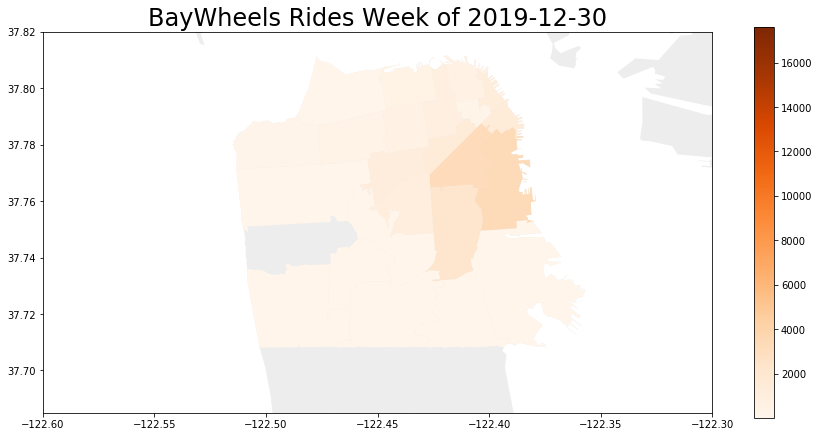

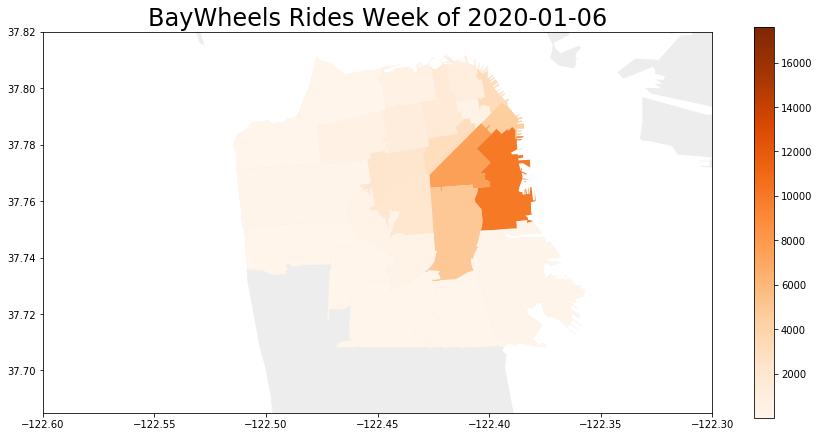

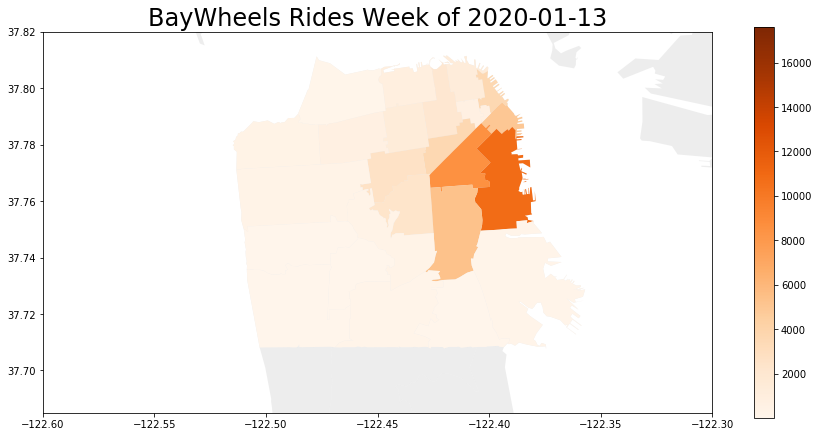

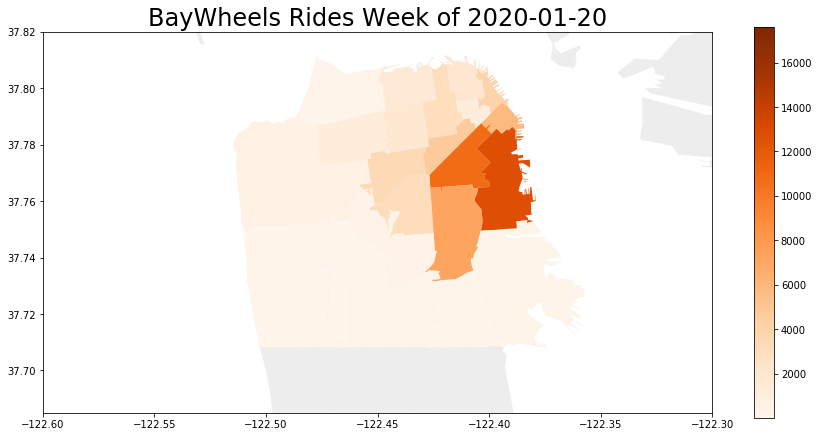

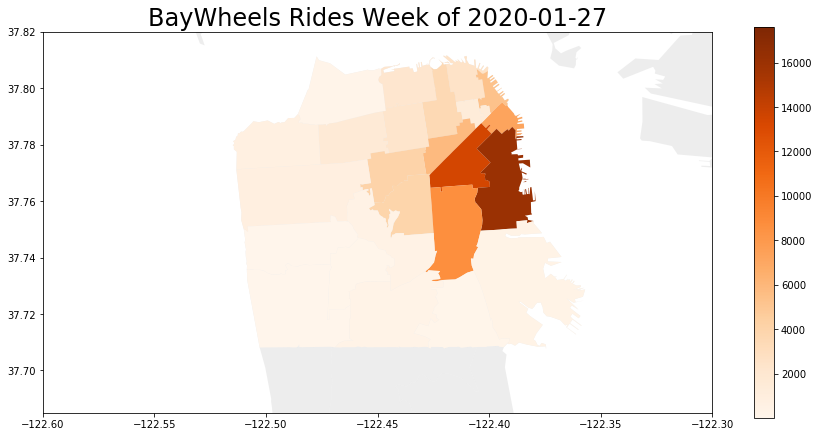

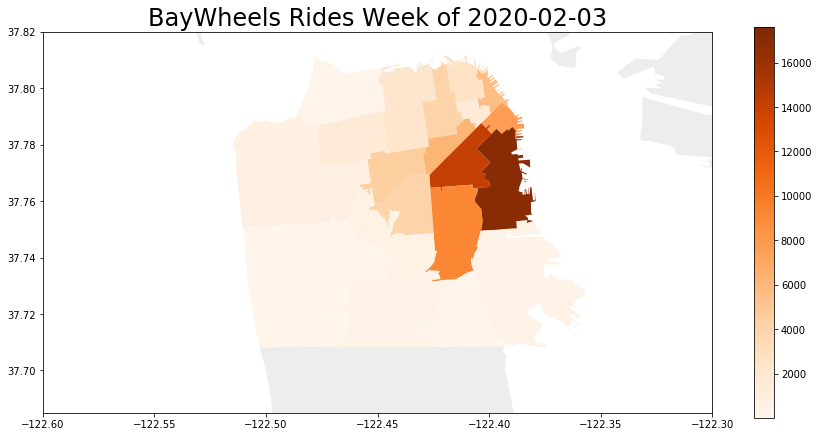

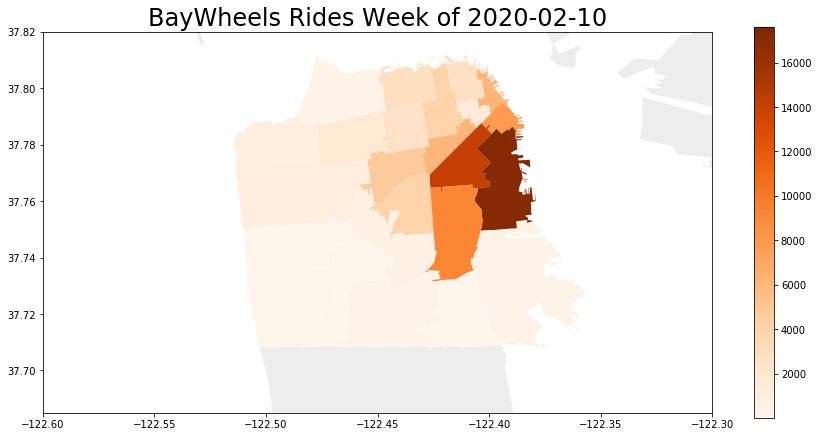

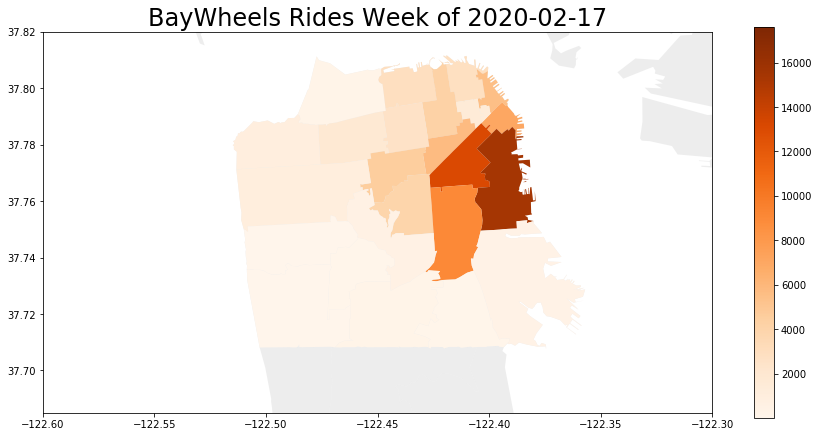

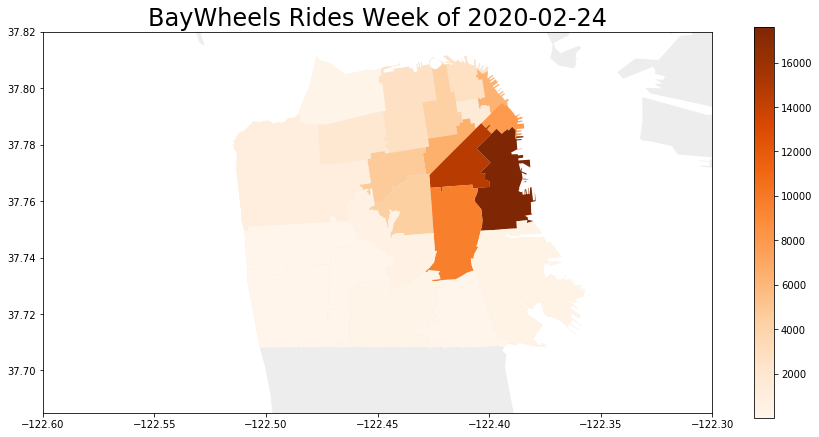

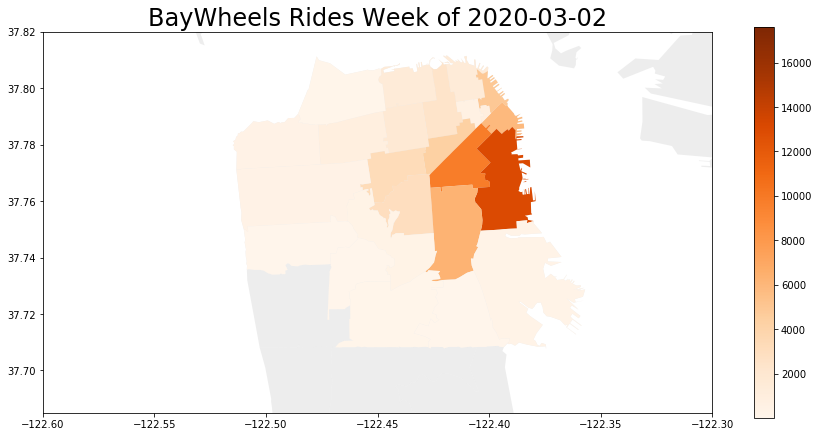

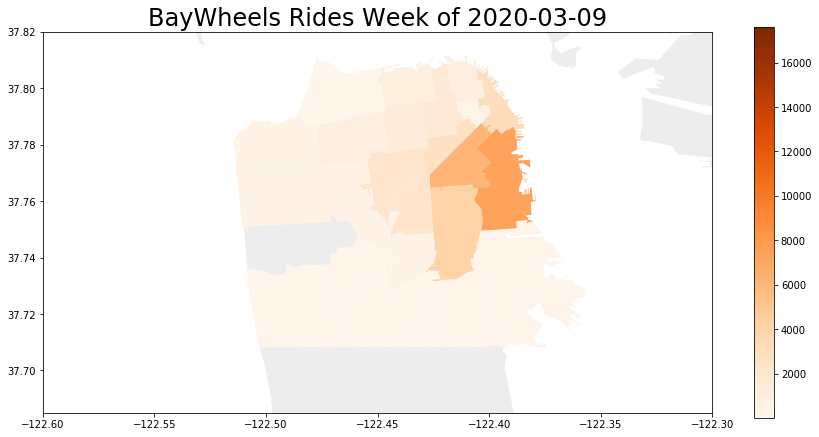

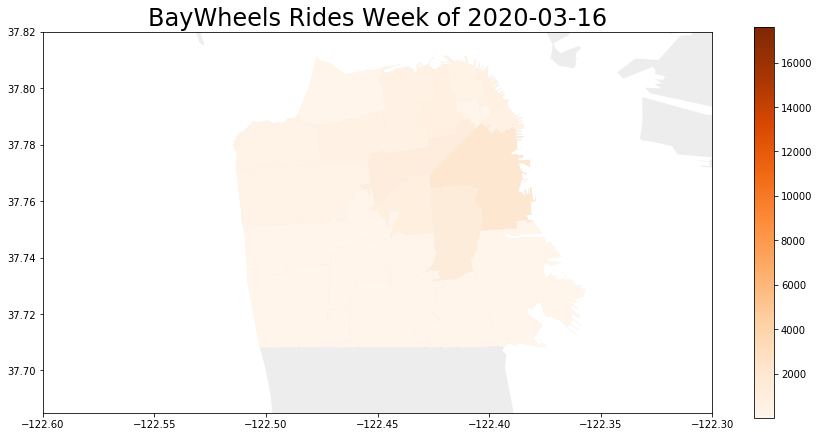

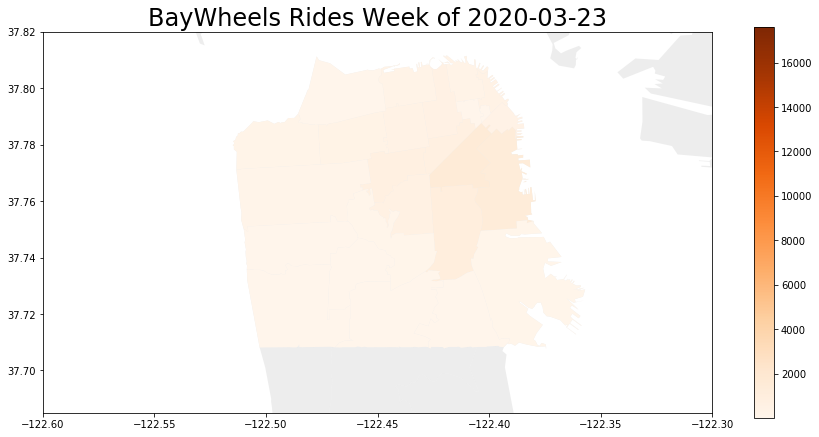

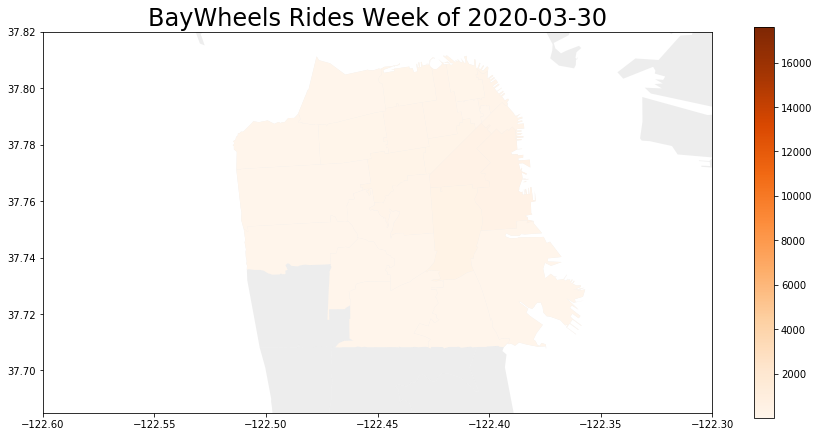

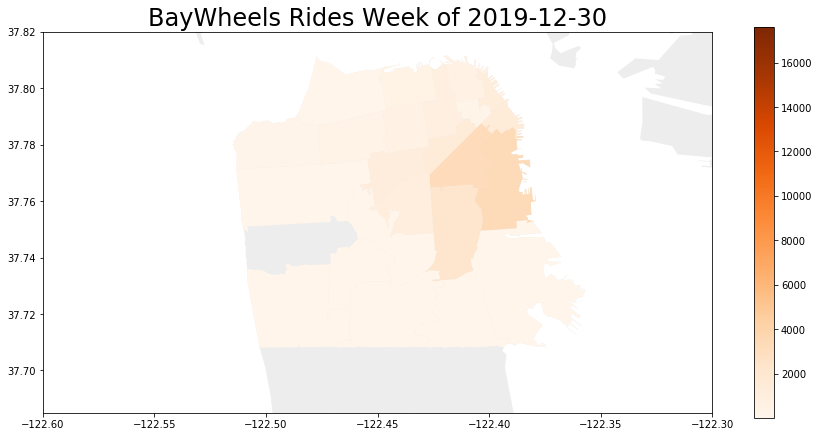

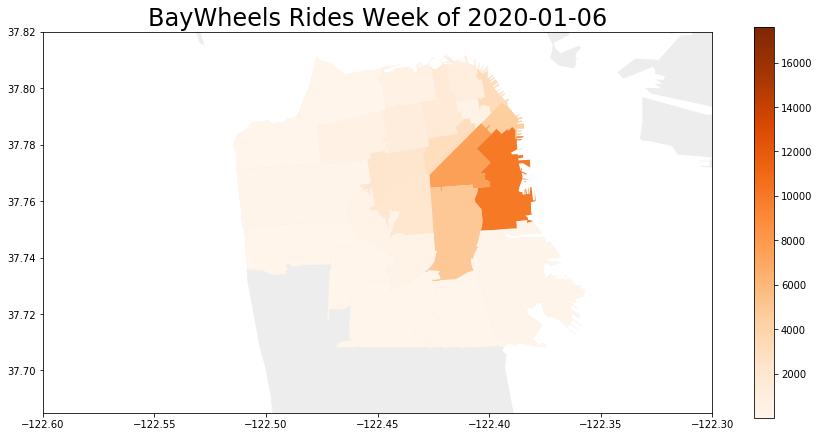

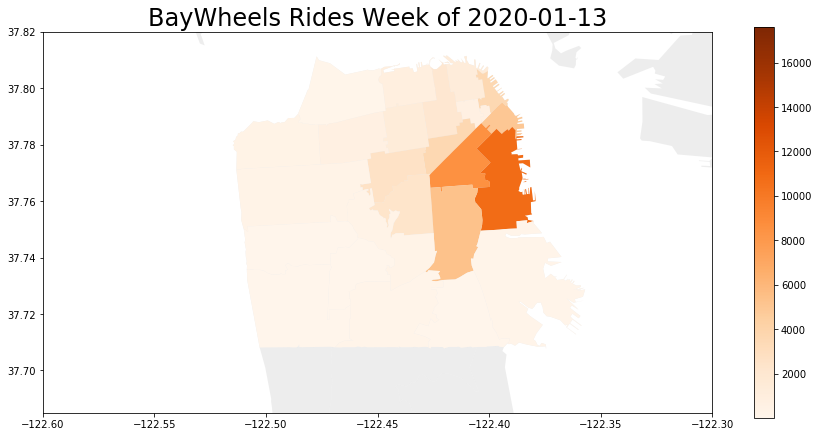

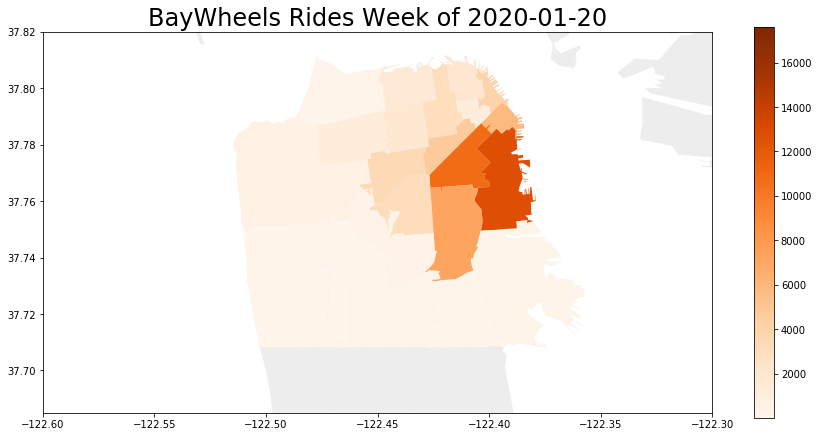

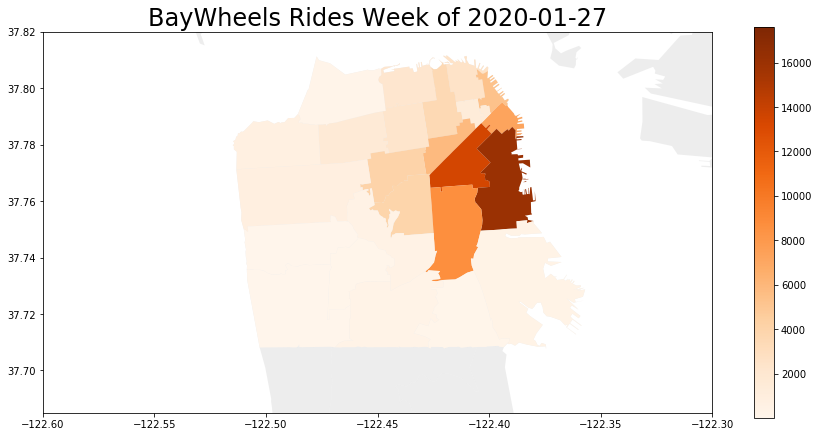

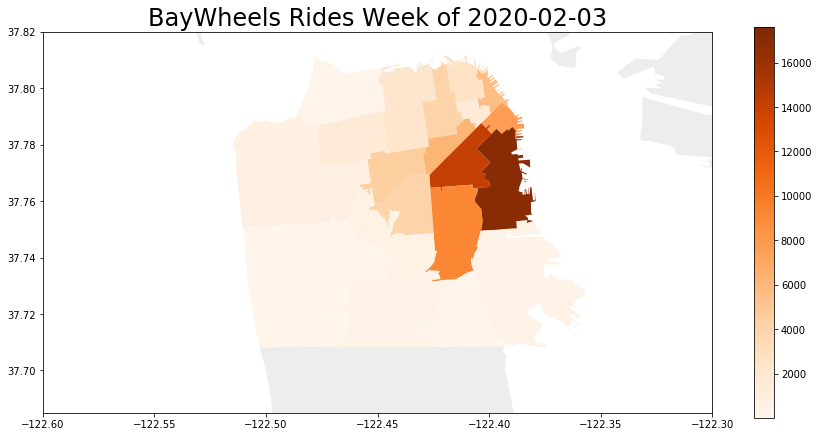

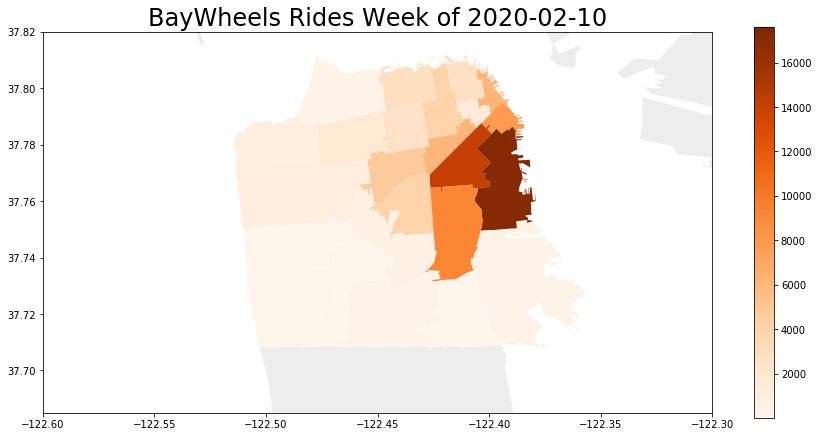

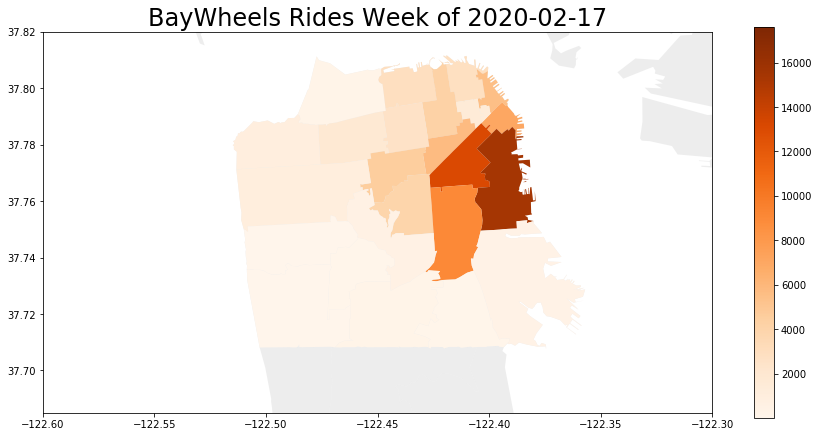

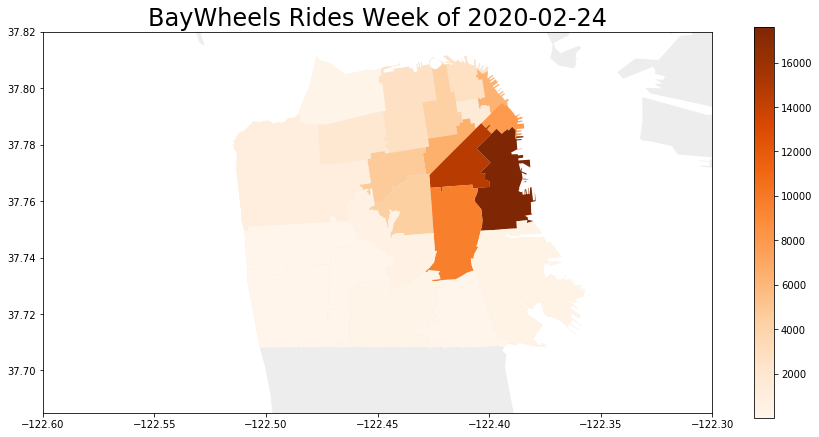

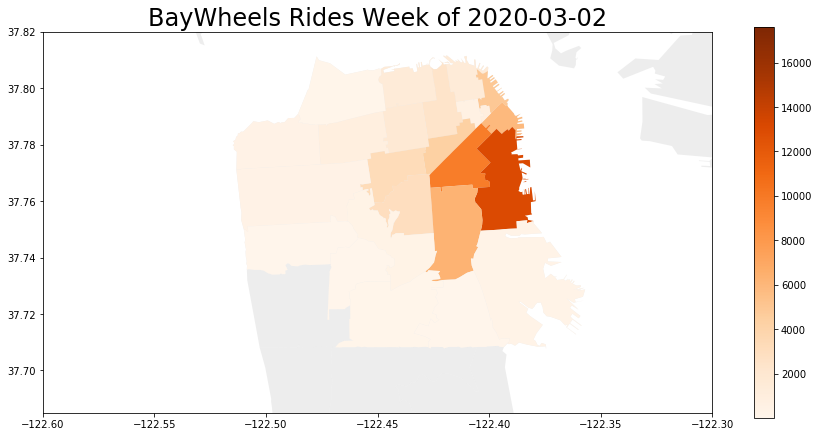

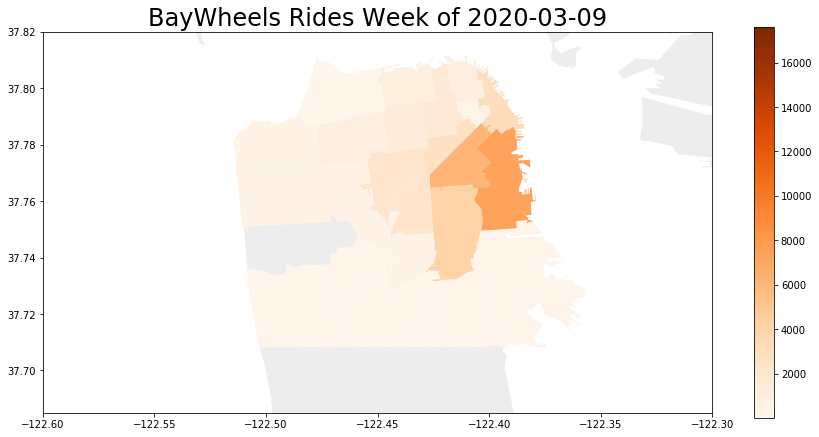

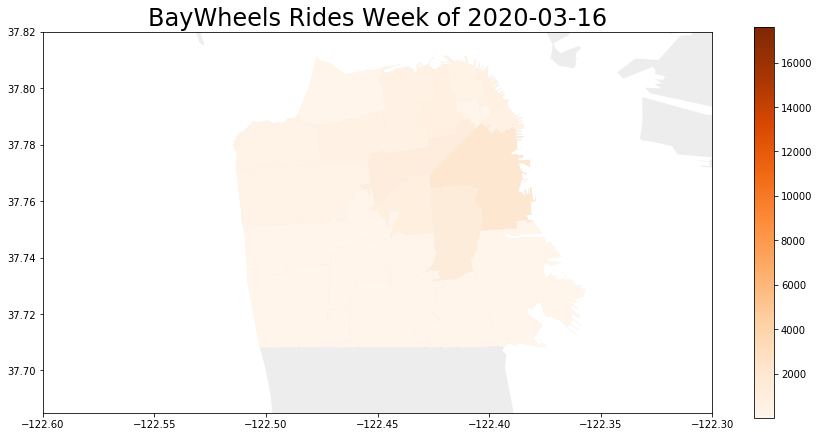

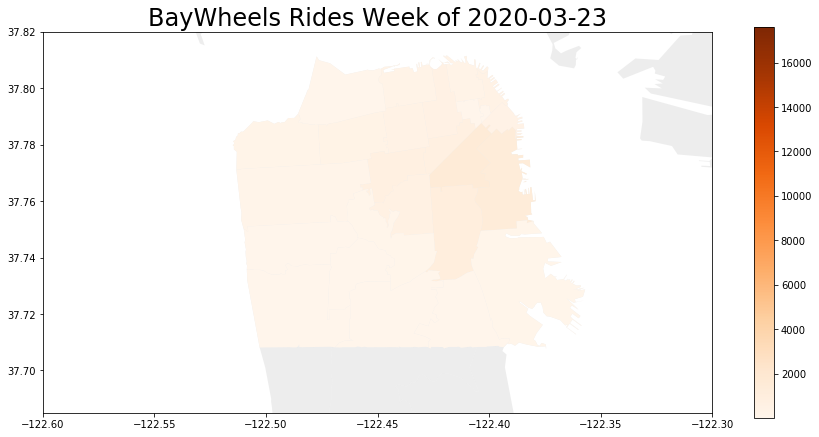

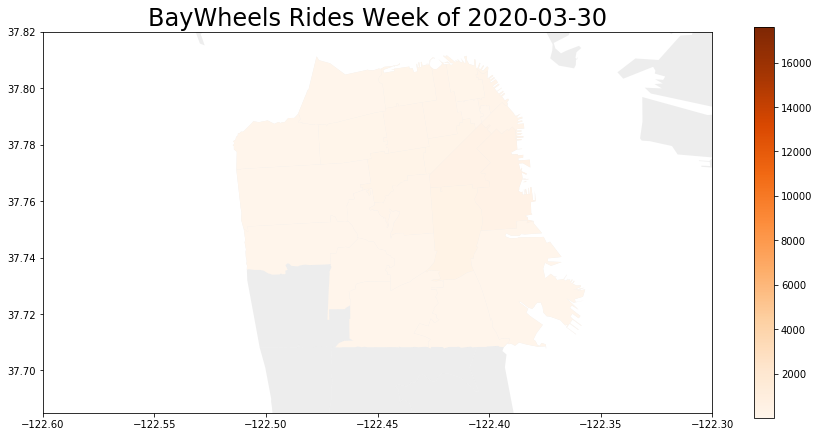

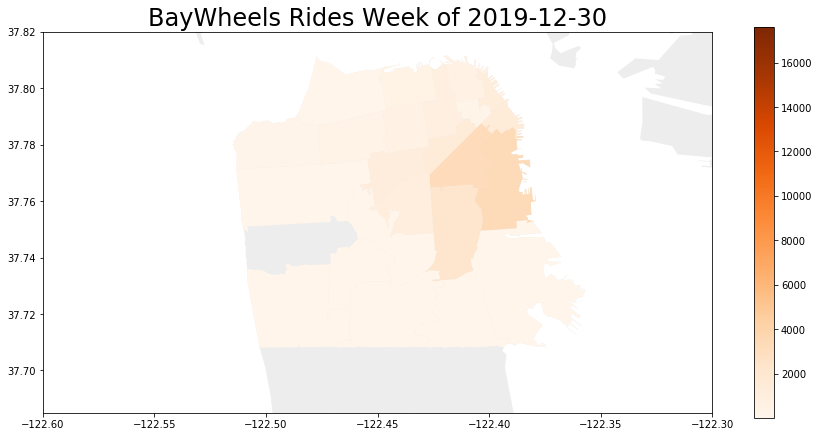

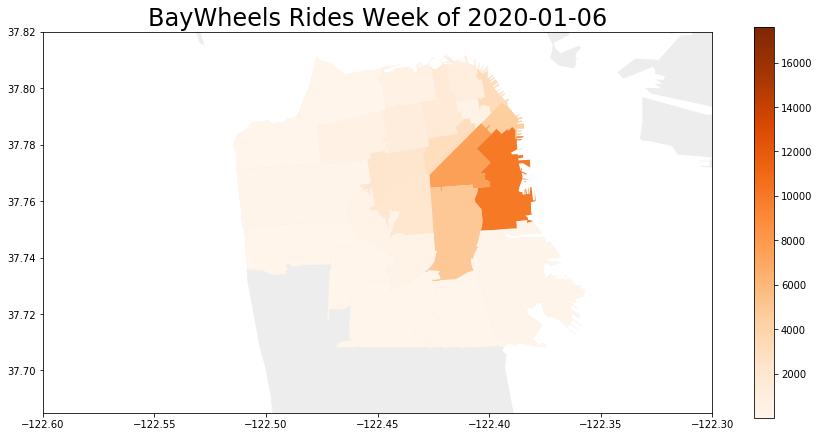

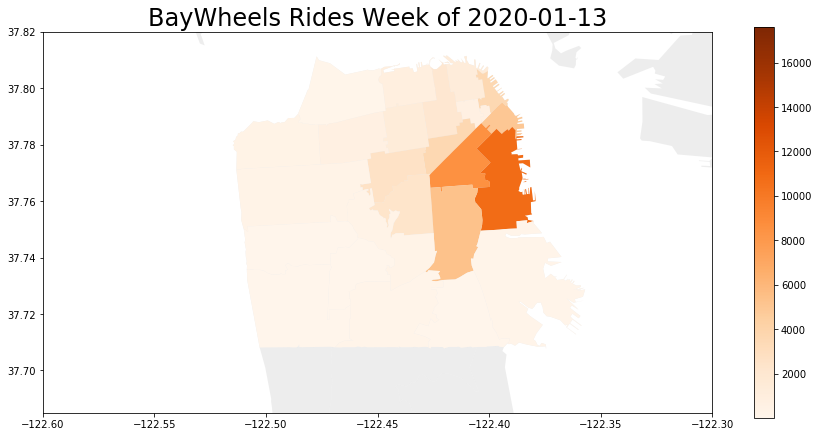

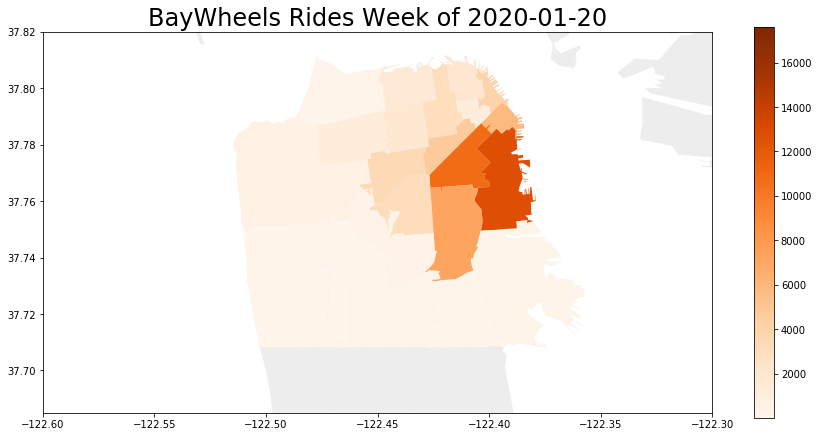

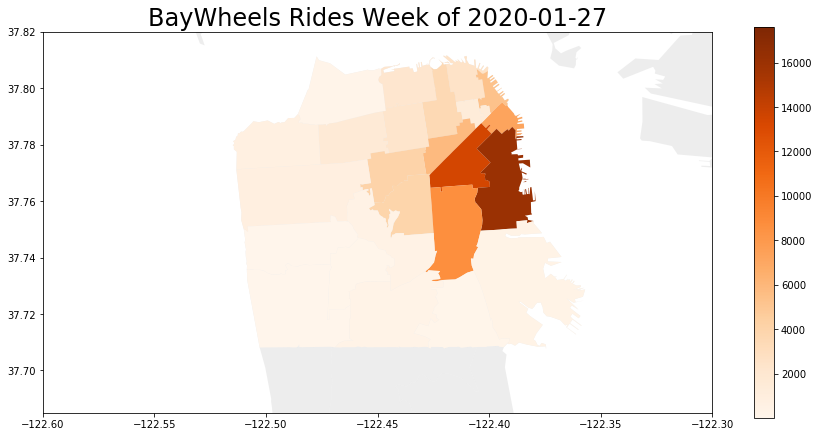

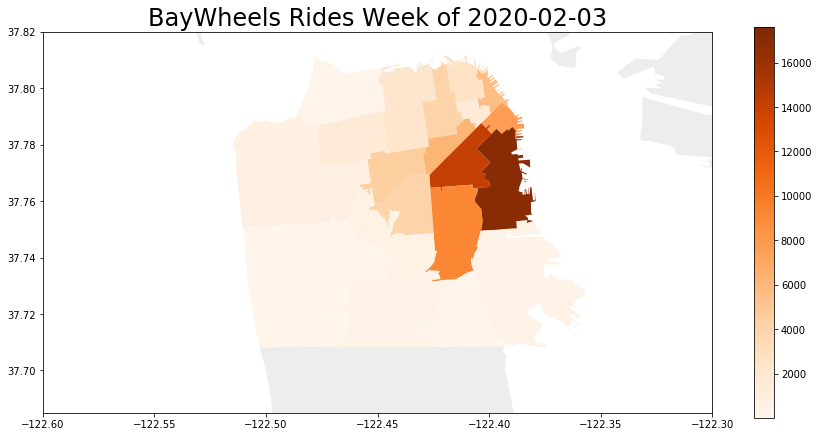

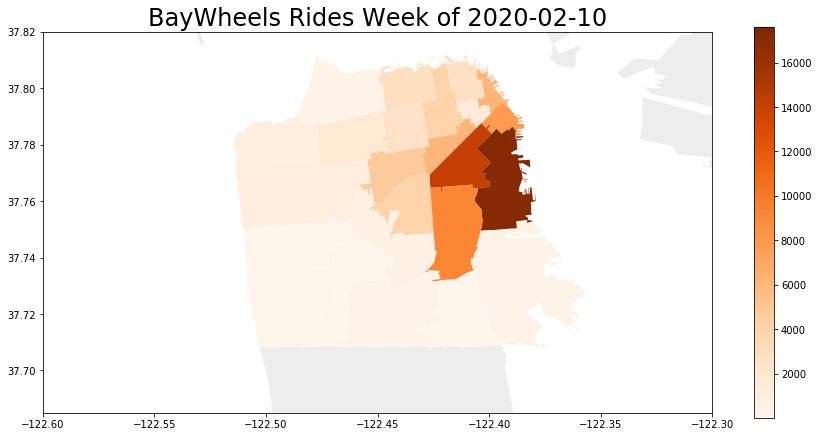

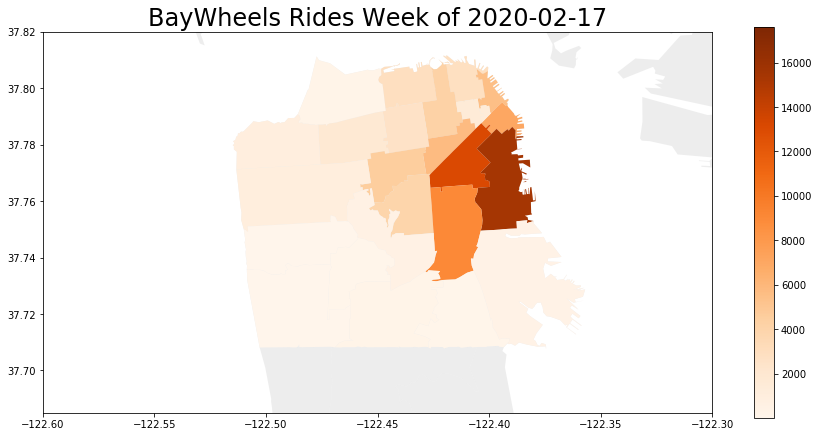

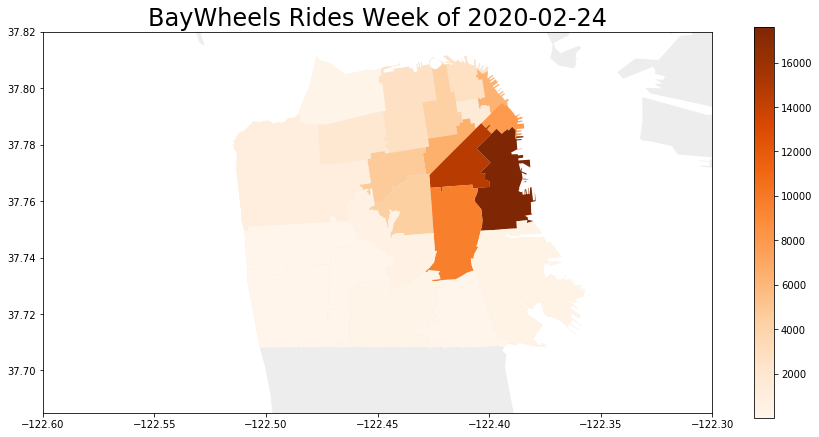

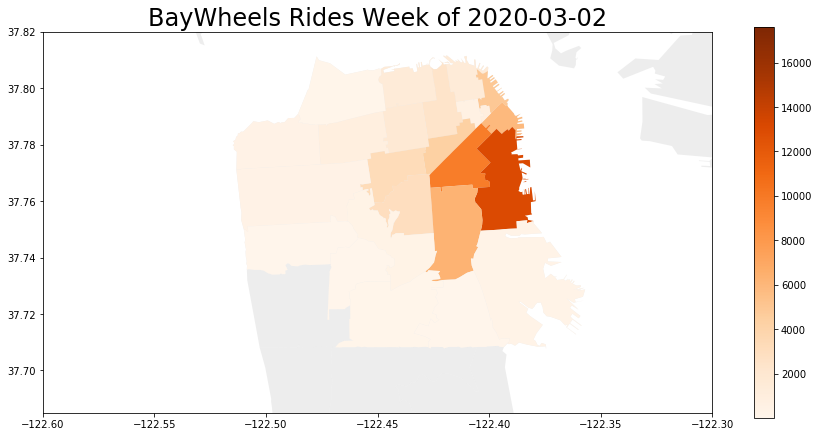

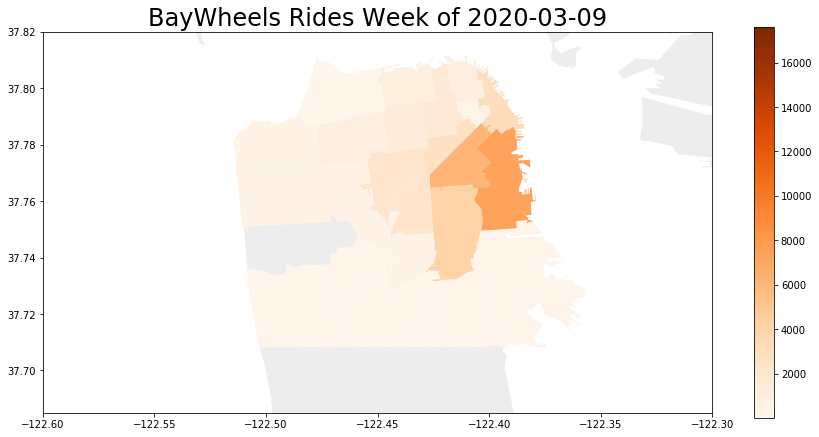

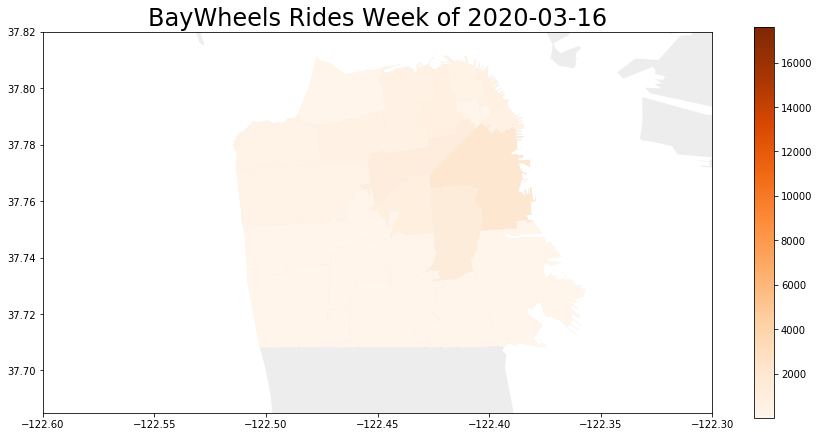

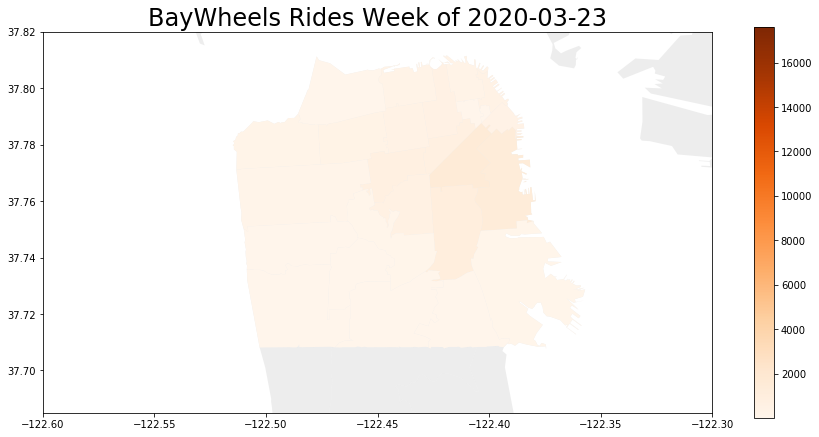

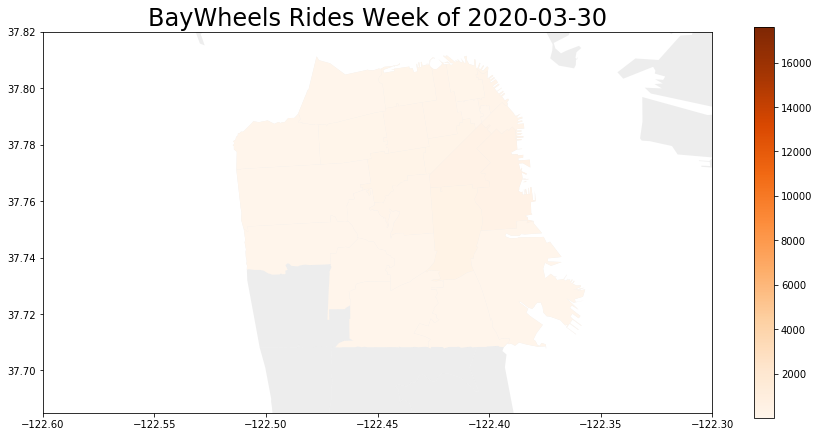

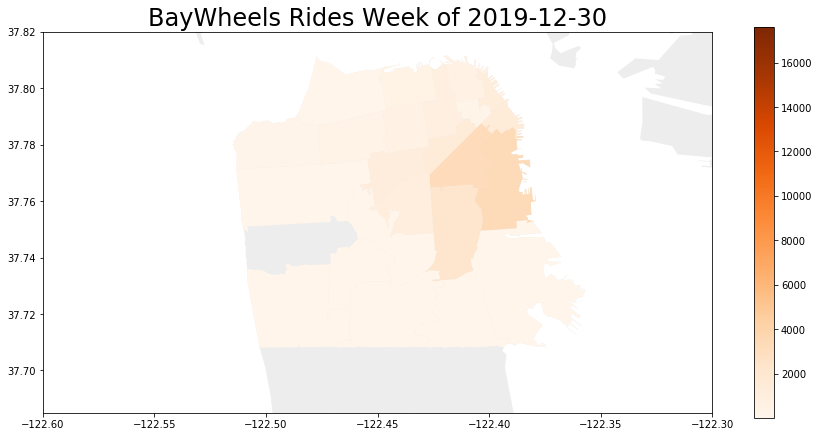

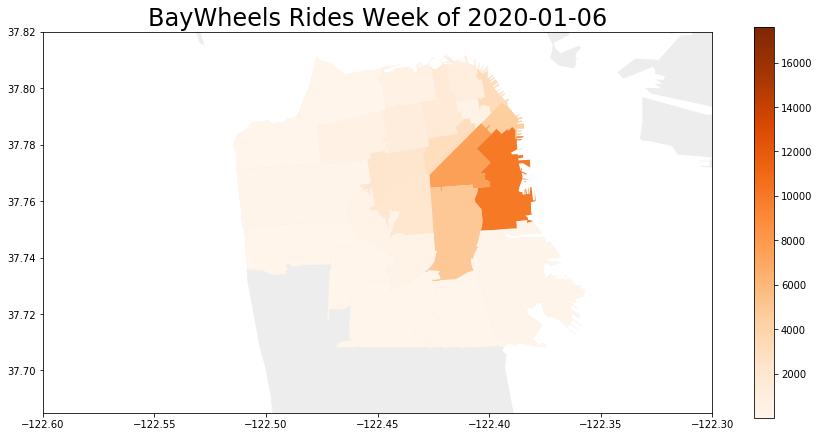

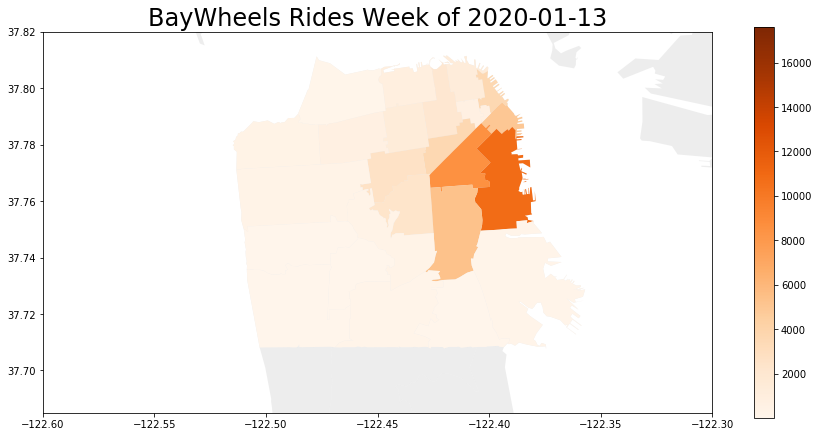

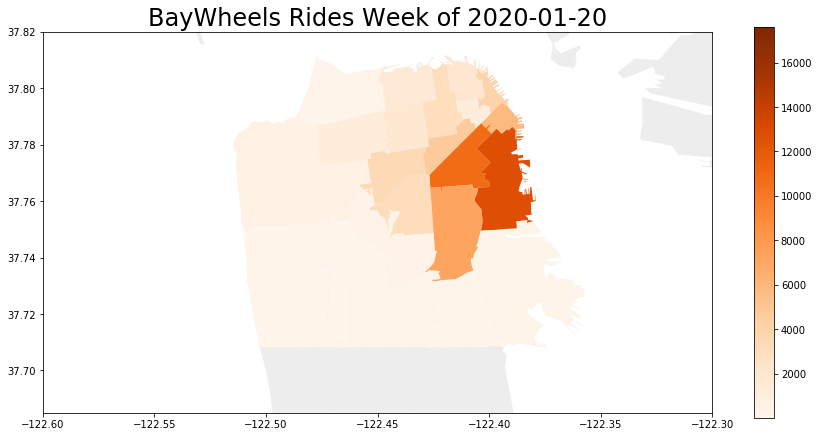

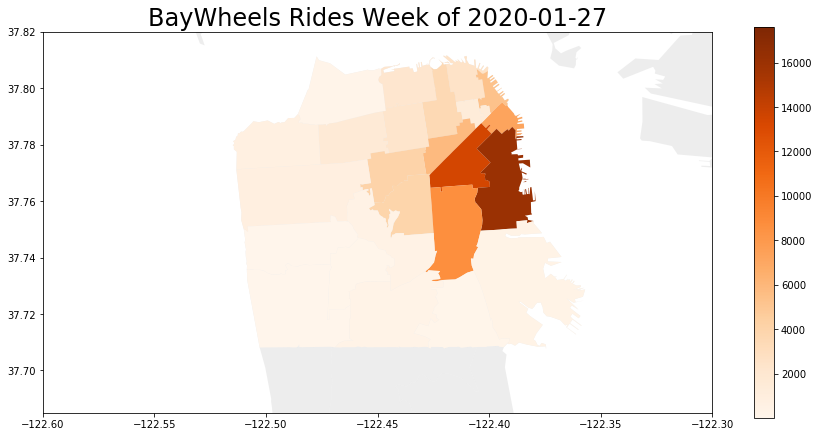

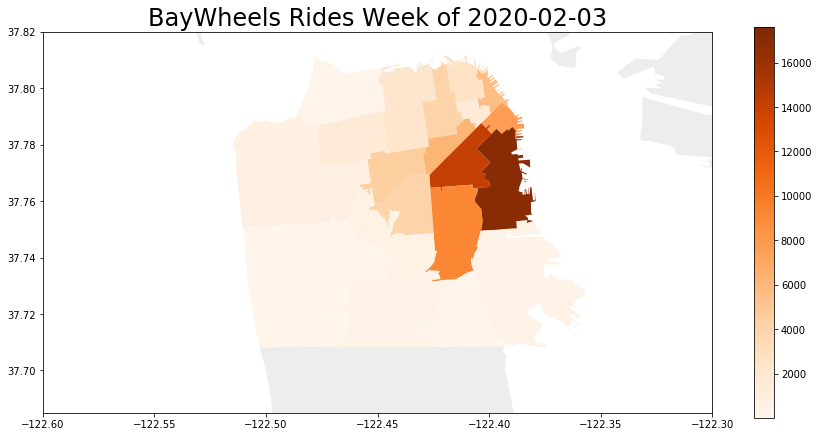

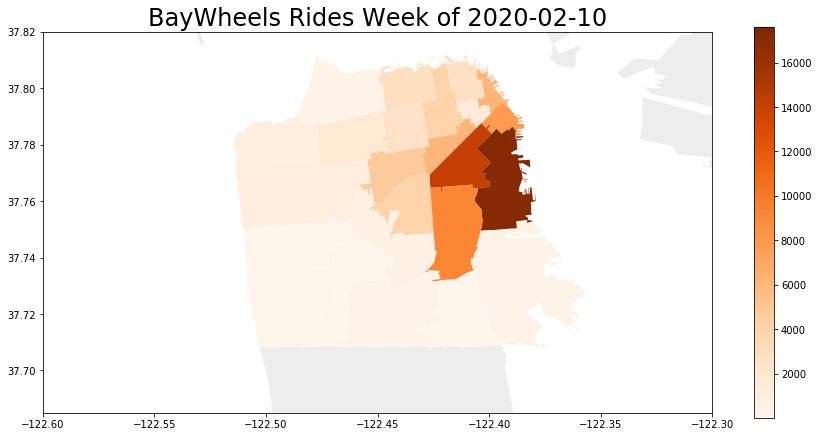

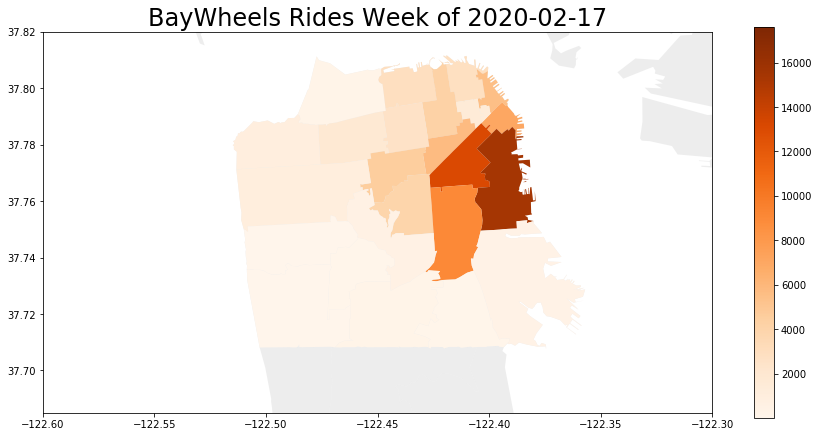

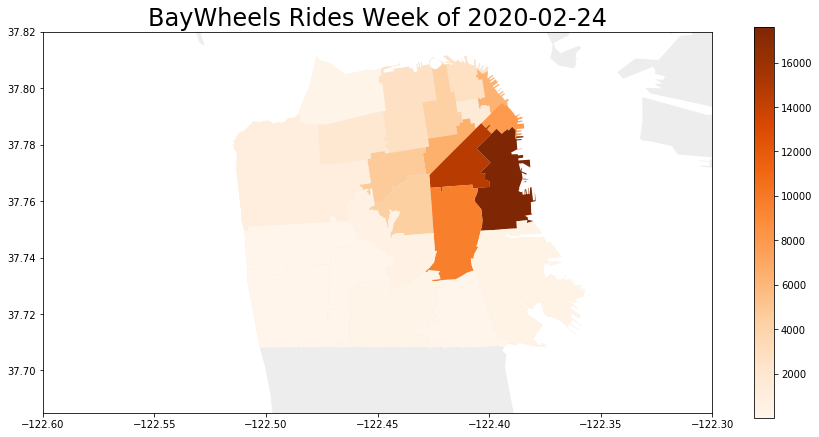

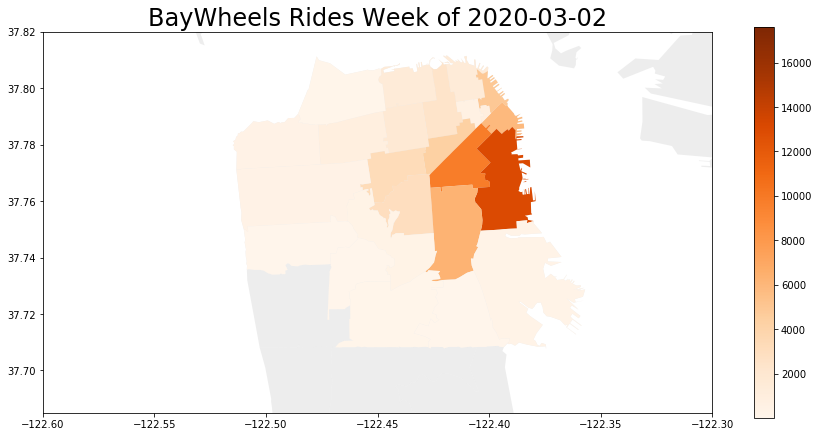

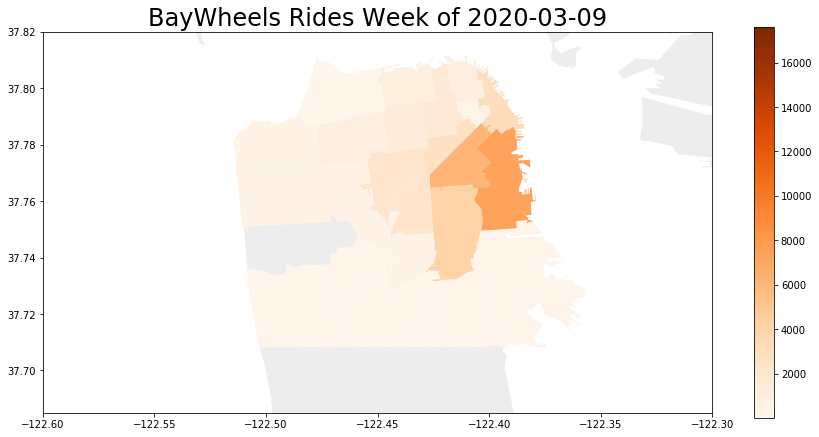

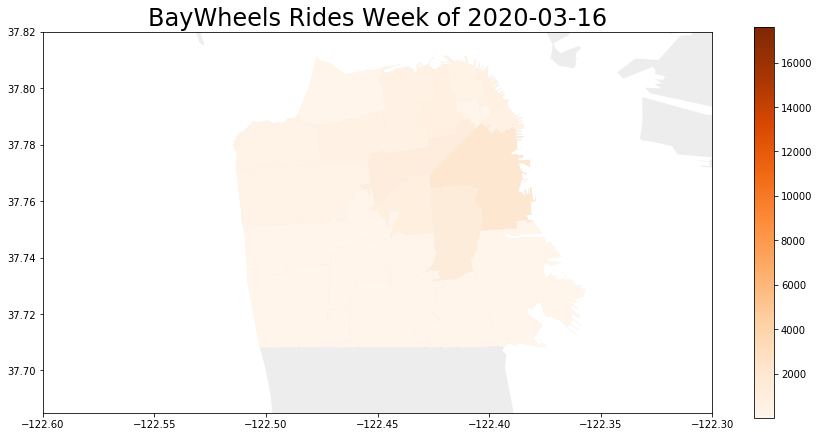

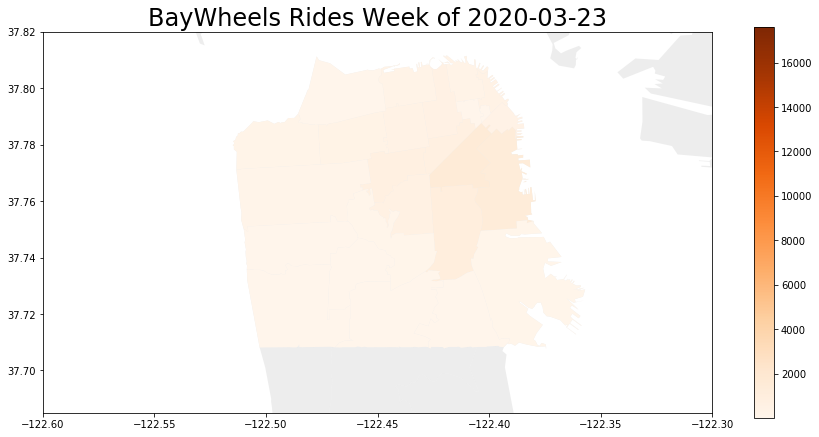

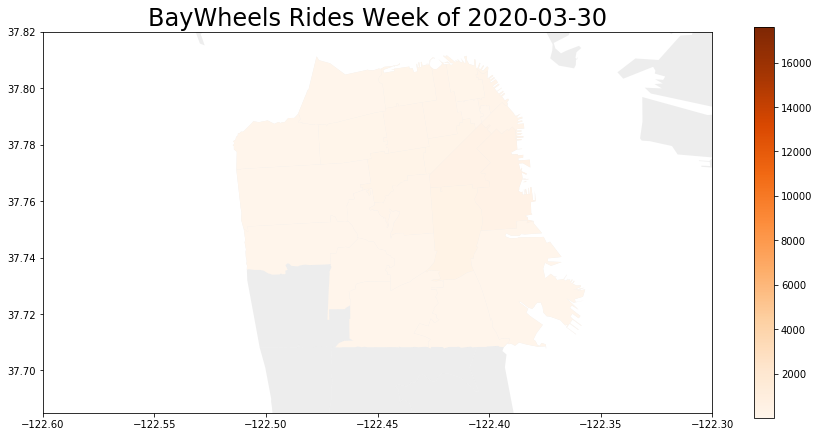

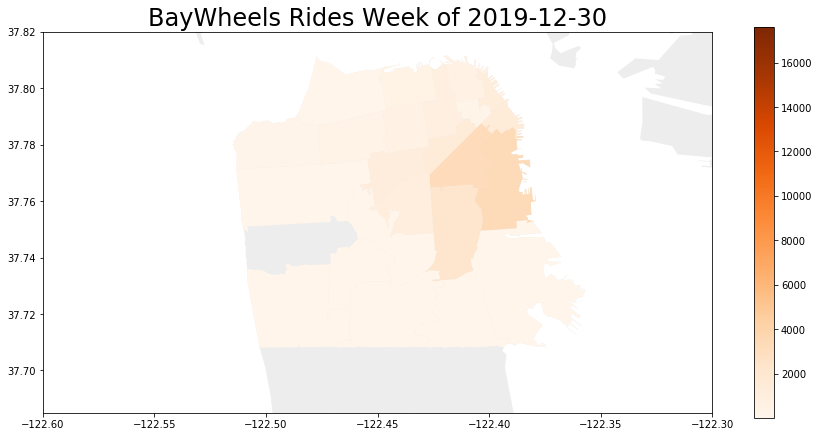

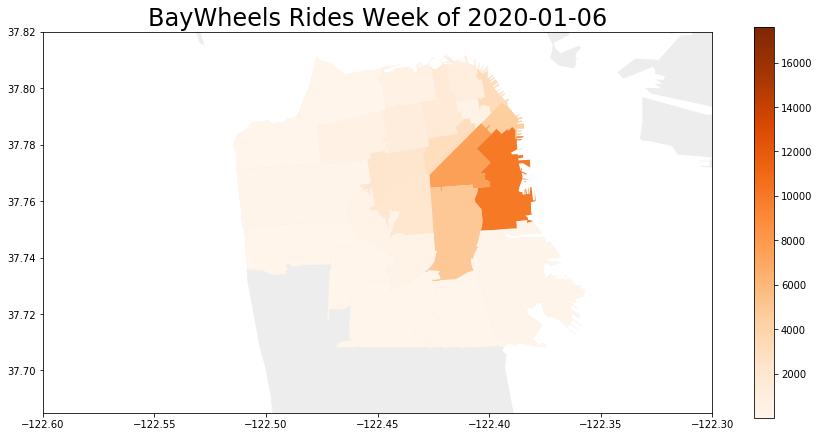

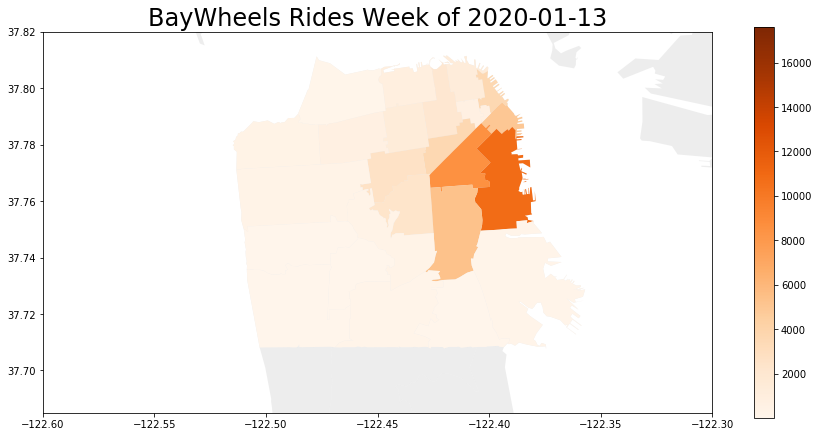

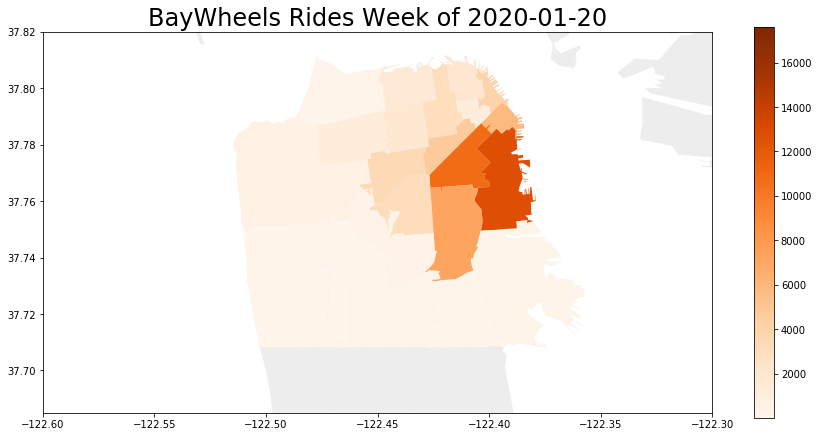

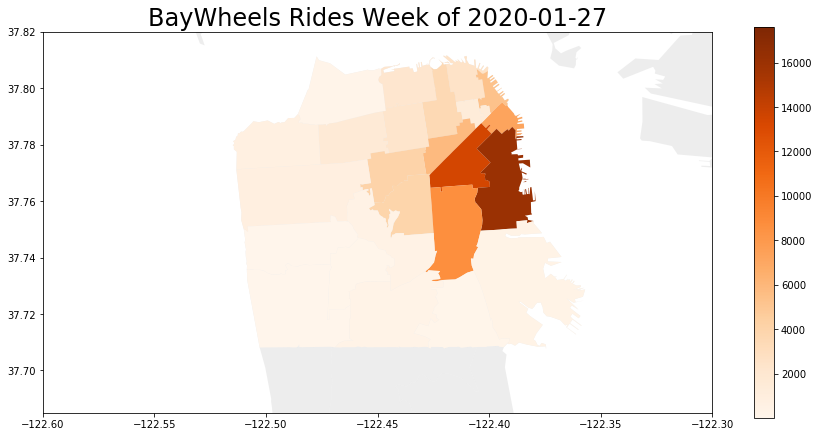

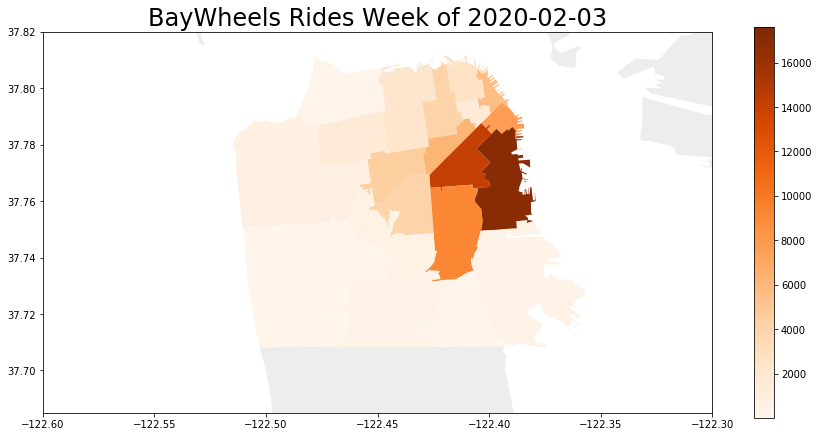

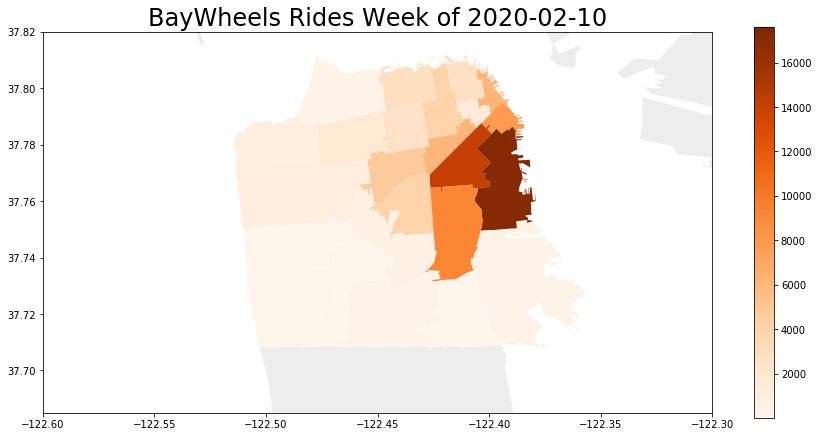

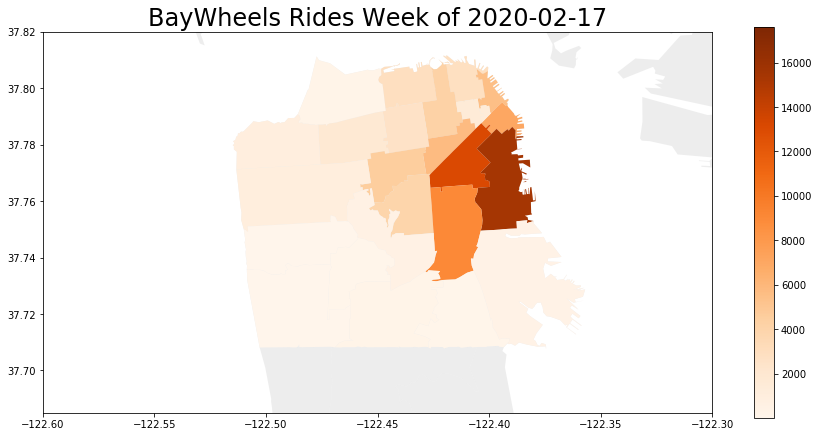

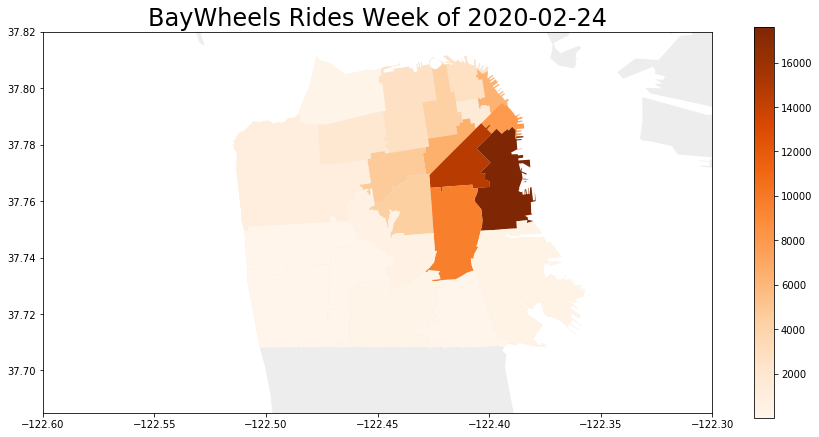

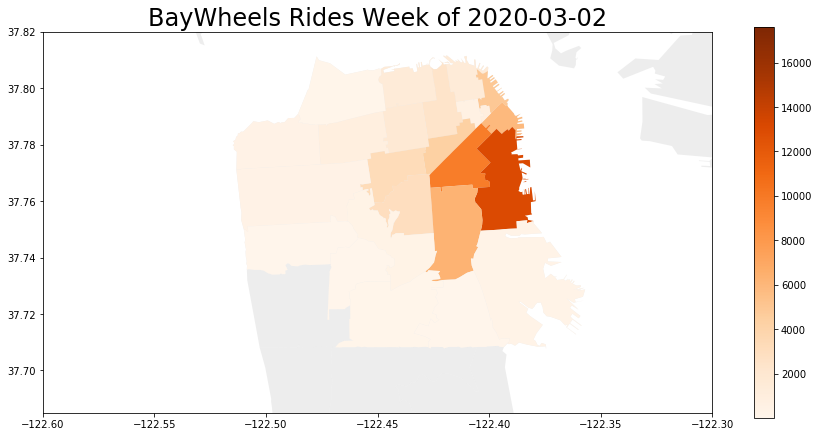

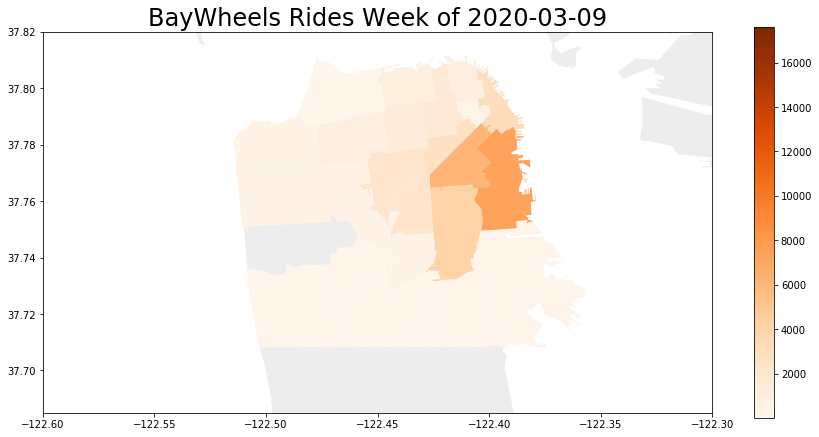

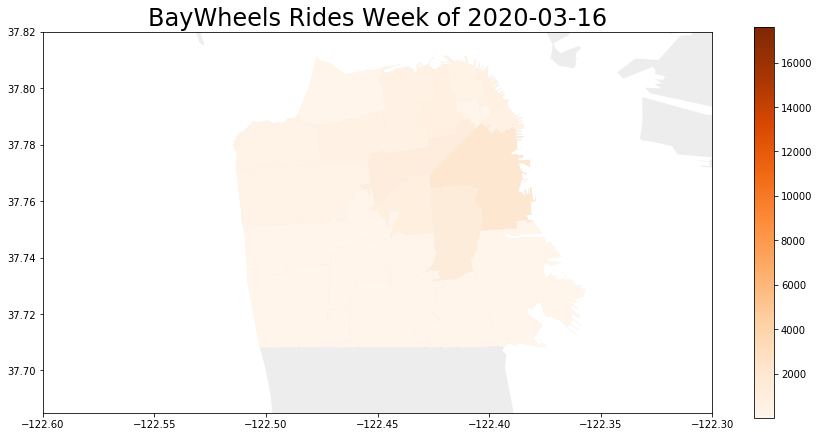

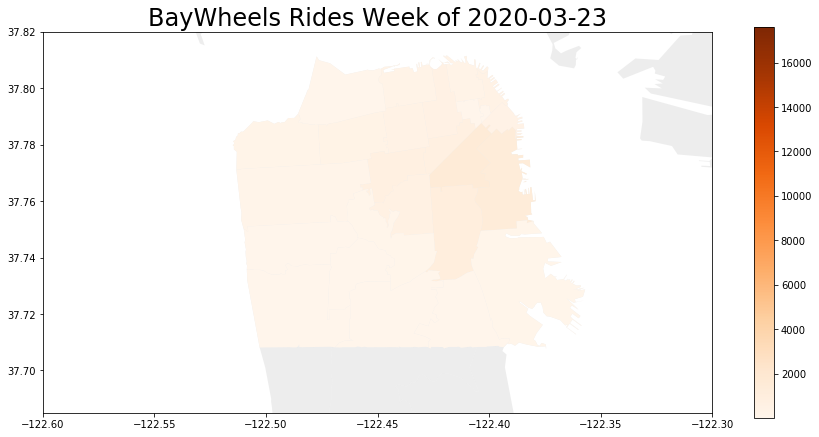

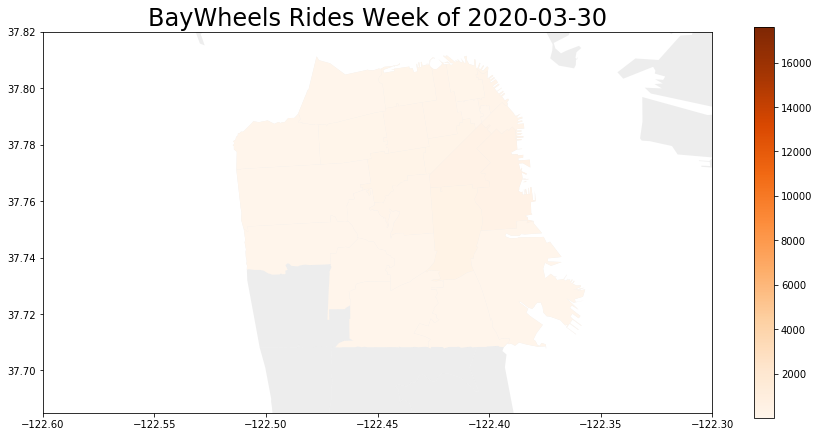

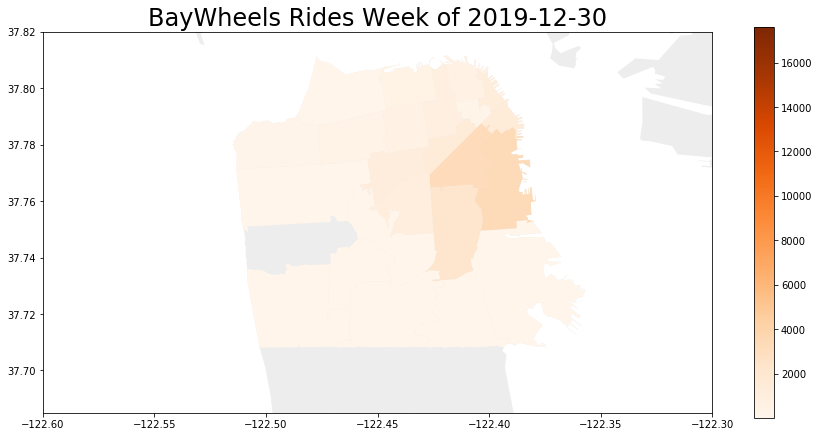

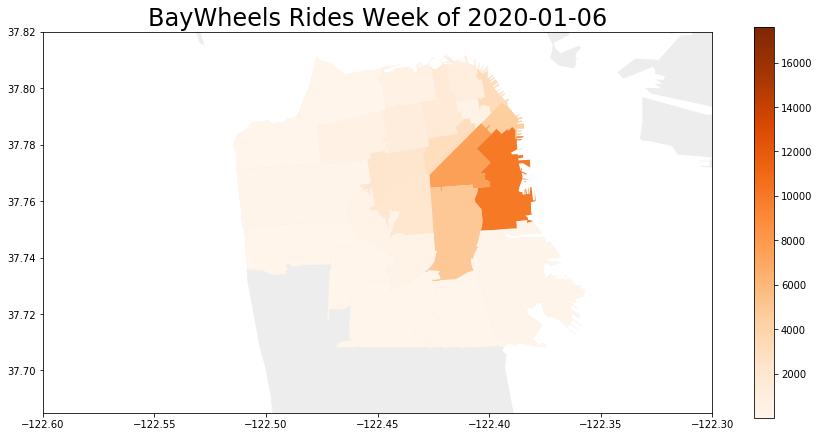

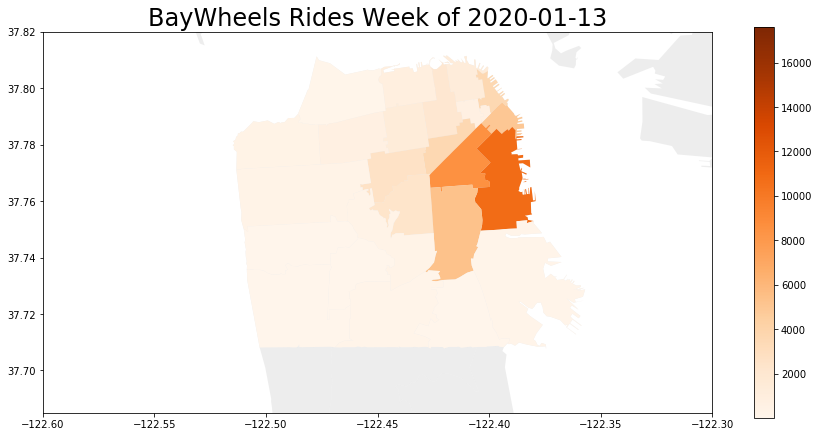

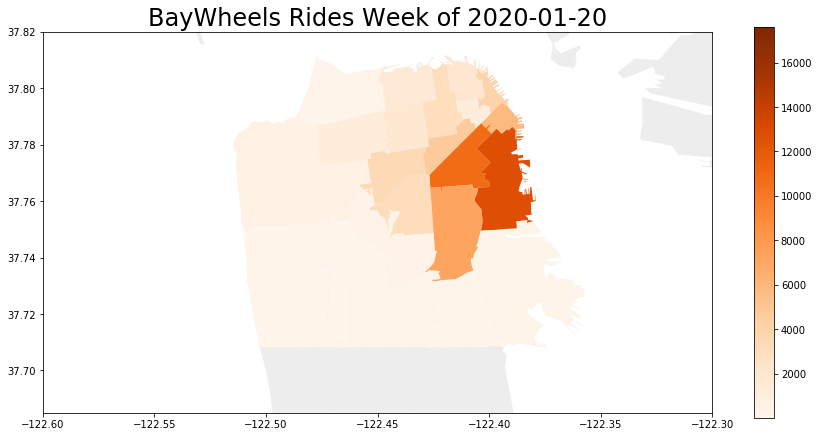

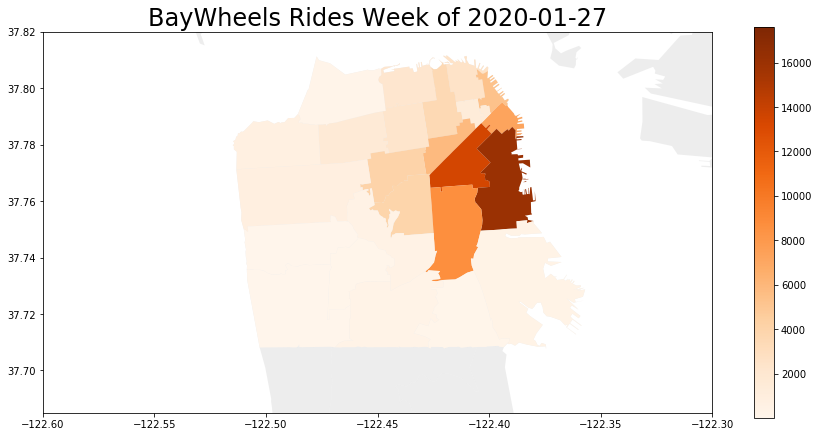

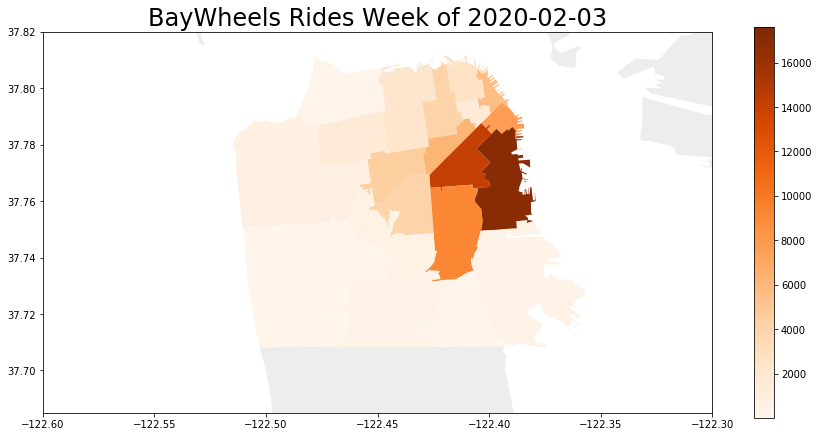

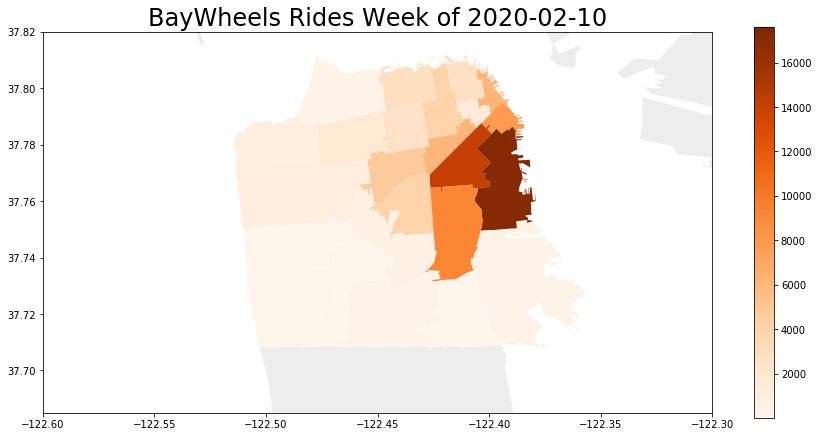

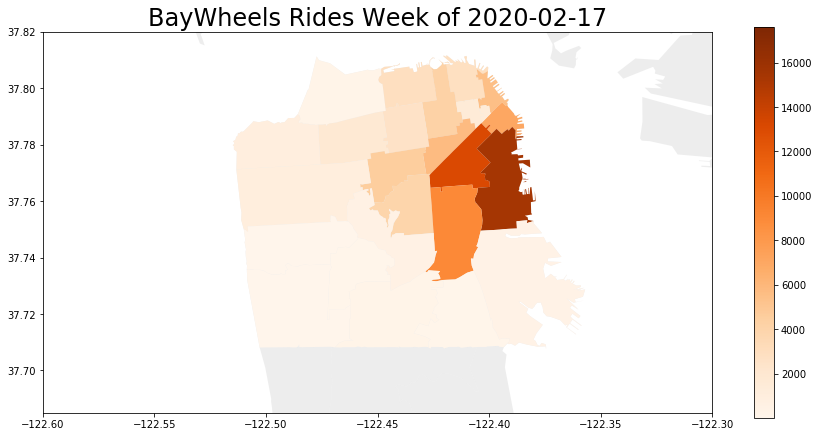

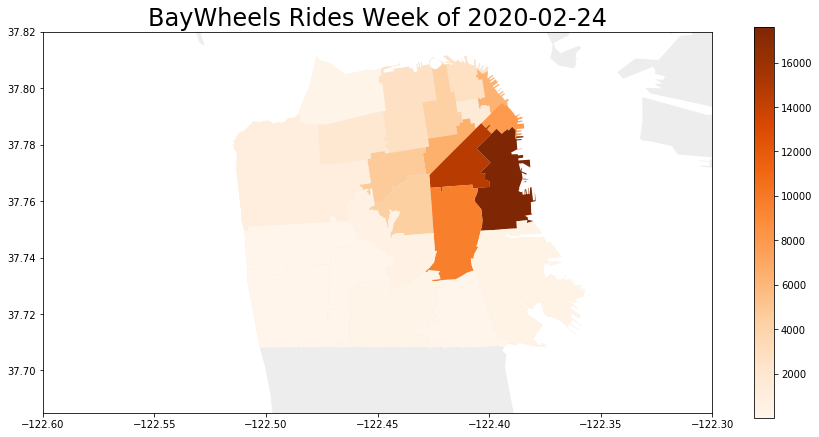

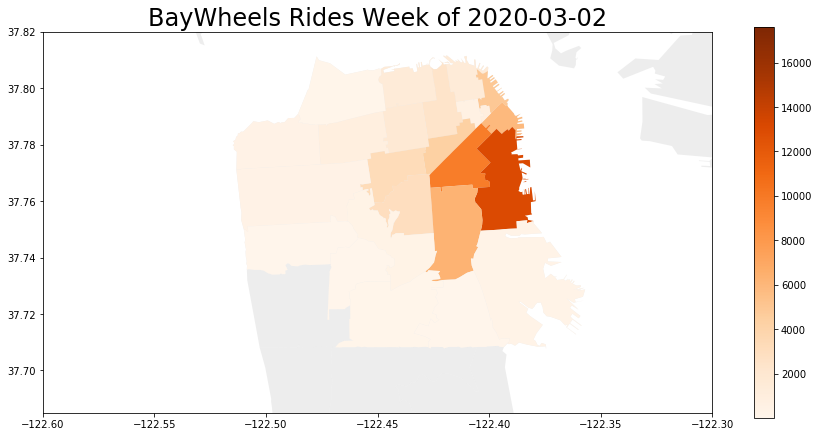

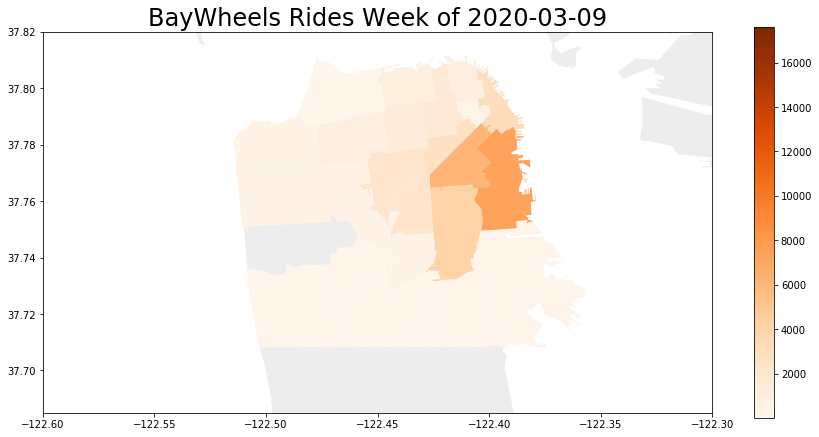

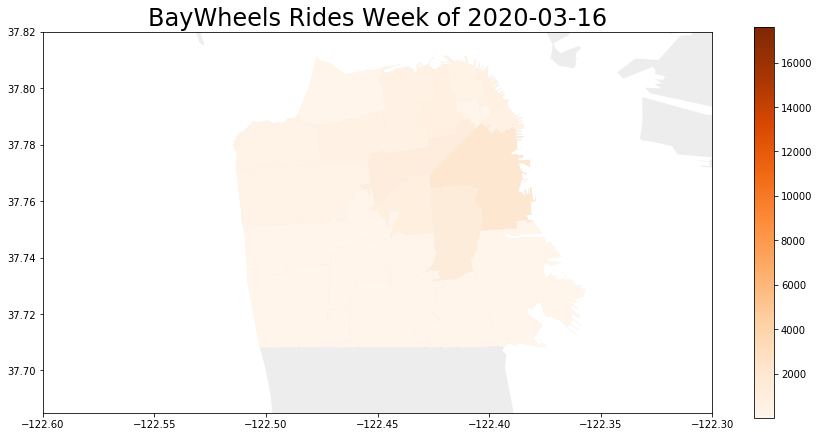

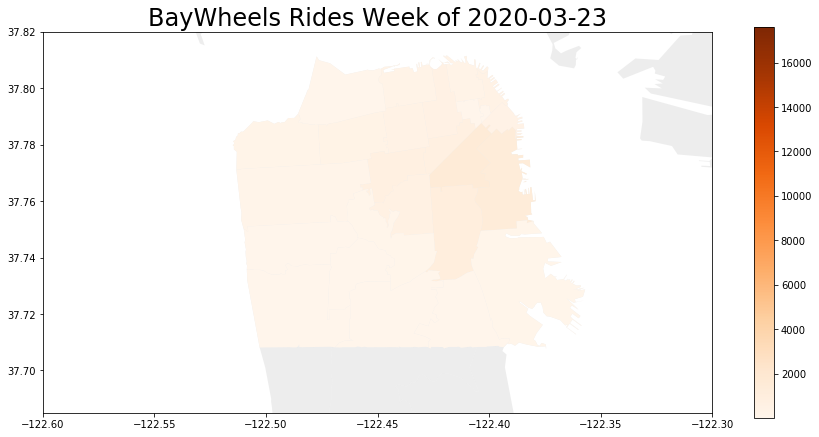

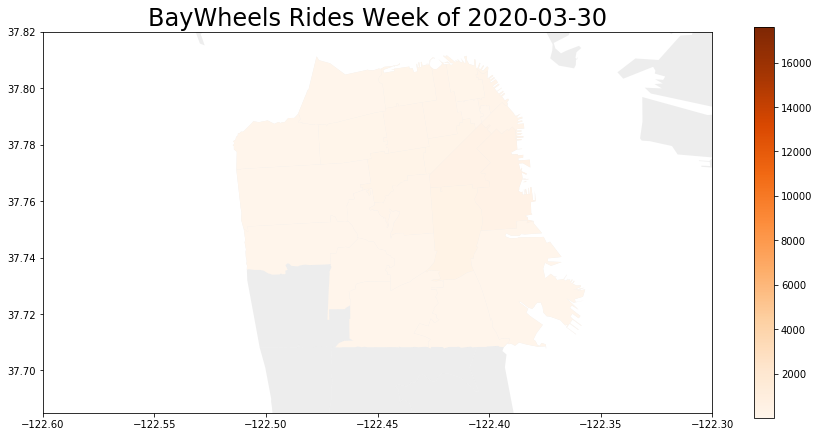

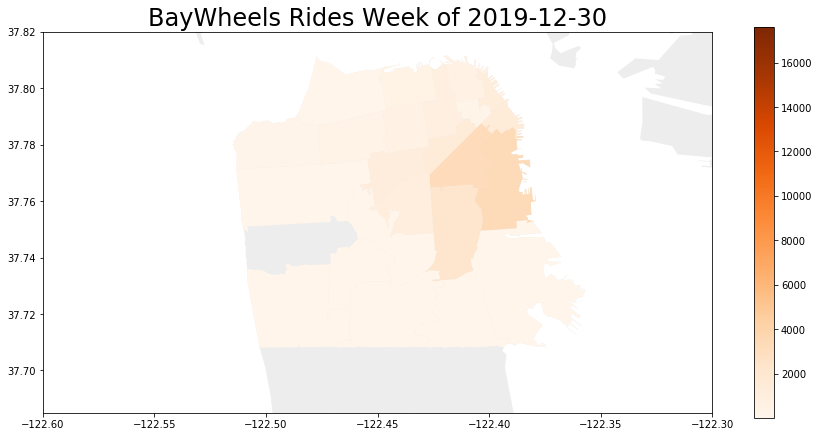

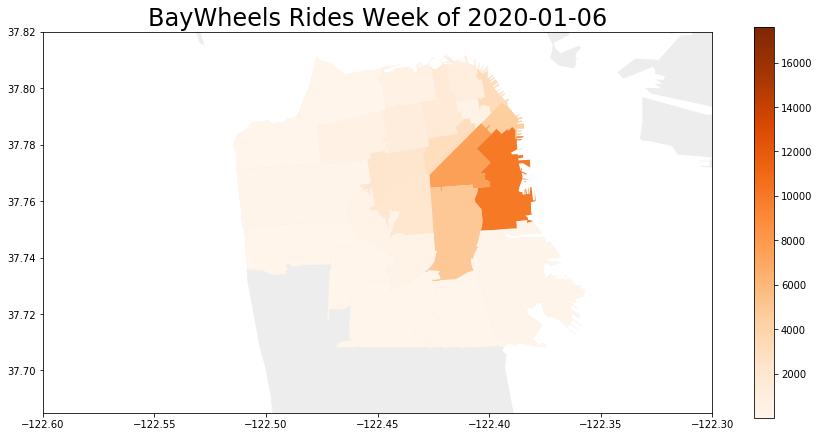

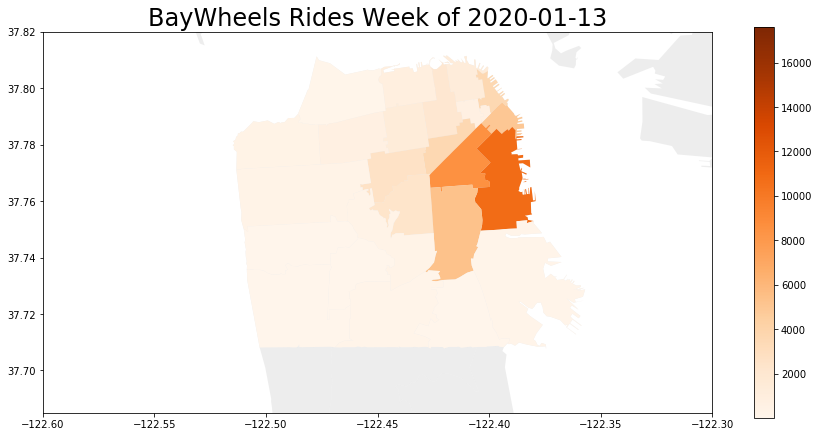

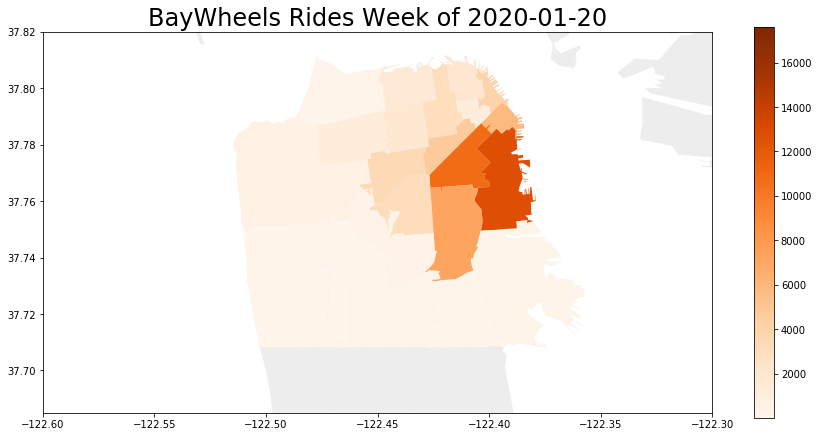

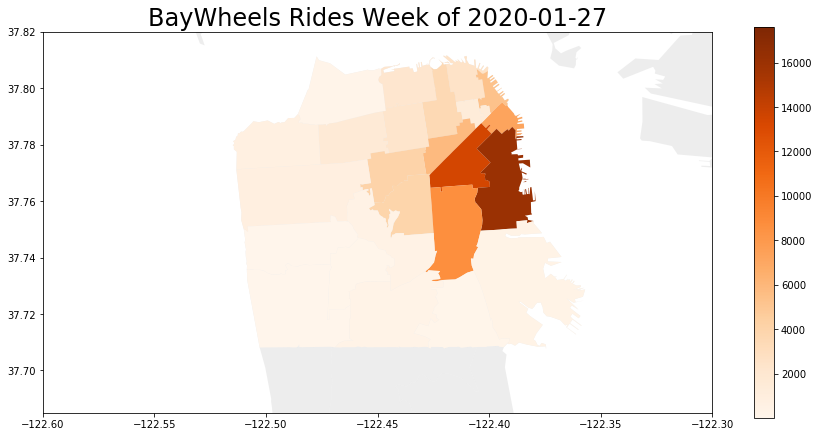

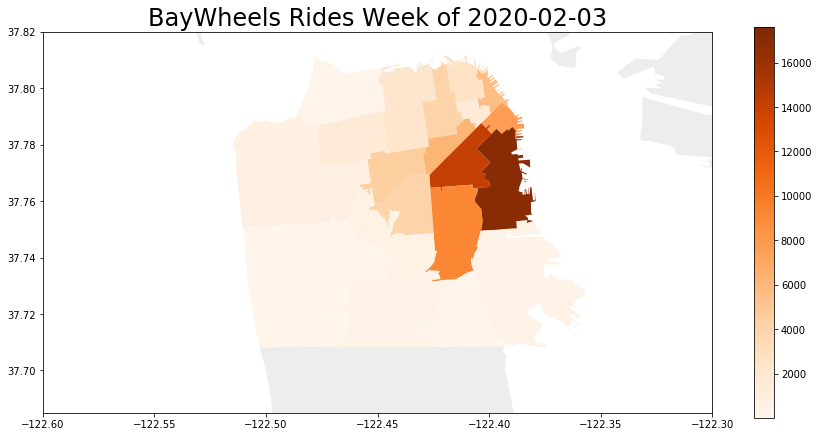

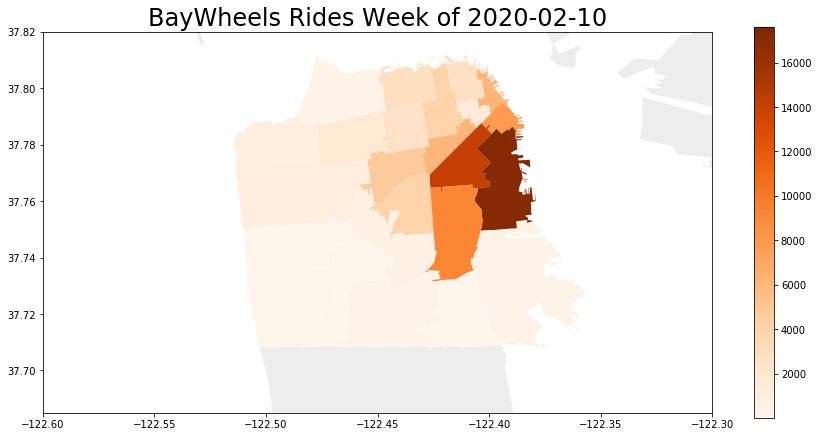

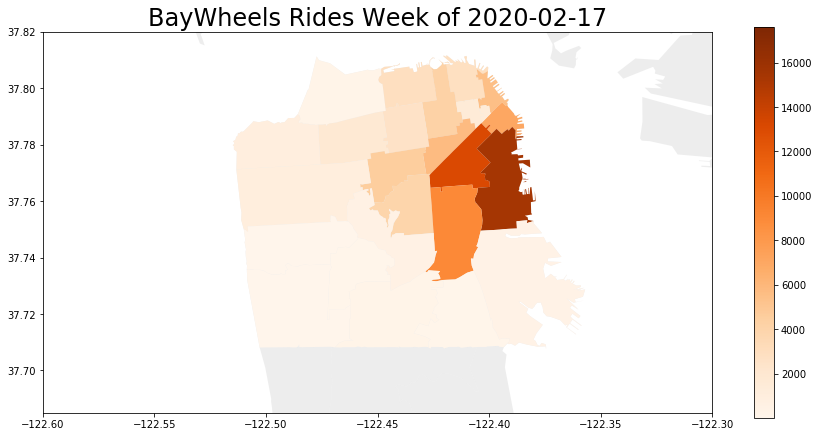

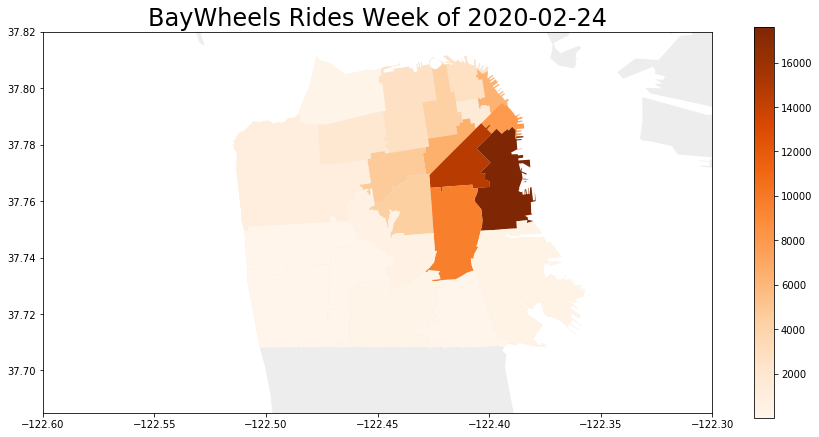

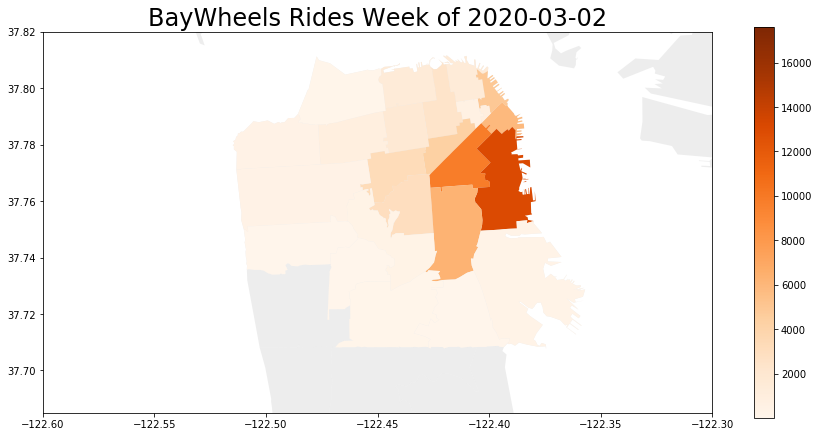

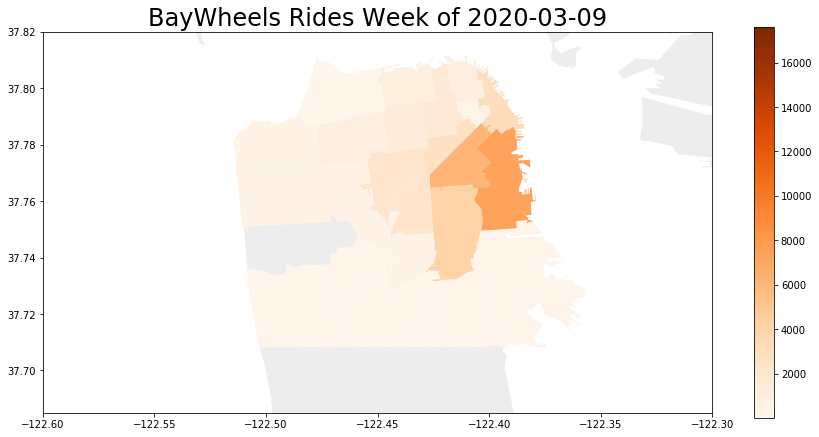

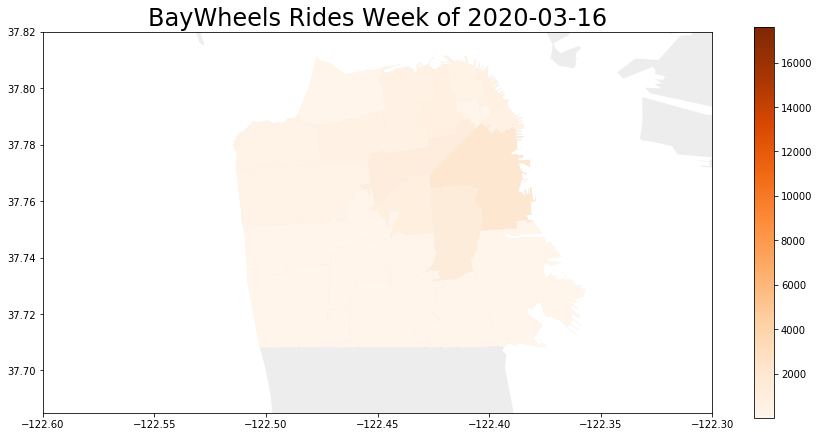

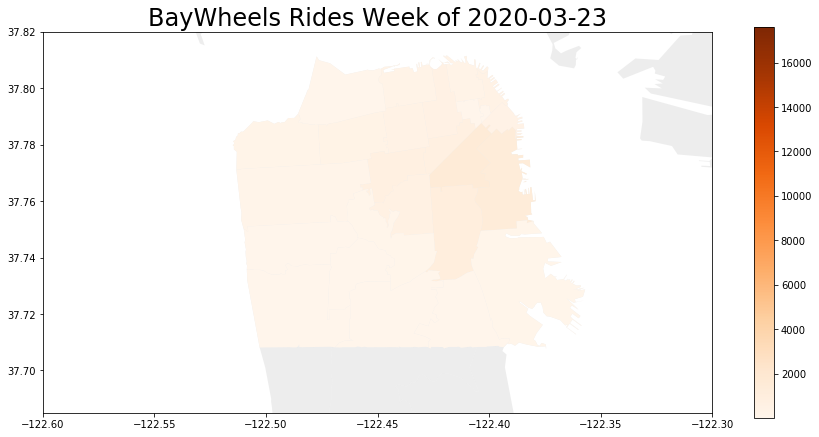

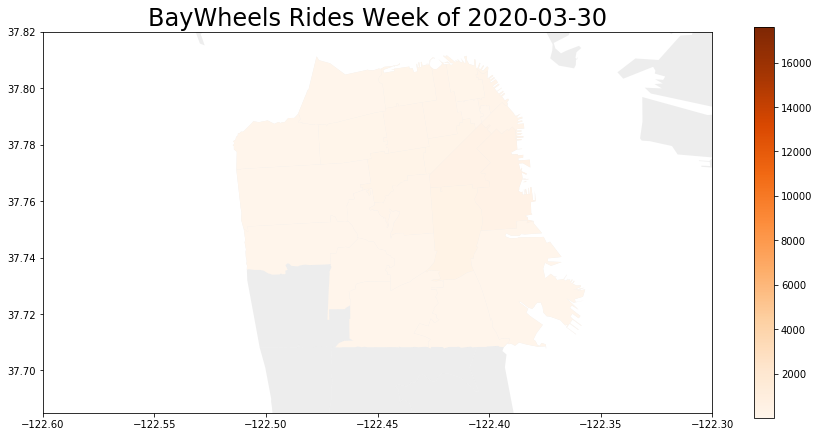

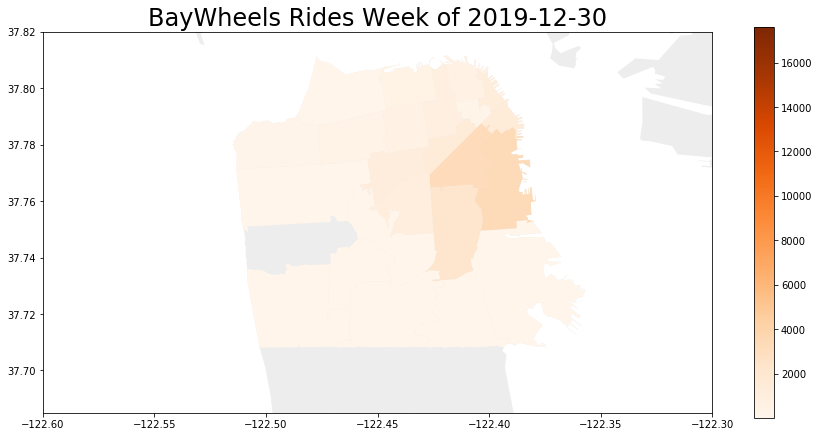

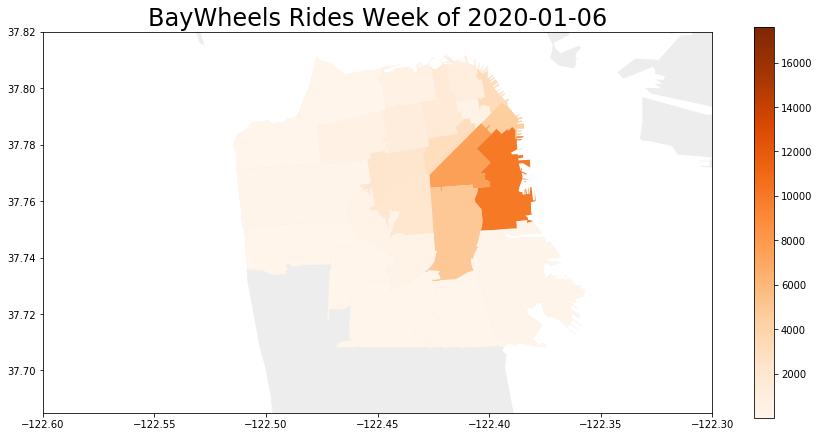

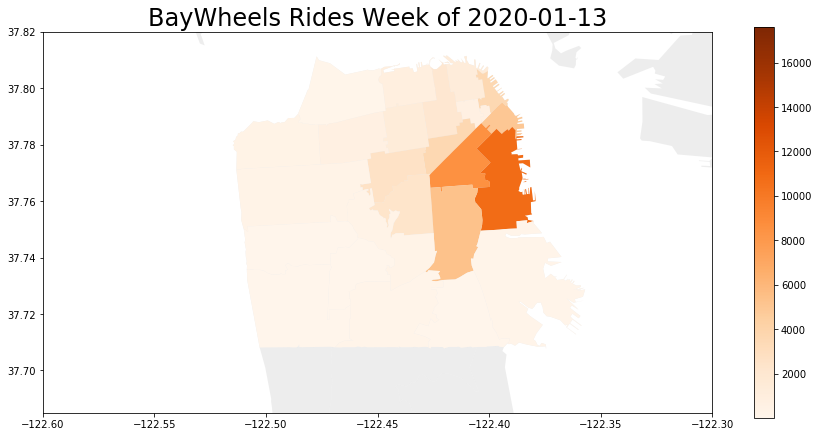

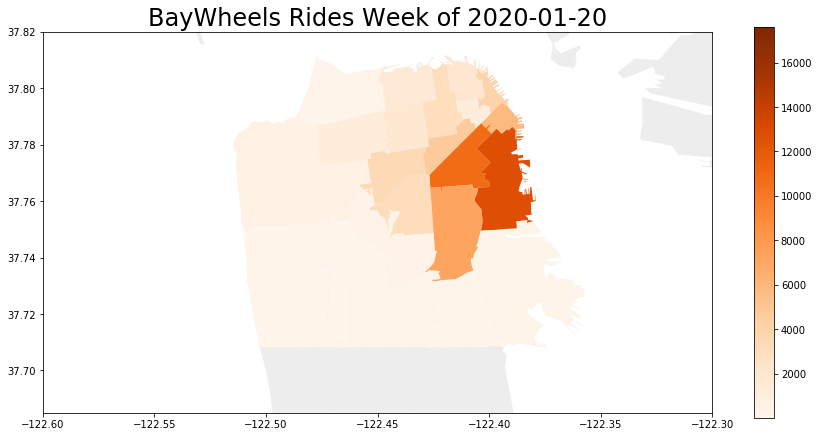

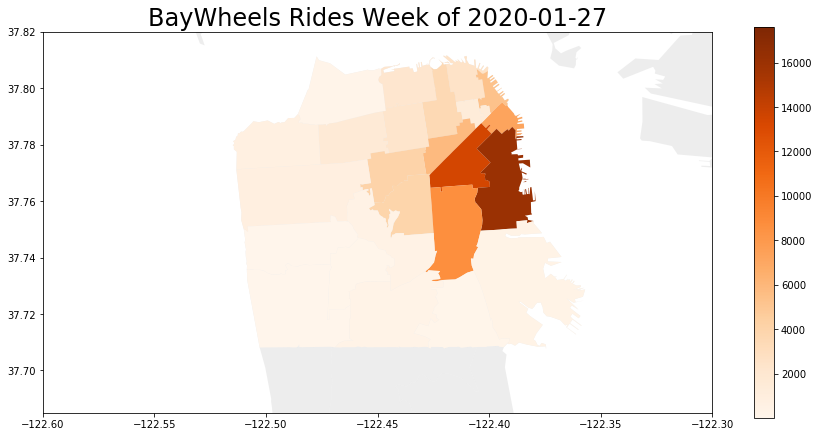

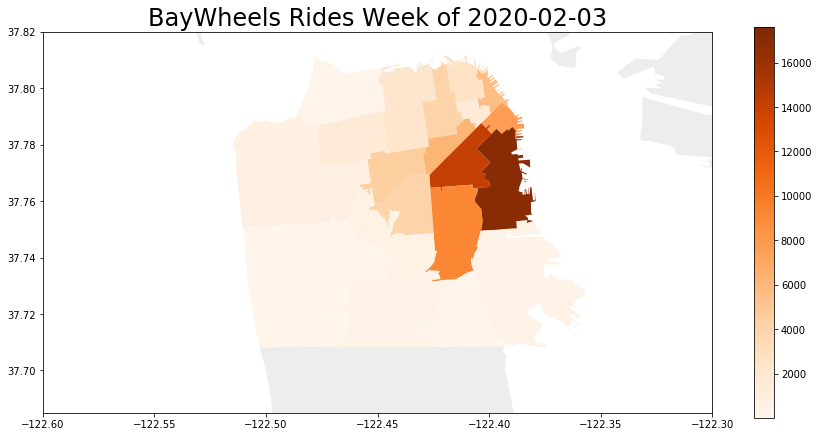

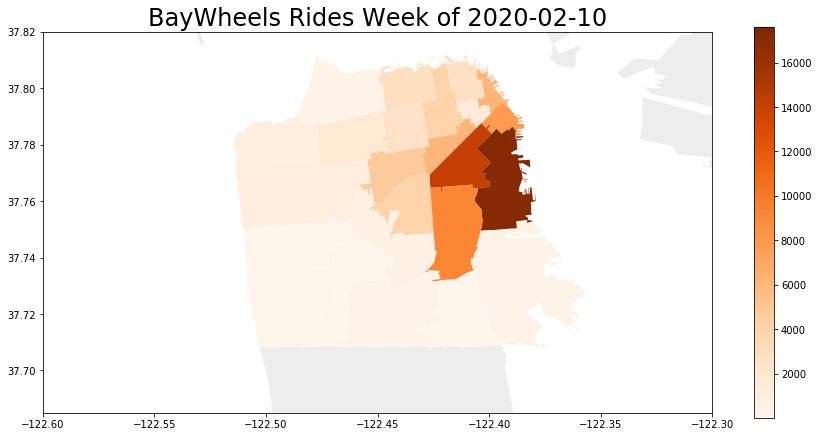

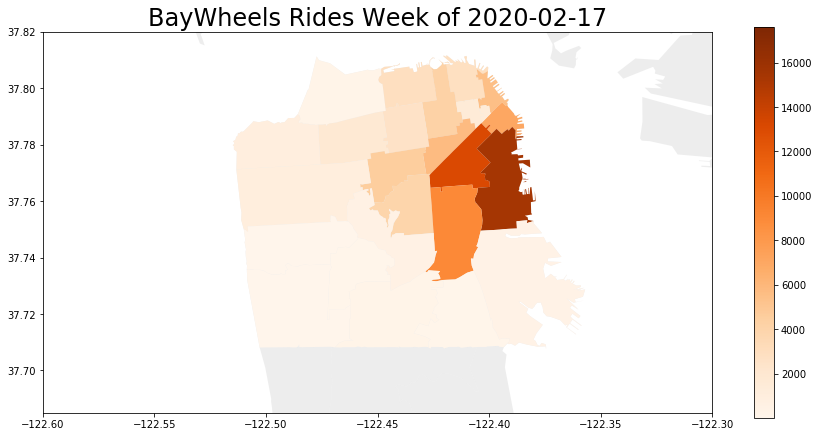

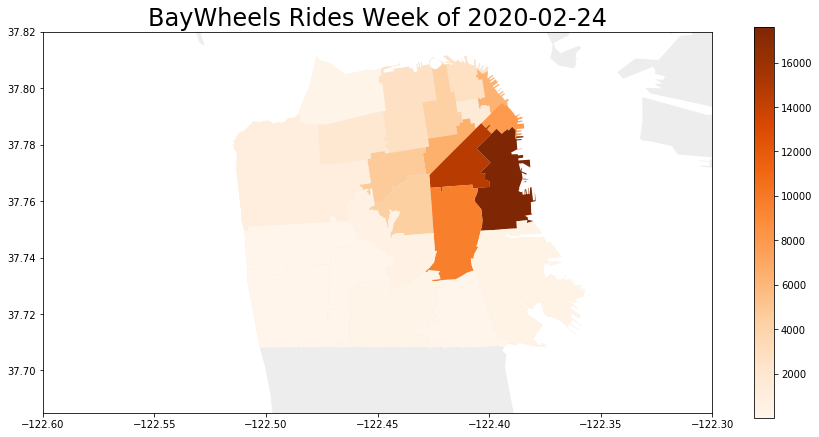

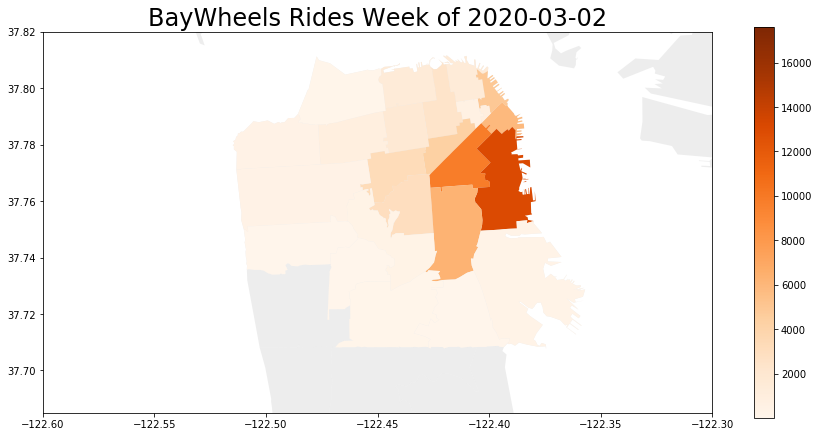

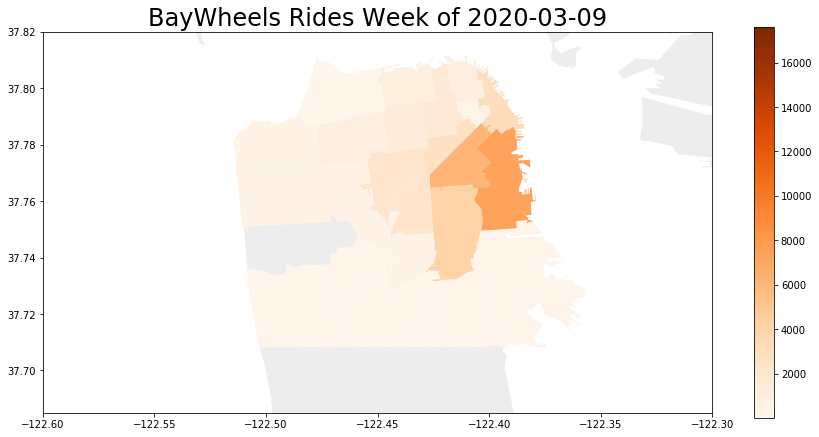

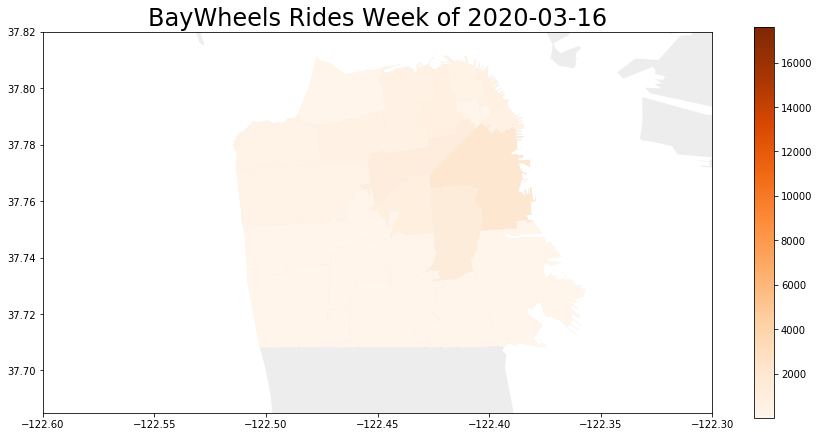

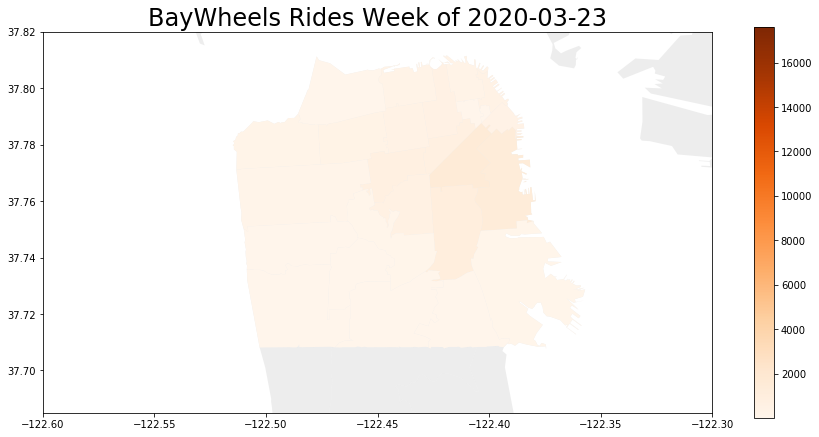

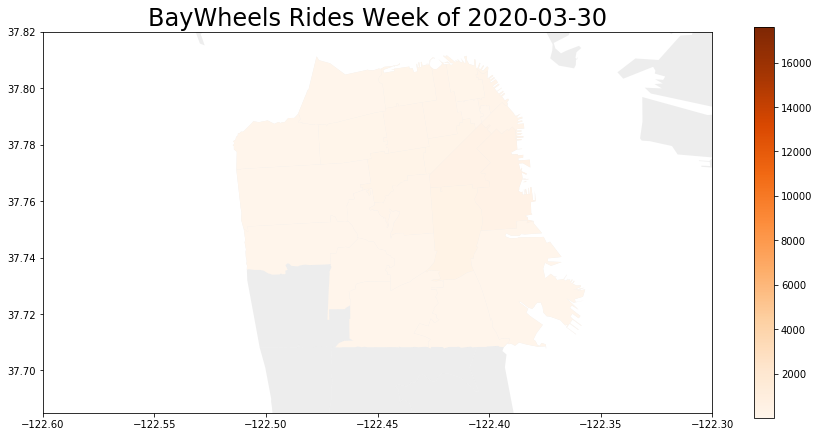

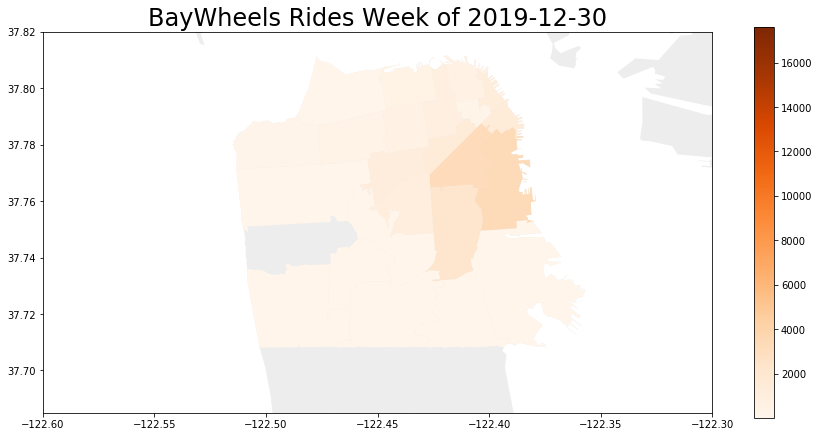

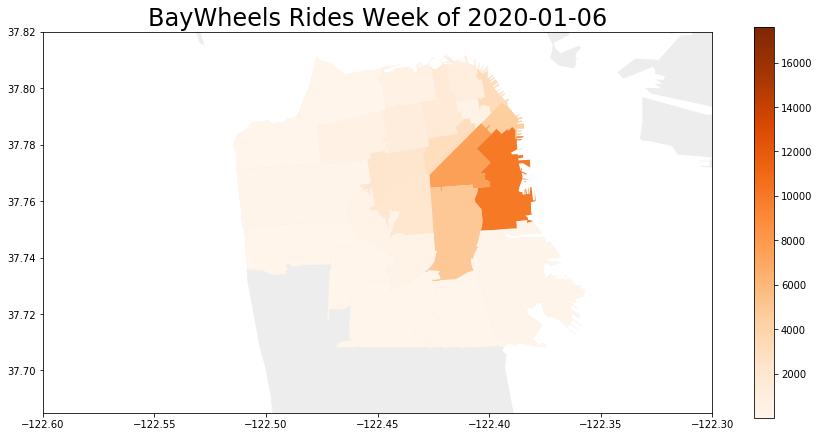

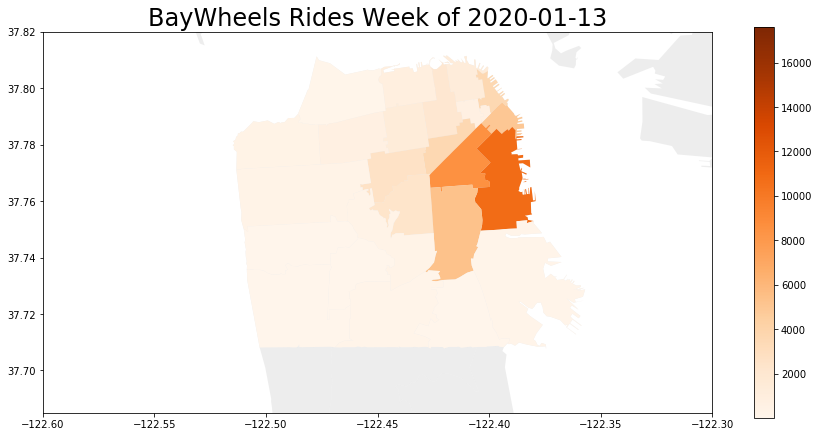

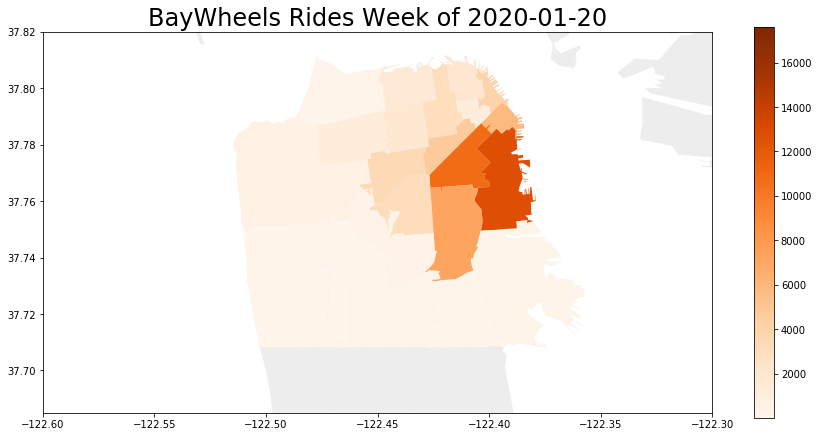

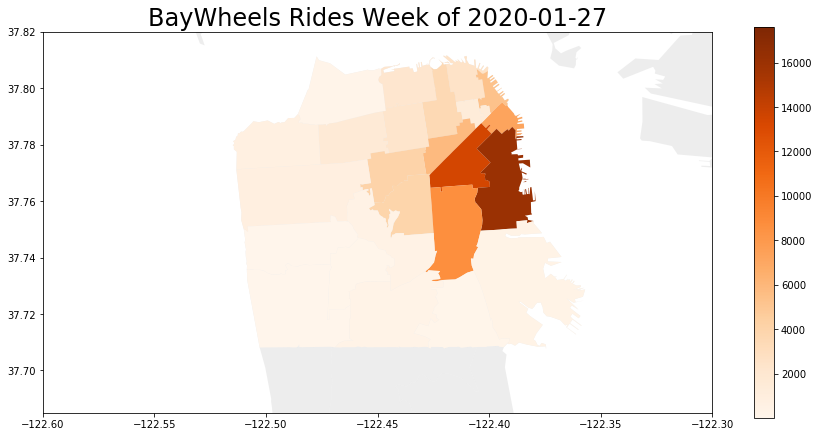

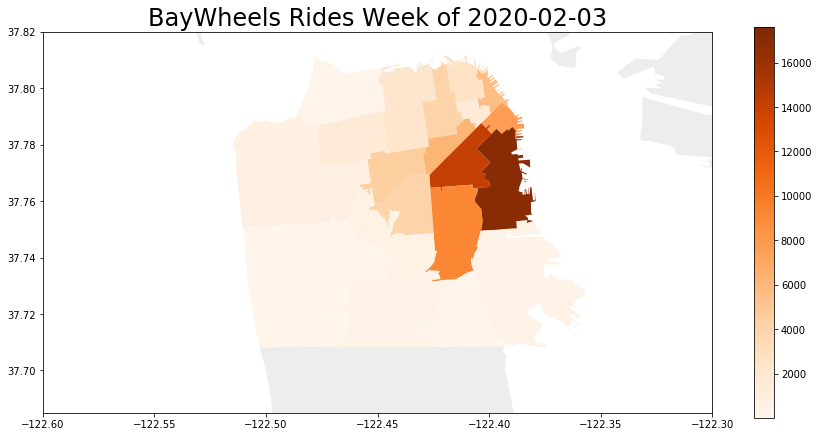

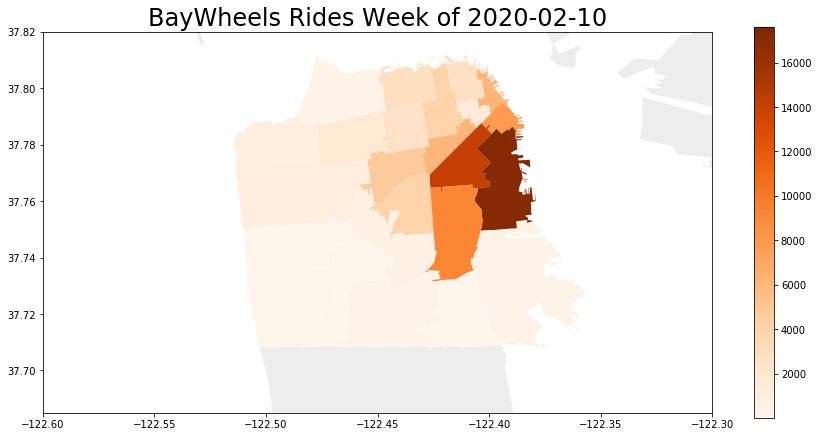

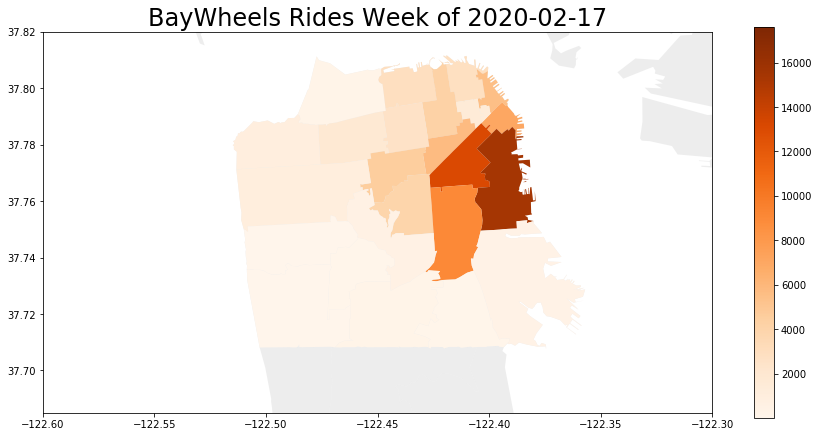

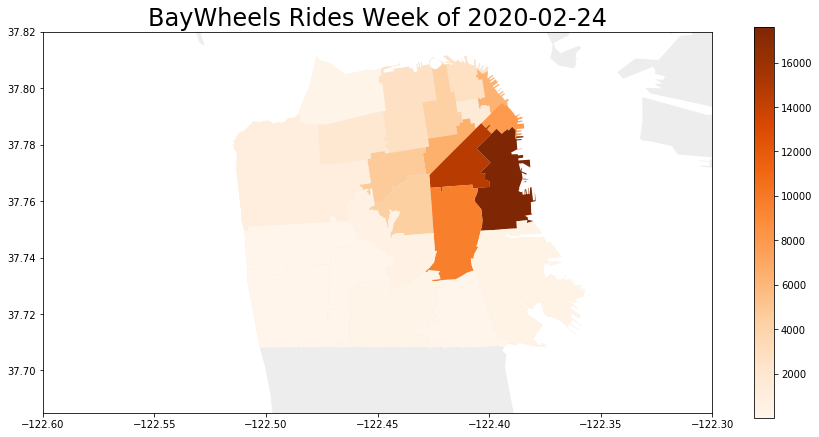

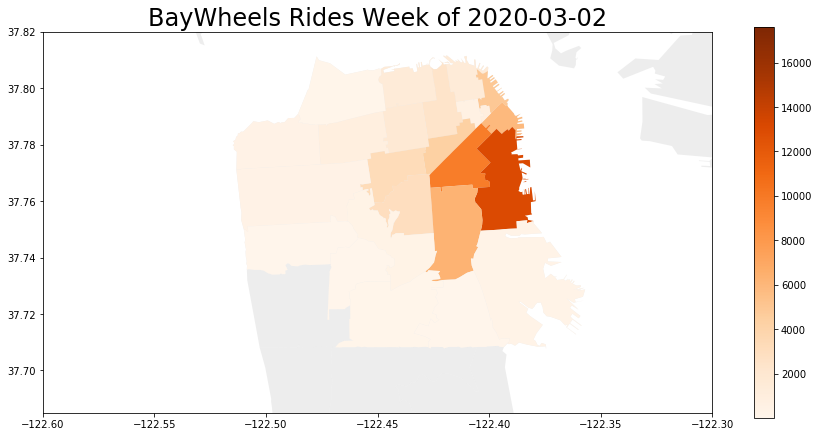

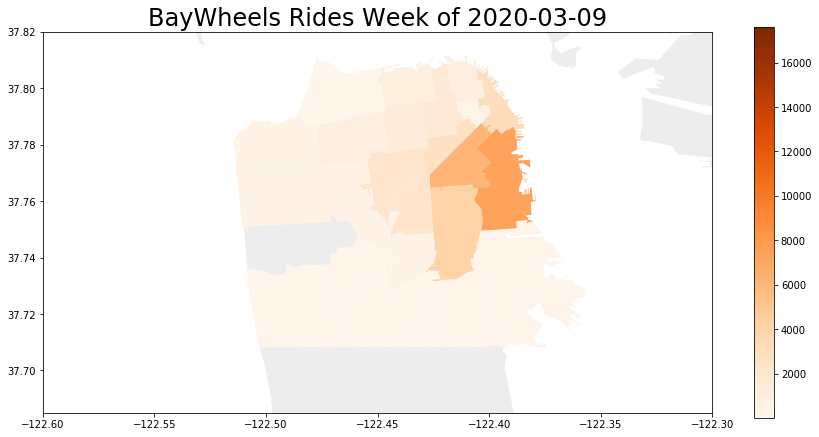

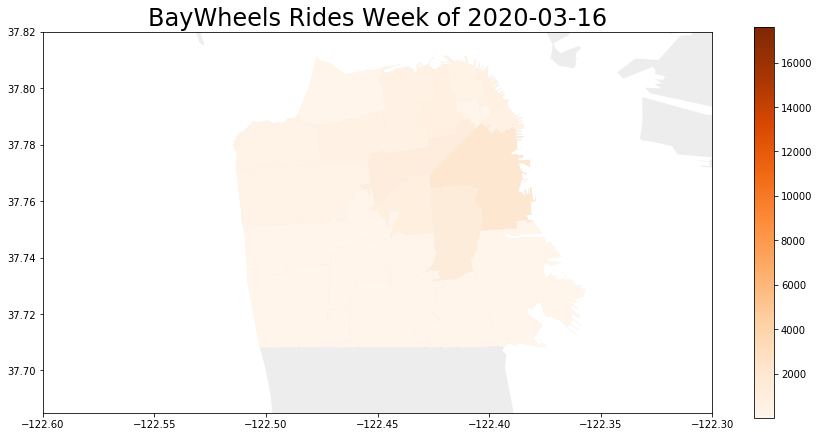

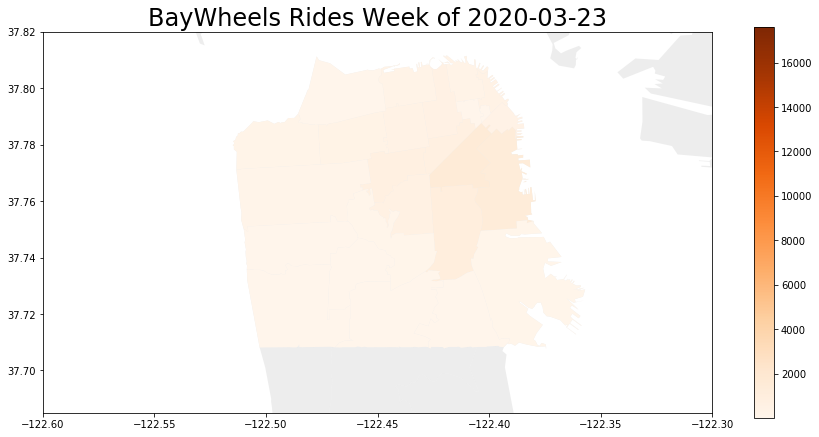

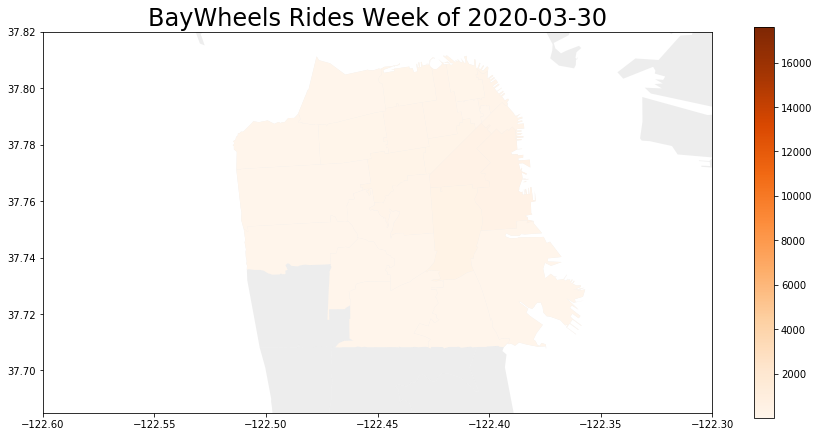

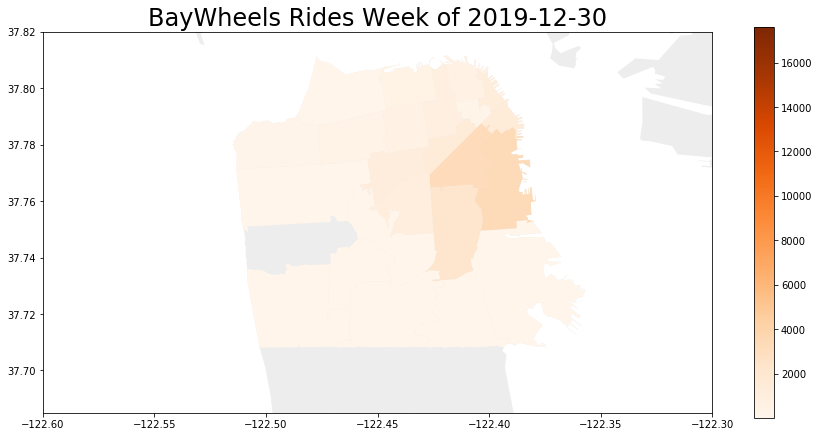

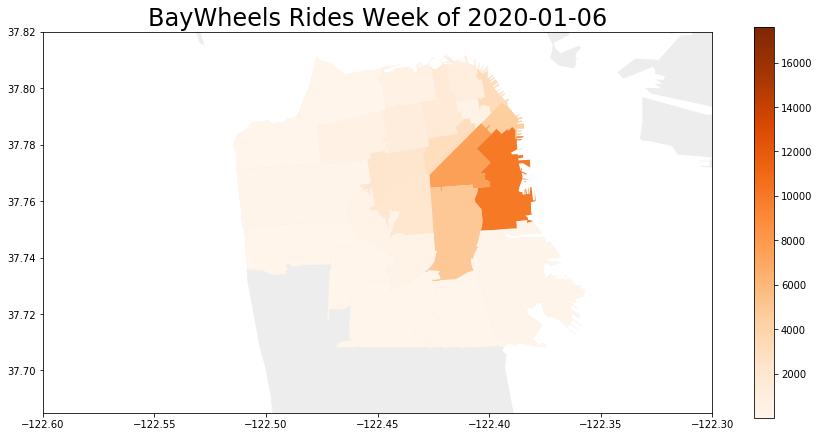

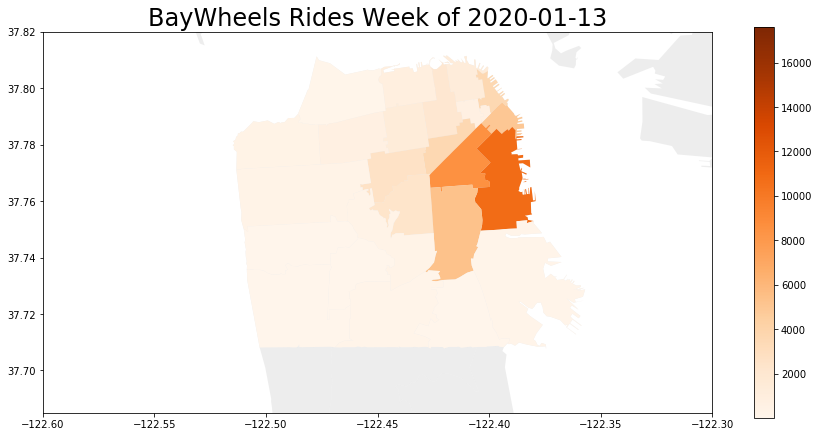

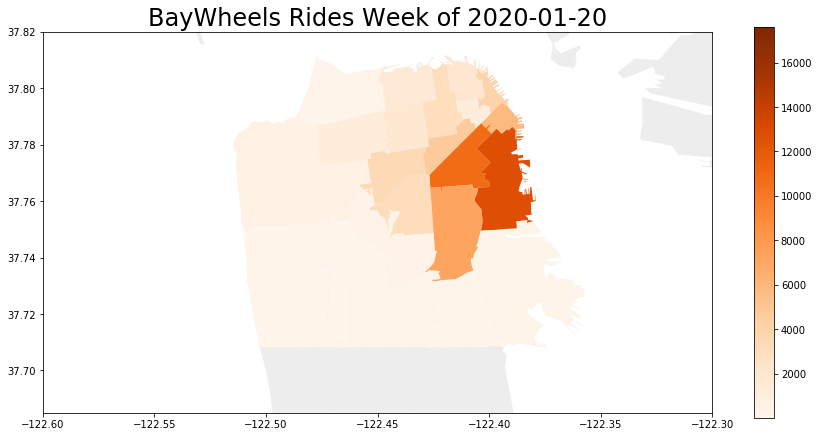

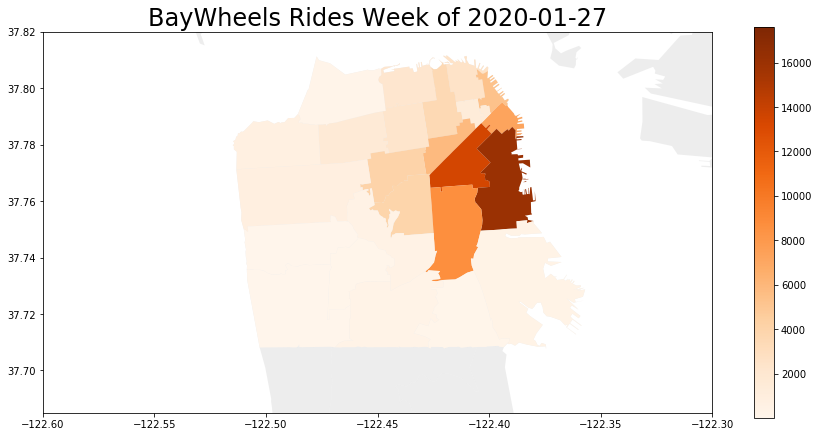

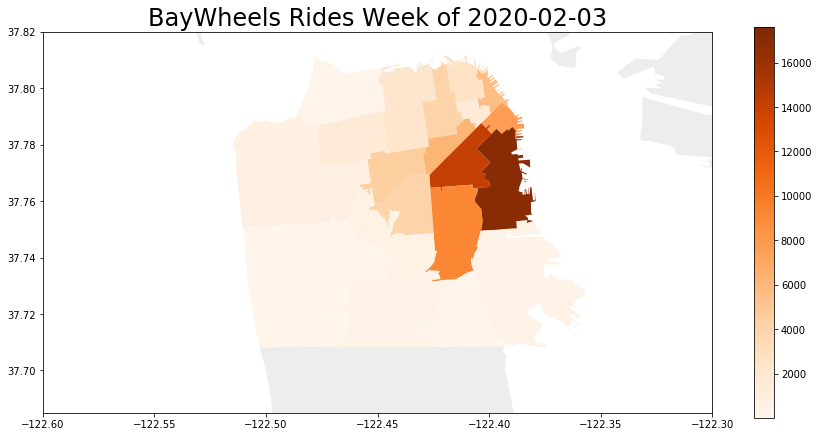

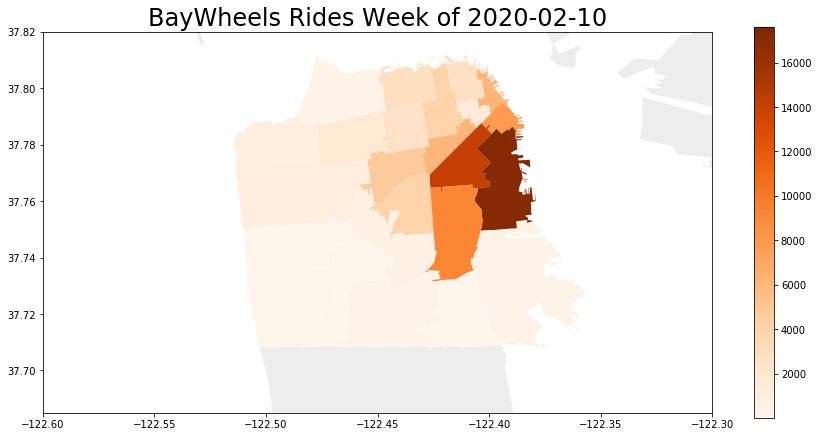

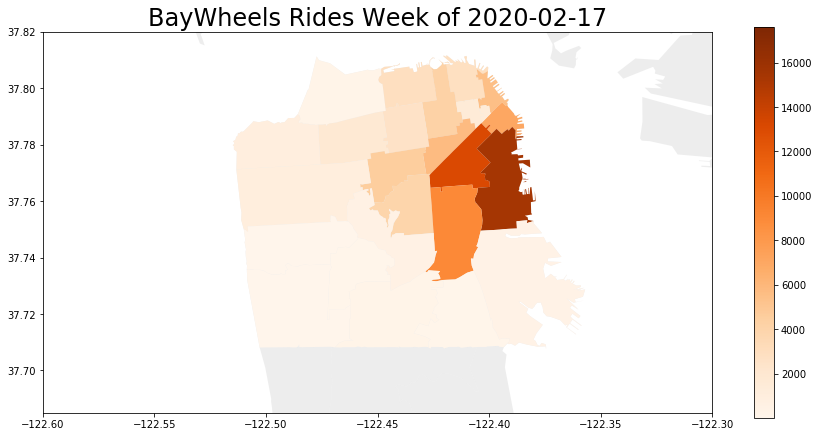

In [ ]:
## Finally calling the function. Can replace x with test data for debugging

x= geo_df_test_sf#geo_df_with_counts
print_map(x)

In [ ]:
## Final GIF

convert -delay 75 *.png baywheels-project2.gif

## Sources

_This information, particularly the tutorials and guides on `Medium`, were instrumental in this project_

#### Medium Articles
1. Importing CSVs: https://medium.com/@kadek/elegantly-reading-multiple-csvs-into-pandas-e1a76843b688
2. Time lapse display: https://medium.com/@tyreus/visualizing-the-spread-of-the-2019-coronavirus-with-python-7e63230f9505
3. GeoPandas Plotting:      https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

#### Primary Sources
4. Bike Data:      https://s3.amazonaws.com/baywheels-data/index.html
5. Shape Files:    https://geodata.lib.berkeley.edu/?bbox=-127.749023+29.036961+-112.412109+45.675482&f%5Bdc_format_s%5D%5B%5D=Shapefile&f%5Bdct_spatial_sm%5D%5B%5D=San+Francisco+Bay+Area+%28Calif.%29&per_page=10

#### Formal Documentation
6. Pandas:         https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
7. GeoPanda Documentation: https://geopandas.org/reference.html
8. Matplotlib Colors: https://matplotlib.org/3.1.0/gallery/color/named_colors.html

#### Historical Context
8. Bay Wheels Feb Price Increase: https://mashable.com/article/lyft-bay-wheels-ebike-price-increase/
9. COVID Timeline in Bay Area: https://abc7news.com/timeline-of-coronavirus-us-coronvirus-bay-area-sf/6047519/